In [1]:
cd ../TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
from TileEM_plot_toolbox import *
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# from BB2TileExact import *

In [4]:
def overlap(a,b):
    if a.area>b.area:
        larger_area = a.area
    else:
        larger_area = b.area
    return a.intersection(b).area/larger_area

In [5]:
# for objid in range(48):
#     tile = pkl.load(open("output/tiles{}.pkl".format(objid)))

In [6]:
objid=20
tiles = pkl.load(open("output/tiles{}.pkl".format(objid)))
plot_tile_duplicate_heatmap(objid,tiles)

NameError: name 'plot_tile_duplicate_heatmap' is not defined

In [5]:
def BB2TileExact(objid,BB,tqdm_on=False,save_tiles=True):
	'''
	Given a list of worker polygons BB (potentially sampled) and the objectID 
	return a list of non-overlapping tiles (shapely Polygon objects)
	# BB is a list of polygons based on worker BBs 
	'''	
	tiles=[]
	if tqdm_on: 
	    BB_lst = tqdm(range(len(BB)))
	else:
	    BB_lst=range(len(BB))
	for i in BB_lst:
	    bi = BB[i]
	    # base case, when i=0, only 2 polygon intersecting
	    if i==0:
	        tiles.append(bi)
	    else: 
	        xj_lst = []
	        for tj in tiles:
	            try:
	                xj=tj.intersection(bi)
	                if xj.area>1e-10: #eliminating spurious LineString-looking Polygons 
	                    tiles.remove(tj)
	                    add_object_to_tiles(tiles,xj)
	                    diff_region = (tj.symmetric_difference(xj)).difference(xj)#.buffer(0)
	                    add_object_to_tiles(tiles,diff_region)       
	                    xj_lst.append(xj)
	            except(shapely.errors.TopologicalError):
	                xj_lst=xj_lst[:-1]
	                pass
	        try:
	            leftovers = bi.difference(cascaded_union(xj_lst))
	        except(shapely.errors.TopologicalError):
	        	try: 
		            leftovers = bi.difference(cascaded_union(xj_lst).buffer(1e-10))
		        except(shapely.errors.TopologicalError):
		        	leftovers=[]	
	        except(ValueError):
	            #ERROR:shapely.geos:TopologyException: no outgoing dirEdge 
	            leftovers=[]
	            
	        add_object_to_tiles(tiles,leftovers)
	if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))
	return tiles

In [73]:
def compute_unique_tileset(tiles,PLOT=False):
    verified_tiles = []
    stop_here=False
    for tidx in tqdm(range(len(tiles))): 
        #if tidx==0:
        #    verified_tiles.append(tiles[0])
        t=tiles[tidx]
        duplicated=False
        verified_tiles_new= verified_tiles[:]
        for vtidx in range(len(verified_tiles)):

            try:
                vt = verified_tiles[vtidx]
            except(IndexError):
                print "last element removed"
            try:
                overlap_score=overlap(vt,t)
                if overlap_score>0.2:
                    print "Duplicate tiles: ",tidx,vtidx, overlap_score, vt.area, t.area
                    duplicated=True
                    if overlap_score<0.99:
                            #verified_tiles.pop(vtidx)
                            verified_tiles_new.remove(vt)
                            overlap_region = vt.intersection(t)
                            #verified_tiles_new.append(vt.difference(overlap_region))
                            #verified_tiles_new.append(t.difference(overlap_region))
                            add_object_to_tiles(verified_tiles_new,overlap_region)
                            add_object_to_tiles(verified_tiles_new,vt.difference(overlap_region))
                            add_object_to_tiles(verified_tiles_new,t.difference(overlap_region))

                    if PLOT:# and tidx==185 and vtidx==51:
                        plt.figure()
                        plt.title("[{0},{1}]{2}".format(tidx,vtidx, overlap_score))

                        try:
                            plot_coords(vt)
                            plot_coords(t,linestyle='--',color="blue")
                            plot_coords(overlap_region,fill_color="lime")
                        except(AttributeError):
                            print "problem with plotting"
    #                 if tidx==185 and vtidx==51:
    #                     stop_here=True
    #                     break
            except(shapely.geos.TopologicalError):
                print "Topological Error",tidx,vtidx
        if stop_here:
            break
        if not duplicated:
            verified_tiles_new.append(t)
        verified_tiles=verified_tiles_new[:]
    return verified_tiles

 14%|█▍        | 69/478 [00:00<00:04, 91.08it/s] 

Duplicate tiles:  59 58 0.999999767218 0.088794542913 0.0887945222431
Duplicate tiles:  78 23 0.467035553011 1.01806526807 0.481818181818
Duplicate tiles: 

 19%|█▉        | 92/478 [00:01<00:05, 69.30it/s]

 80 6 0.985746675675 0.147393048128 0.145292272939
Duplicate tiles:  102 10 0.673781731951 40.0485995756 59.4377039872
Duplicate tiles: 

 24%|██▍       | 115/478 [00:02<00:06, 55.53it/s]

 114 68 0.219298985926 0.0174113755309 0.0793956043958
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (145.6 140.55, 145.6 140.55) and LINESTRING (145.6 140.55, 145.6 140.55) at 145.60000008309231 140.55000000692436
 29%|██▉       | 138/478 [00:02<00:07, 47.92it/s]

 129 18 0.253476689422 0.290128582468 1.14459413136
Topological Error 129 18
Duplicate tiles:  139 21 0.63909230585 0.55579246624 0.608872608873
Duplicate tiles: 

 34%|███▎      | 161/478 [00:03<00:07, 40.97it/s]

 156 75 0.999997727996 0.14529220721 0.145291892744
Duplicate tiles:  161 64 0.9999961146 0.00210084847586 0.00210084031323
Duplicate tiles:  161 76 0.999999711988 0.0021008409183 0.00210084031323
Duplicate tiles:  170 160 0.289915140257 3.00943284808 10.3803921569
Duplicate tiles: 

 38%|███▊      | 184/478 [00:05<00:08, 35.15it/s]

 182 178 0.901828445208 6.39171374765 7.07378472222
Duplicate tiles:  185 51 0.88424107456 1982.45601307 1778.75431921
Duplicate tiles:  187 14 0.382061427567 2.17948717949 4.39585642074
Duplicate tiles:  197 61 0.265734265734 0.153409090909 0.4
Duplicate tiles:  198 89 0.512611431567 0.111363636363 0.217247664616
Duplicate tiles: 

 43%|████▎     | 207/478 [00:06<00:08, 30.39it/s]

 204 3 0.278087318026 0.737639553591 0.205128205128
Duplicate tiles:  210 90 0.217614476219 0.93157826731 0.91805518777
Duplicate tiles:  213 209 0.349815026419 2.90806736821 8.31315737916
Duplicate tiles:  218 174 0.55415103835 5.93491517974 4.22152320028
Duplicate tiles:  225 185 0.938593753668 10.542894139 11.2326489472
Duplicate tiles:  226 68 0.452373565001 0.542592592593 0.245454545455
Duplicate tiles:  227 242 0.250538652556 4.65555555556 1.43010610846
Duplicate tiles:  229 141 0.522692815572 3.35319035093 6.35
Duplicate tiles: 

 48%|████▊     | 230/478 [00:08<00:09, 25.90it/s]

 229 146 0.339277443261 2.49572649573 6.35
Duplicate tiles:  232 61 0.90303030303 0.1 0.090303030303
Duplicate tiles:  233 181 0.41028948396 85.9653586275 154.106722917
Duplicate tiles:  240 78 0.489370503153 0.291444307545 0.420513678437
Duplicate tiles:  242 79 0.544827584874 0.0854978354978 0.156926406698
Duplicate tiles:  242 243 0.528126263555 0.297138047138 0.156926406698
Duplicate tiles:  243 37 0.999999999462 0.464285714286 0.46428571425
Duplicate tiles:  244 196 0.999999986556 0.00188467299935 0.00188467299733
Duplicate tiles:  246 24 0.468482504222 3.96550931461e-07 1.86213596076e-07
Duplicate tiles:  247 1 0.703575251425 1.00050878858e-07 7.15917526556e-08
Duplicate tiles:  248 15 0.865414810057 0.0106635318704 0.0123218732545
Duplicate tiles: 

 53%|█████▎    | 253/478 [00:11<00:10, 22.08it/s]

 250 35 0.999999998631 0.400092747278 0.400092746899
Duplicate tiles:  253 239 0.295925266547 1.16639661579 2.54214014996
Duplicate tiles:  253 240 0.436382396799 3.38179105117 2.54214014996
problem with plotting
Duplicate tiles:  254 2 0.2728333 6.96113729007 3.95552910053
Duplicate tiles:  266 84 0.453493650425 1.67820512821 1.22783148389
Duplicate tiles:  269 87 0.23243939126 15.7336758195 3.65712602977
Duplicate tiles:  269 258 0.810295851906 4.51332191948 3.65712602977
Duplicate tiles:  271 33 0.892307692308 0.464285714286 0.414285714286
Duplicate tiles:  272 218 0.413931255994 5.40509001095 2.23733569699
Duplicate tiles: 

 58%|█████▊    | 276/478 [00:13<00:10, 19.77it/s]

 273 318 0.666878300869 3.16775431396 2.11250661446
Duplicate tiles:  277 30 1.0 6.08287683494 6.08287683494
Duplicate tiles:  281 323 0.999998809433 0.00235512610175 0.00235512890569
Duplicate tiles:  282 146 0.519638690761 11.6723757017 7.27290952775
Duplicate tiles:  283 263 0.289096012504 0.98401499575 2.53939205955
Duplicate tiles:  286 38 0.693127635388 1.27510798778 1.81513157895
Duplicate tiles:  288 78 0.262529641168 2.15232205137 8.19839634404
Duplicate tiles:  295 251 0.999999955592 0.0243362842666 0.0243362831858
Duplicate tiles: 

 63%|██████▎   | 299/478 [00:16<00:09, 18.17it/s]

 296 330 0.999999523223 0.734128118602 0.73412846744
Duplicate tiles:  299 286 0.340849796769 3.93000581398 1.7414187643
Duplicate tiles:  300 257 0.336415320561 5.78566450596 1.94638617974
Duplicate tiles:  308 351 0.641099502742 1.95619236746 3.05130850843
Duplicate tiles:  310 264 0.959481361426 7.7125 7.4
Duplicate tiles:  311 317 0.999999999998 0.312500000001 0.3125
Duplicate tiles:  311 368 1.0 0.3125 0.3125
Duplicate tiles:  313 208 0.376111078176 5.37857142857 6.54949744954
Duplicate tiles:  315 172 0.707693022589 31.2894662749 22.534927353
Duplicate tiles:  316 119 0.999994767305 0.0321430253375 0.0321428571429
Duplicate tiles: 

 67%|██████▋   | 322/478 [00:19<00:09, 16.78it/s]

 317 139 0.249481723888 8.18394553601 3.28959276018
Duplicate tiles:  324 57 0.671356541167 1.05427170868 1.03571428571
Duplicate tiles:  329 157 0.693918335689 0.74343277981 1.07135485773
Duplicate tiles:  329 386 0.306081664311 0.327922077922 1.07135485773
Duplicate tiles:  334 98 0.934946837037 14.1028349834 13.2752255223
Duplicate tiles: 

 72%|███████▏  | 345/478 [00:21<00:08, 15.69it/s]

 338 168 0.722570845007 35.950609627 33.0138264106
Duplicate tiles:  347 164 0.268946581301 13.0965810717 3.522280707
Duplicate tiles:  349 166 0.477398405783 0.202705627436 0.424604743083
Duplicate tiles:  365 80 0.791419455345 40.0480391357 47.089618684
Duplicate tiles:  367 83 0.270256282479 3.4936430883 8.47180695381
Duplicate tiles: 

 77%|███████▋  | 368/478 [00:24<00:07, 14.79it/s]

 367 238 0.353625577017 22.6907846412 8.47180695381
Duplicate tiles:  368 8 0.512091921165 0.0208333333333 0.0400301349382
Duplicate tiles:  371 318 0.252997285714 4.42783094099 16.9744809552
Duplicate tiles:  374 317 0.956597038381 7.81710829493 8.17178803307
Duplicate tiles:  376 294 0.76493675258 2.22500965165 2.90874982032
Duplicate tiles:  377 308 0.805555553297 0.517857142857 0.642857143777
Duplicate tiles:  379 267 1.0 1.26670394712 1.26670394712
Duplicate tiles:  380 97 0.304597701149 1.09848484848 0.641156462585
Duplicate tiles:  382 285 0.939165450417 0.917149758454 0.861461843375
Duplicate tiles:  386 452 0.837163059217 6.72330655424 6.1746031746
Duplicate tiles: 

 82%|████████▏ | 391/478 [00:28<00:06, 13.85it/s]

 387 89 0.621050653854 1.6570753441 1.02912772594
Duplicate tiles:  391 37 0.875 0.030303030303 0.0265151571261
Duplicate tiles:  392 441 0.225971479017 9.55319297041 2.15874914559
Duplicate tiles:  393 359 0.237604496513 6.14220069548 1.45941450373
Duplicate tiles:  395 334 0.999999999714 0.105376344056 0.105376344086
Duplicate tiles:  396 431 0.351519547369 4.6541457797 1.88763209722
Duplicate tiles:  397 74 0.600708528643 1.43209965438 0.860274476251
Duplicate tiles:  399 244 0.999999998068 0.0714285715336 0.0714285714286
Duplicate tiles:  399 245 0.455172414543 0.156926406595 0.0714285714286
Duplicate tiles:  409 28 0.374603174603 0.140476190476 0.375
Duplicate tiles:  409 395 0.625396825397 0.234523809524 0.375
Duplicate tiles:  410 244 0.654320987487 0.140211640543 0.214285714286
problem with plotting
Duplicate tiles:  411 78 0.52196288747 3.65598903199 7.00430839002
Duplicate tiles: 

 87%|████████▋ | 414/478 [00:31<00:04, 12.95it/s]

 411 416 0.396955503554 2.78039876445 7.00430839002
Duplicate tiles:  415 184 0.375842915688 1.0936090219 0.41102520361
Duplicate tiles:  418 508 0.947086768321 0.682583818489 0.720719412167
Duplicate tiles:  420 467 0.341451993332 0.234326018809 0.68626343735
Duplicate tiles:  421 511 0.717666913878 0.484391378407 0.674952919021
Duplicate tiles:  424 80 0.999999995019 0.0194451646357 0.0194451645389
Duplicate tiles:  425 383 0.561085806854 8.1288572484 4.84823519541
Duplicate tiles:  426 191 0.649071217693 0.728853350612 1.12291737898
Duplicate tiles:  427 360 0.999999962074 0.346479500891 0.346479487751
Duplicate tiles:  428 67 0.999999999249 2.07705349147 2.07705349012
Duplicate tiles:  432 233 0.502158463838 2.05504274323 2.88732013058
Duplicate tiles:  434 463 0.999999976441 0.000257915500323 0.000257915506399
Duplicate tiles: 

 91%|█████████▏| 437/478 [00:35<00:03, 12.26it/s]

 435 520 0.422969595866 0.388781290666 0.164442665393
Duplicate tiles:  437 529 0.863661320296 0.224338625272 0.206238955403
problem with plotting
Duplicate tiles:  438 332 0.341403725086 2.93266702867 8.59002645018
Duplicate tiles:  439 470 0.335928942505 4.62187457756 12.991499925
Duplicate tiles:  441 156 0.999999994762 0.01923076913 0.0192307692308
Duplicate tiles:  442 207 0.660965403306 0.367747883406 0.556379927854
Duplicate tiles:  442 486 0.339034596553 0.337754851388 0.556379927854
Duplicate tiles:  443 117 0.804264588212 1.80339131421 1.45906852739
Duplicate tiles:  447 187 0.317441317309 5.97083333333 18.7964158806
Duplicate tiles:  447 368 0.361896101219 6.80234962406 18.7964158806
Duplicate tiles:  450 383 0.999999997387 0.0687799925529 0.0687799927326
Duplicate tiles:  451 293 0.269077681942 0.0190376859964 0.0707516337837
Duplicate tiles:  452 28 0.999999993447 6.08287683494 6.08287679521
Duplicate tiles:  456 426 0.858289867072 2.03356904471 1.74539170507
Duplicate til

 96%|█████████▌| 460/478 [00:39<00:01, 11.50it/s]

 457 293 1.0 0.249886877828 0.249886877828
Duplicate tiles:  457 297 0.999999996383 0.249886877148 0.249886877828
Duplicate tiles:  460 286 0.30007242225 3.76943475395 1.58285714286
Duplicate tiles:  461 477 0.999999998683 0.0727881588641 0.0727881587682
Duplicate tiles:  463 119 0.898385035145 2.83792172574 3.15891473557
Duplicate tiles:  464 64 0.69979309136 7.99956243168 5.61887185692
Duplicate tiles:  466 256 0.875555555555 0.140714285714 0.160714285714
Duplicate tiles:  467 530 0.671052631579 0.149122807018 0.222222222222
Duplicate tiles:  468 512 0.998208586357 0.605150501855 0.606236477585
Duplicate tiles:  469 264 0.9693781746 2.37446483351 2.30175438596
Duplicate tiles:  470 559 1.0 0.320993009834 0.320993009834
Duplicate tiles:  471 36 0.822943511377 8.76977449465 8.44926900677
Duplicate tiles:  471 380 0.773677551806 9.57430036575 8.44926900677
Duplicate tiles:  472 327 0.326805488081 7.4 22.6434385893
Duplicate tiles:  472 349 0.394007582997 9.6216865093 22.6434385893
Dupli

 476 84 0.833140322291 1.28648052124 1.54413426745


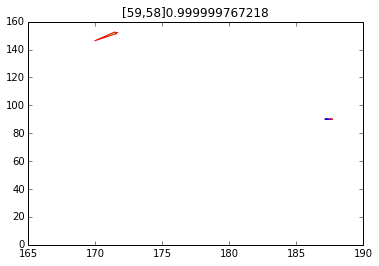

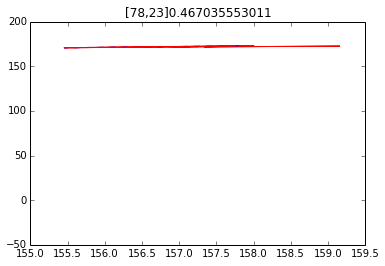

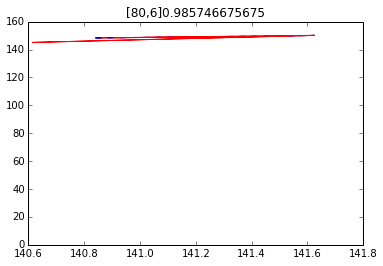

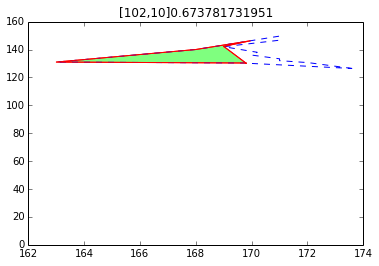

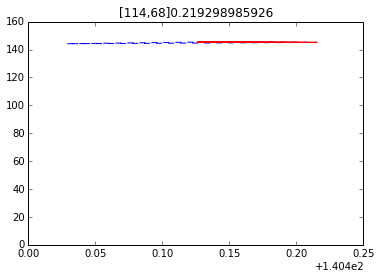

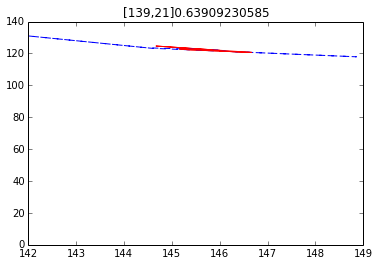

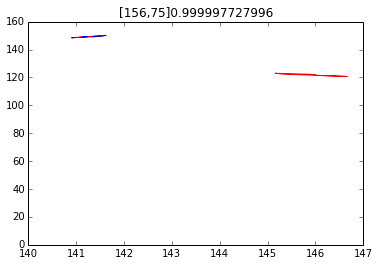

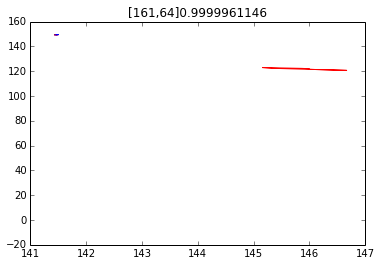

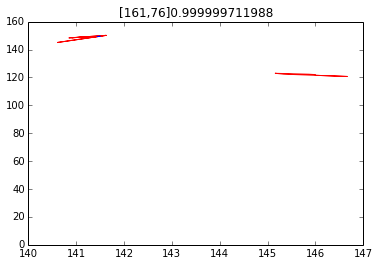

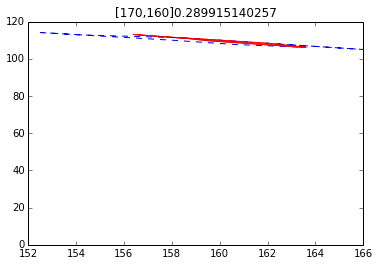

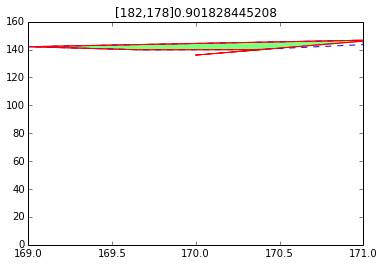

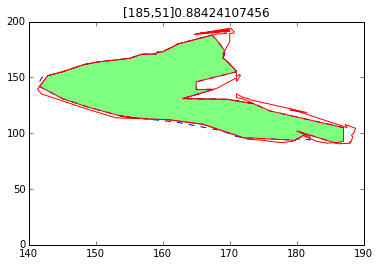

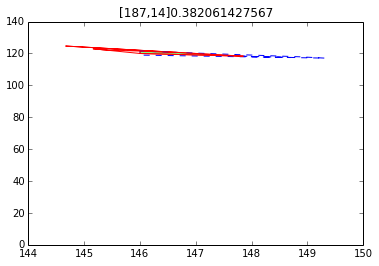

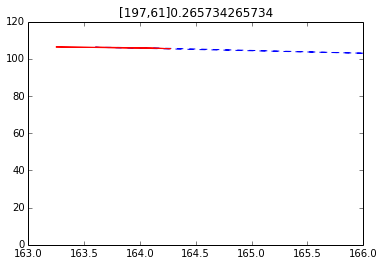

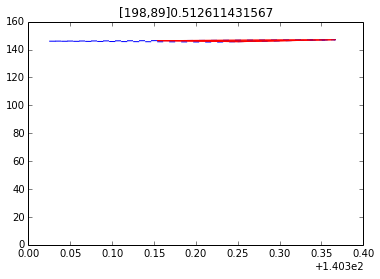

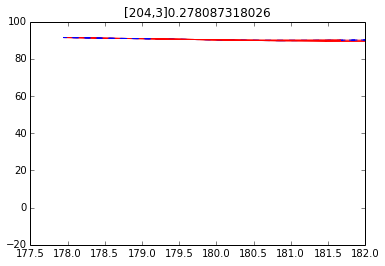

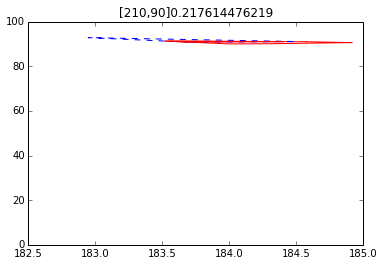

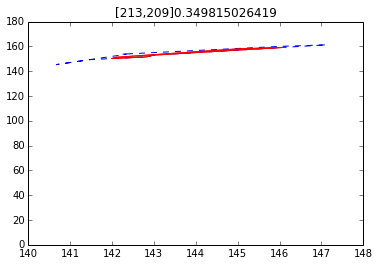

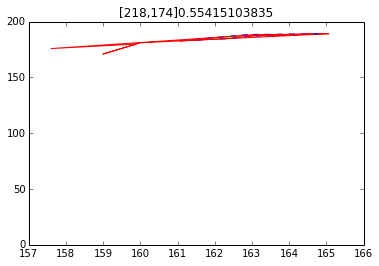

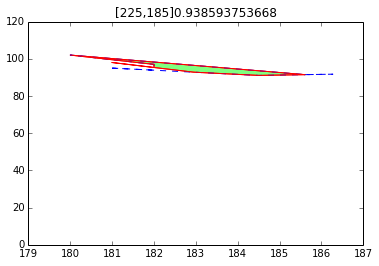

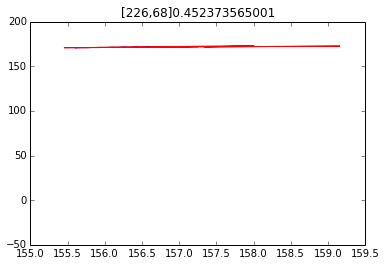

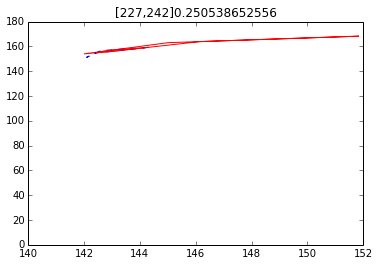

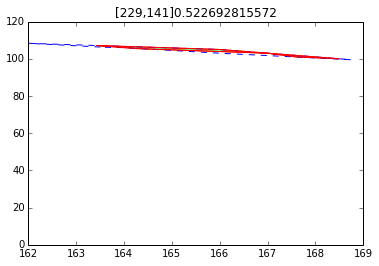

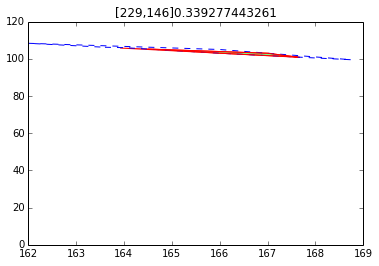

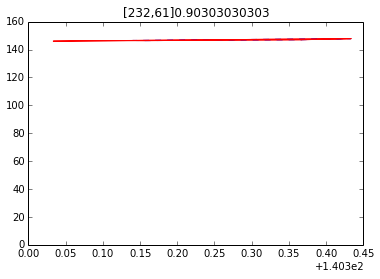

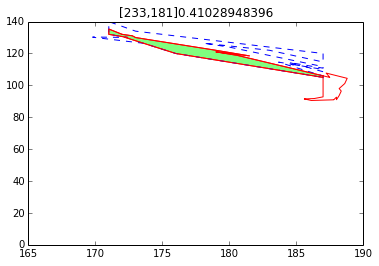

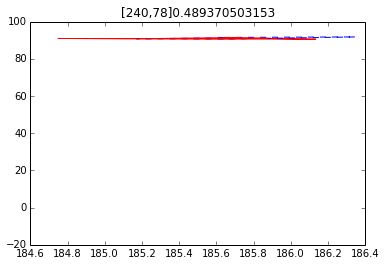

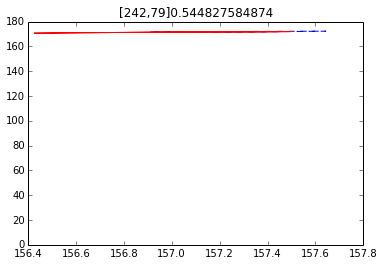

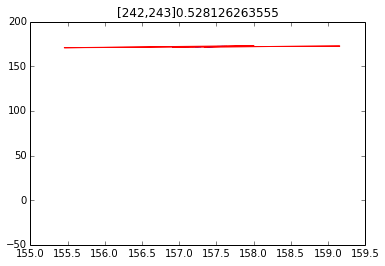

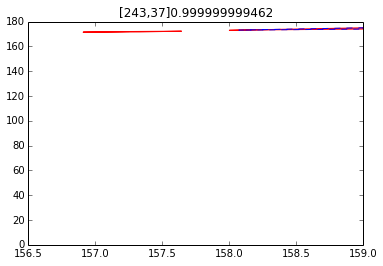

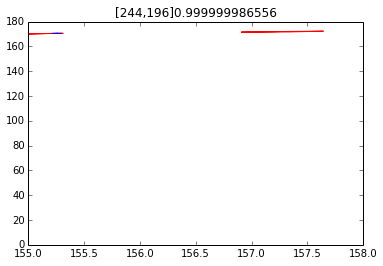

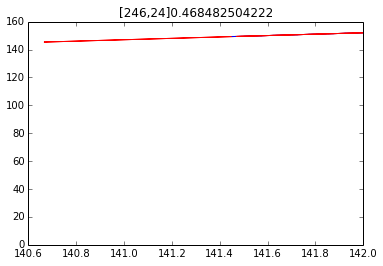

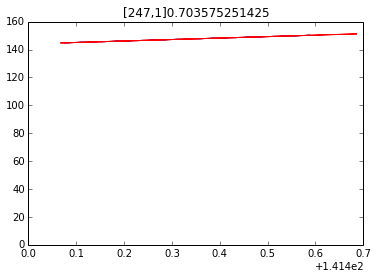

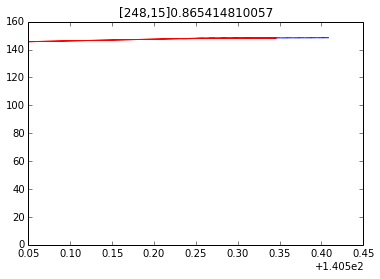

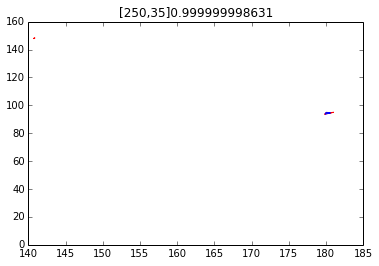

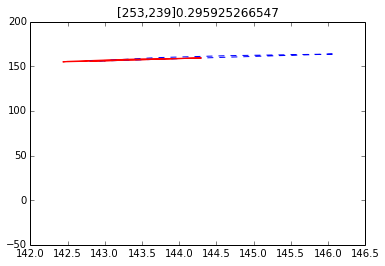

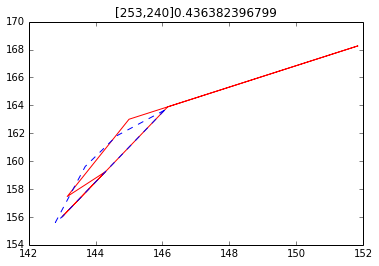

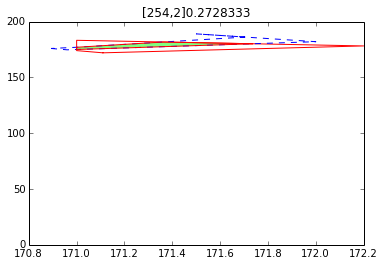

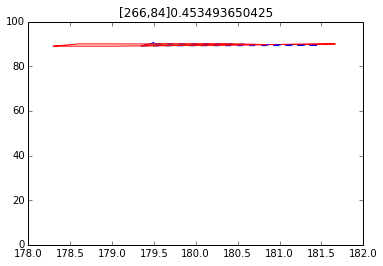

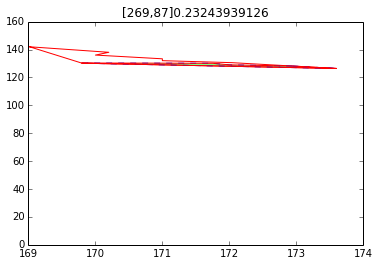

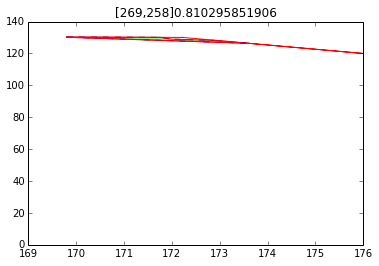

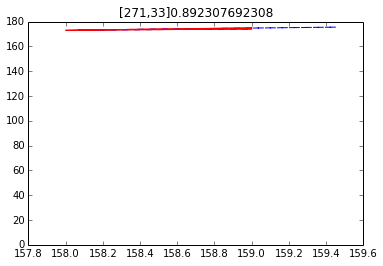

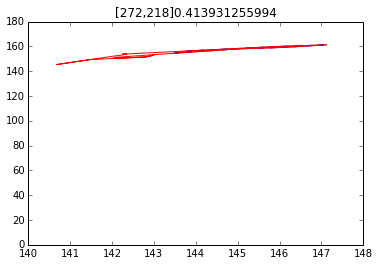

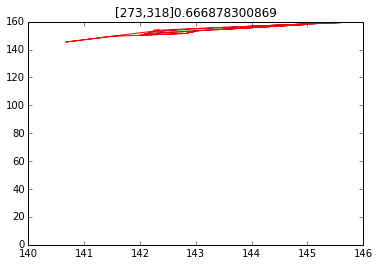

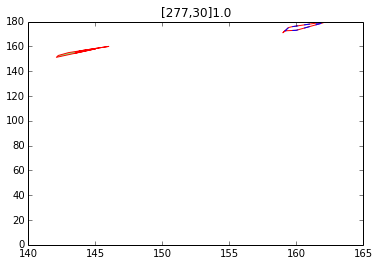

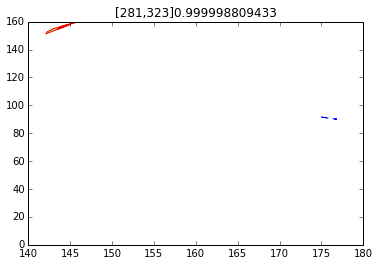

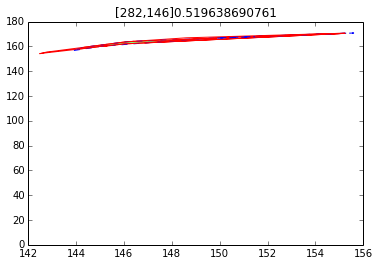

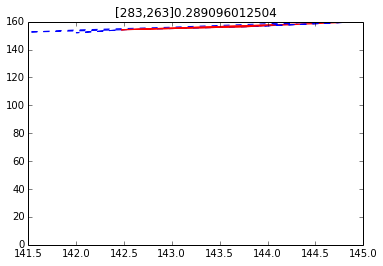

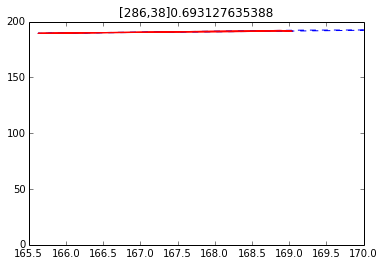

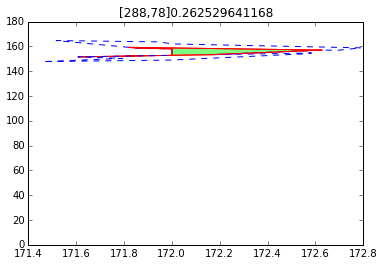

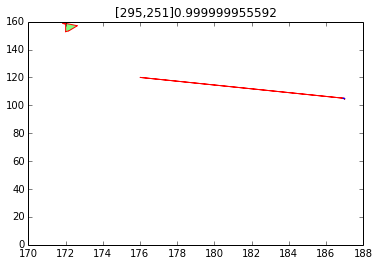

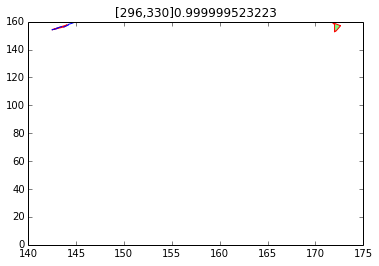

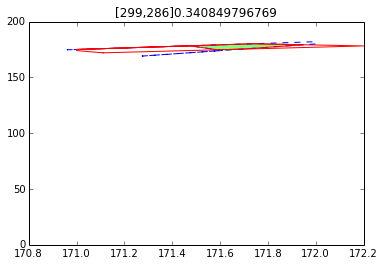

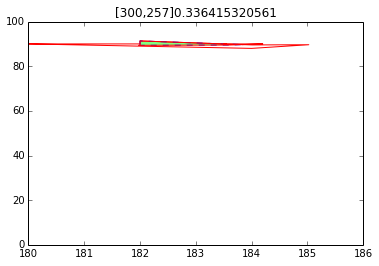

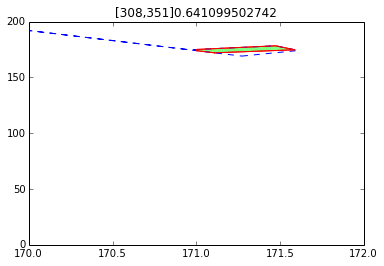

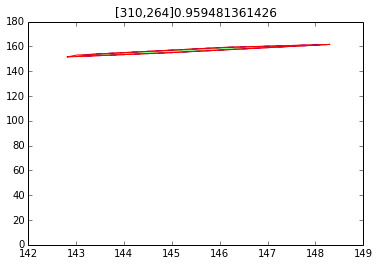

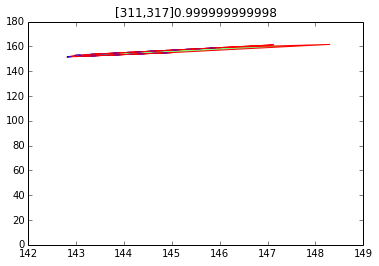

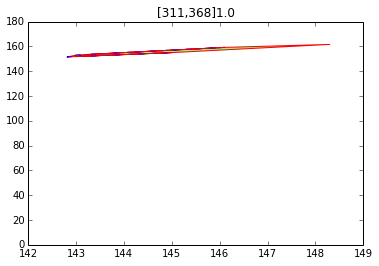

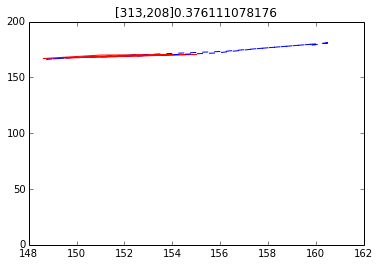

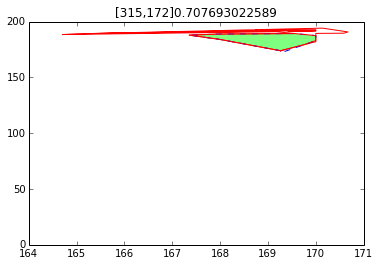

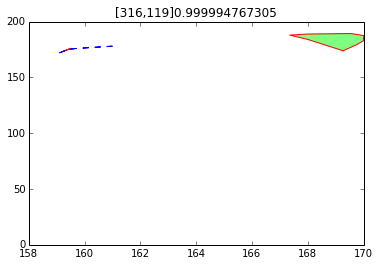

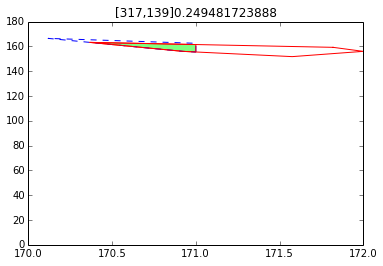

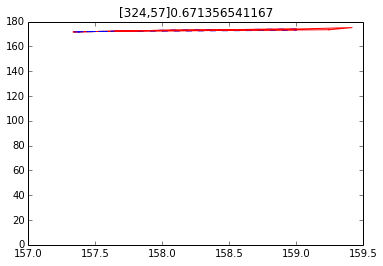

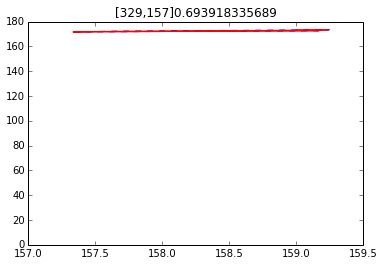

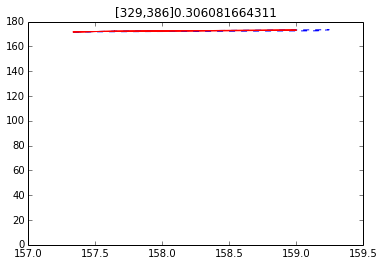

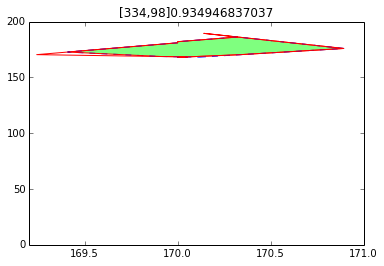

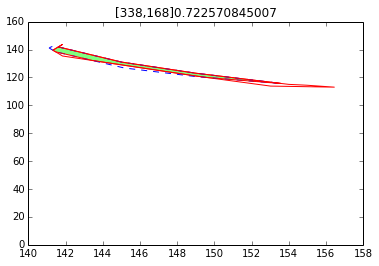

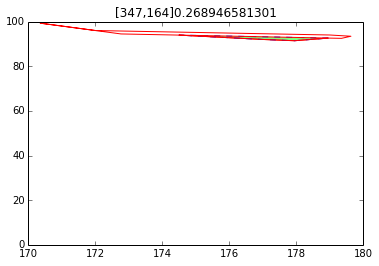

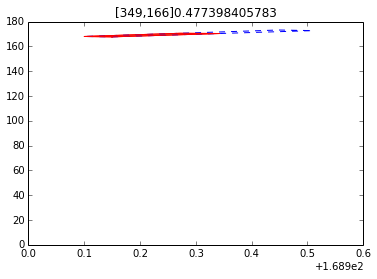

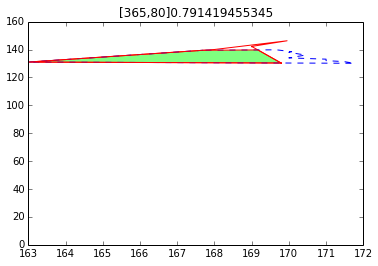

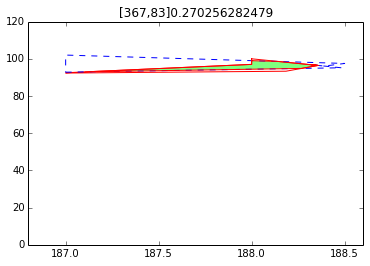

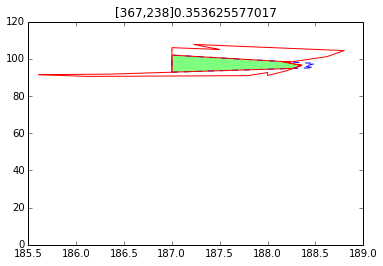

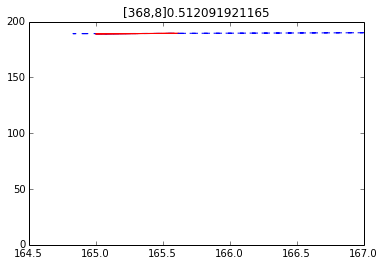

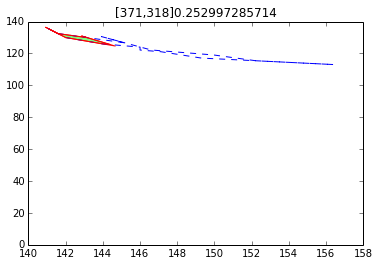

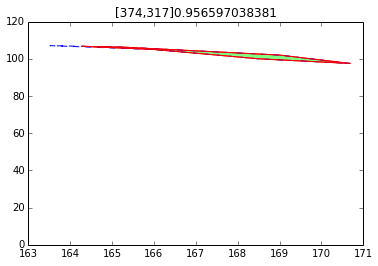

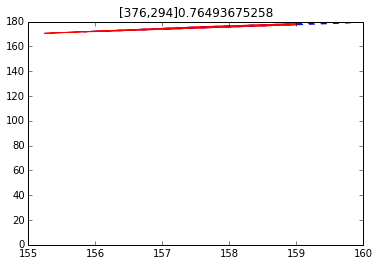

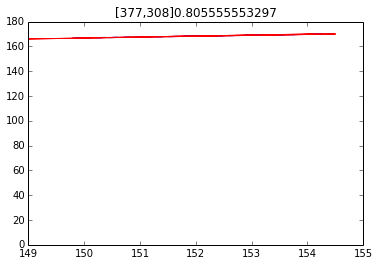

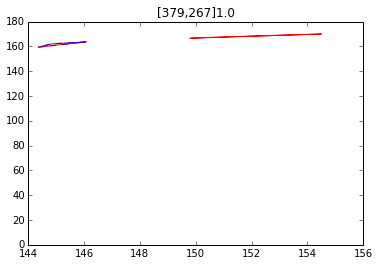

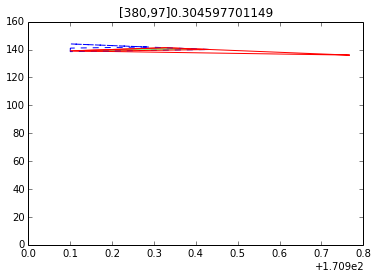

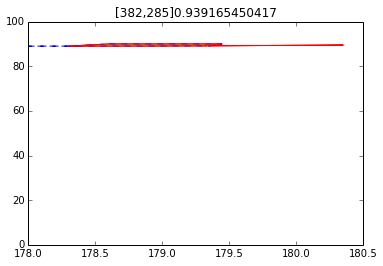

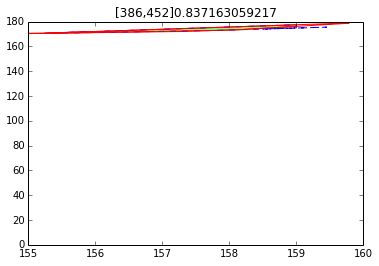

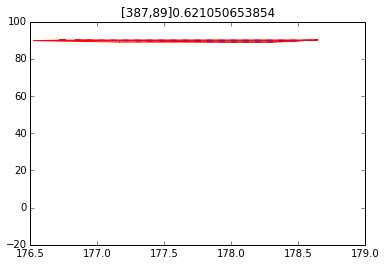

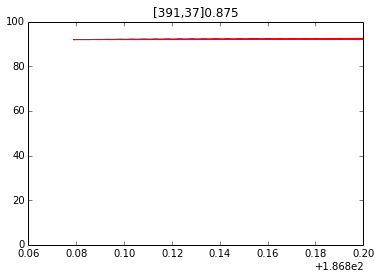

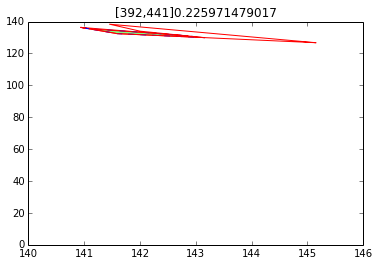

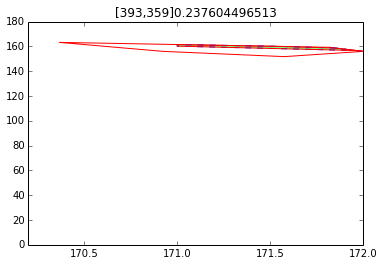

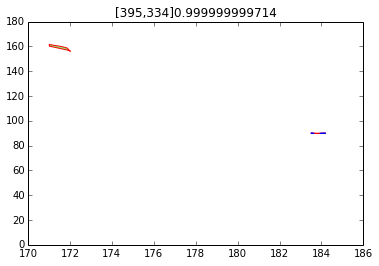

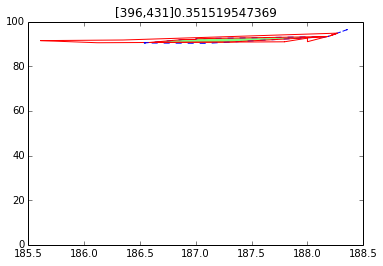

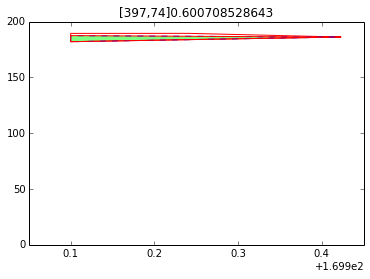

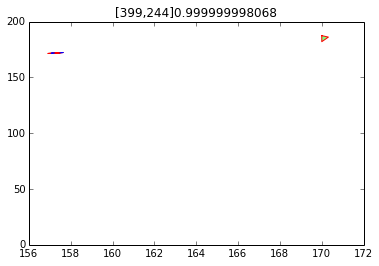

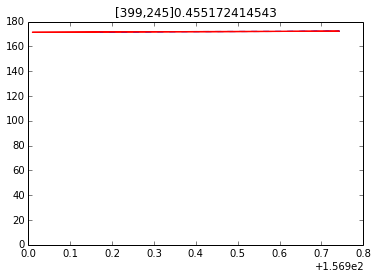

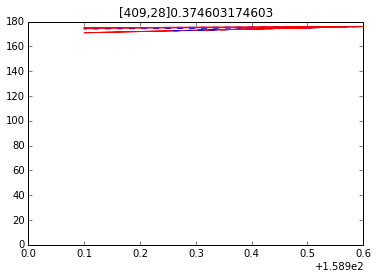

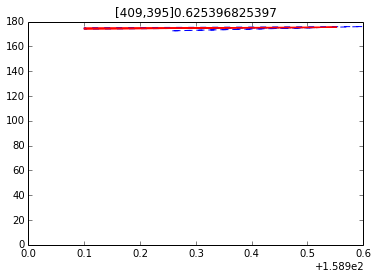

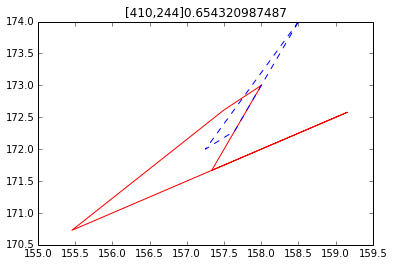

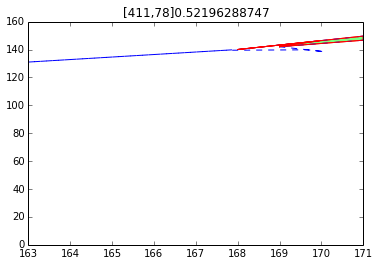

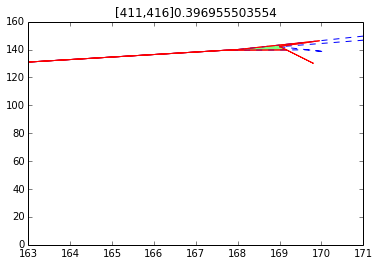

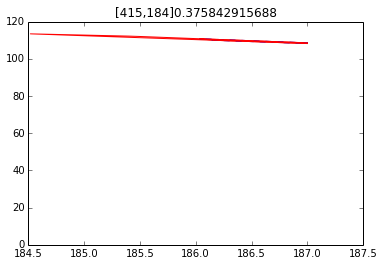

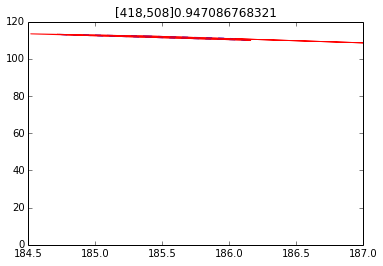

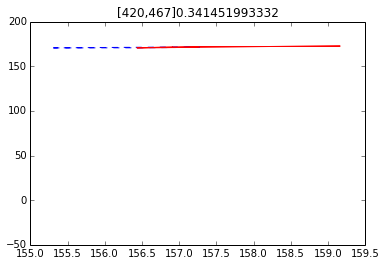

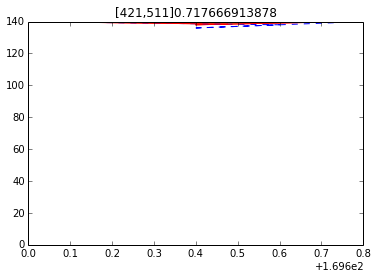

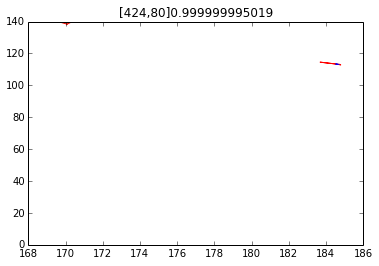

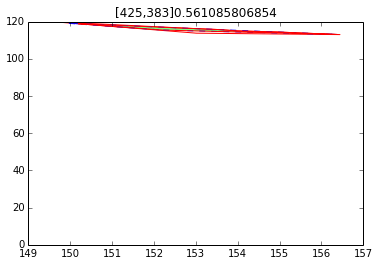

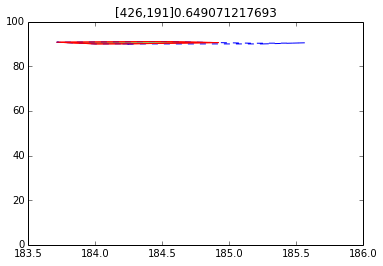

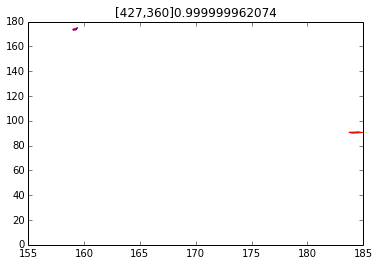

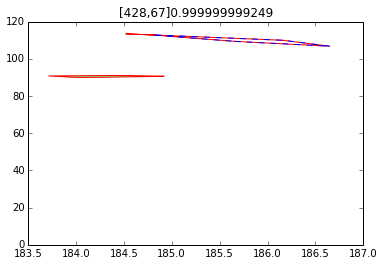

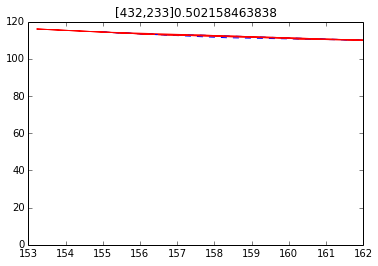

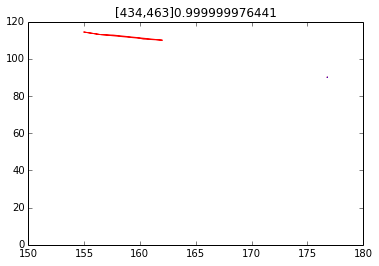

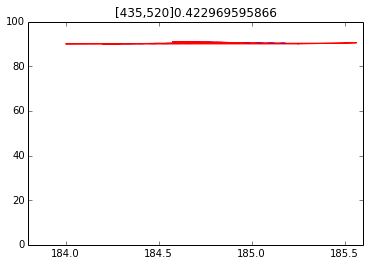

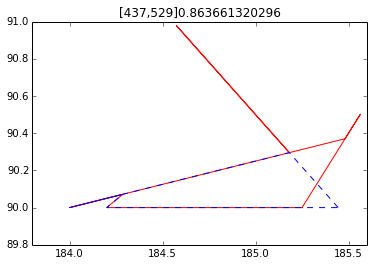

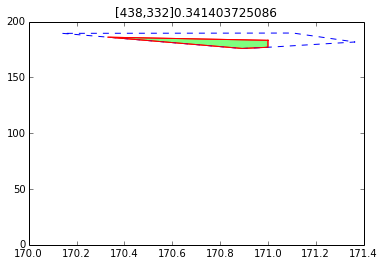

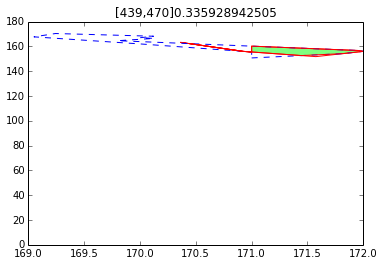

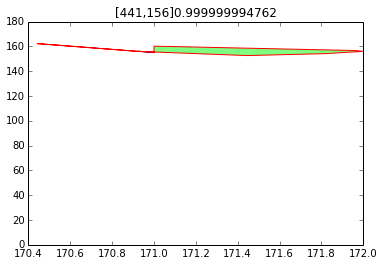

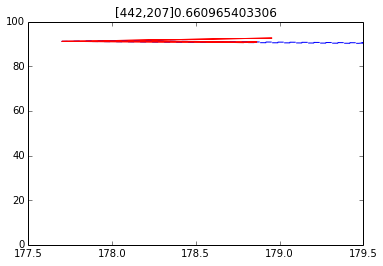

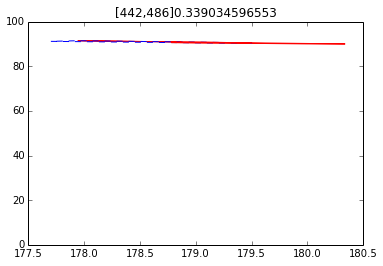

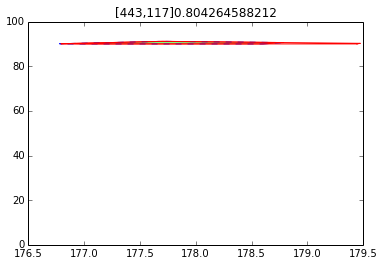

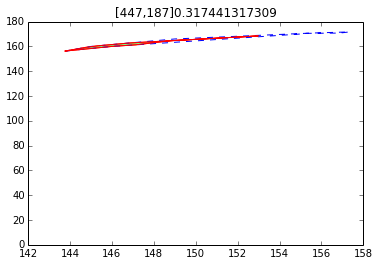

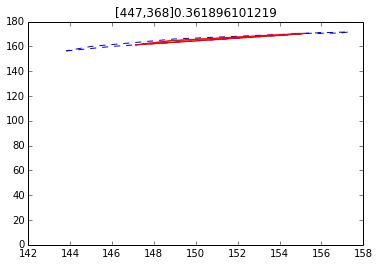

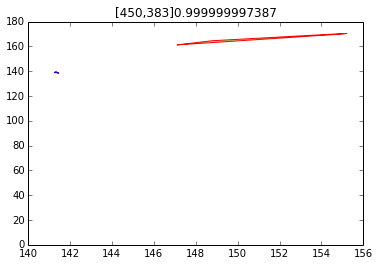

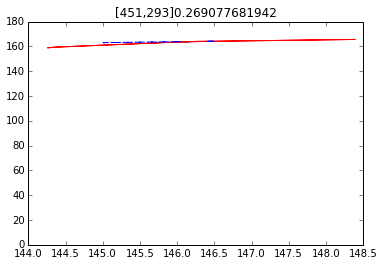

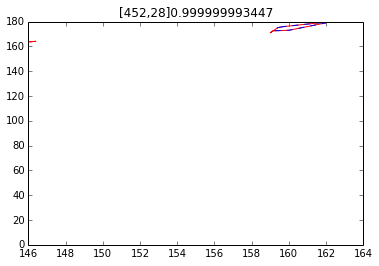

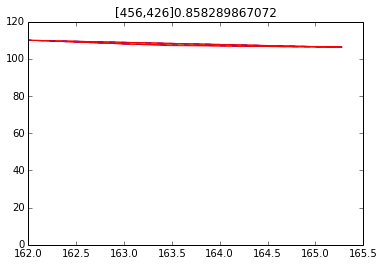

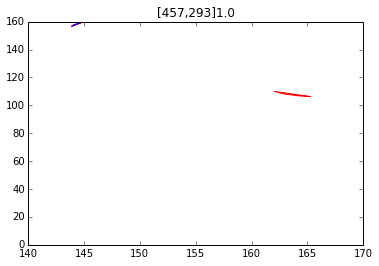

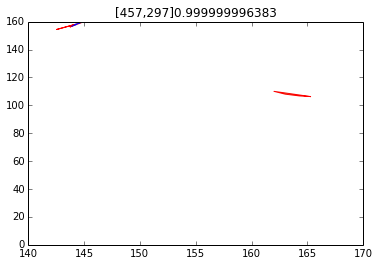

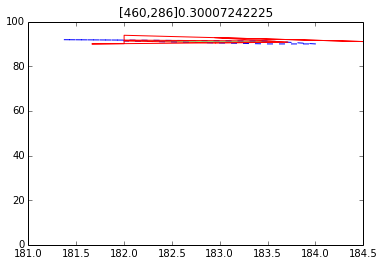

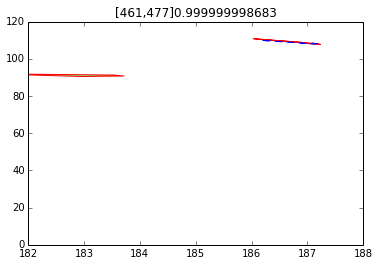

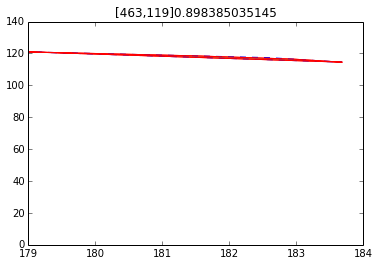

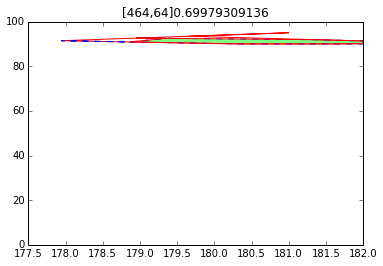

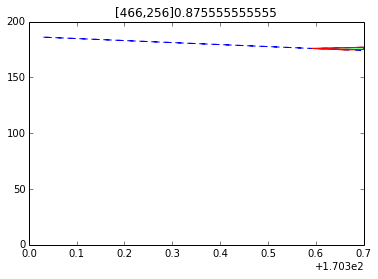

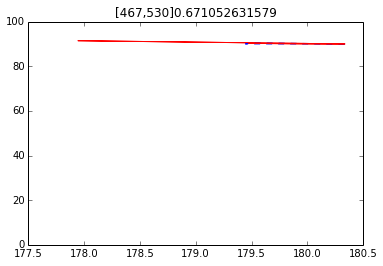

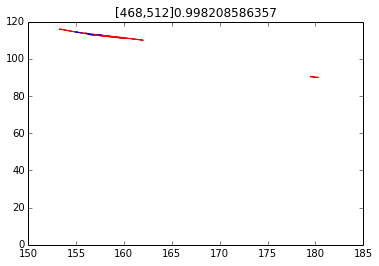

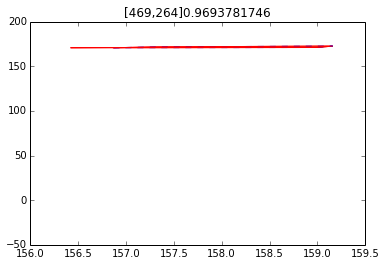

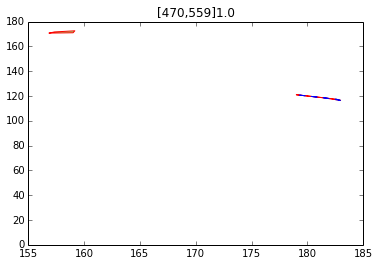

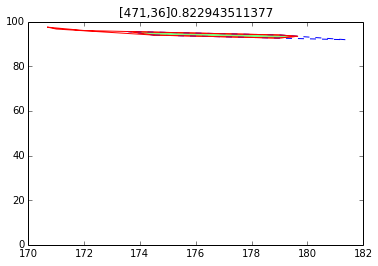

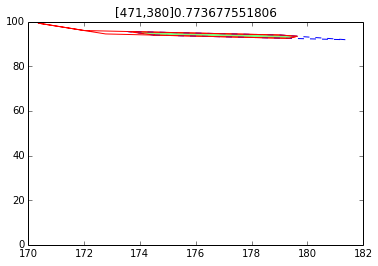

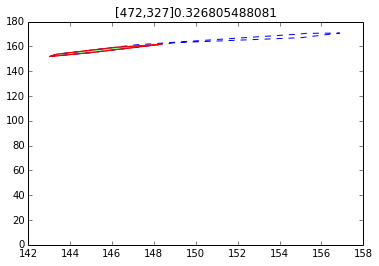

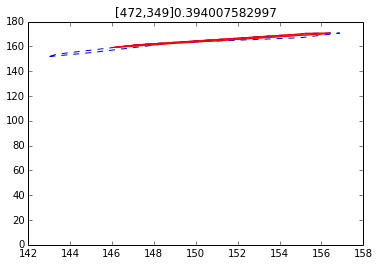

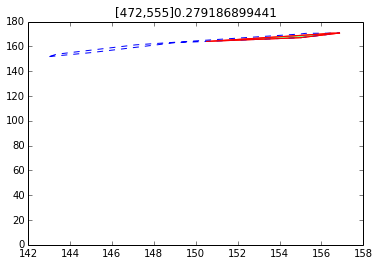

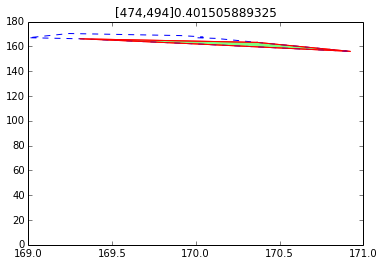

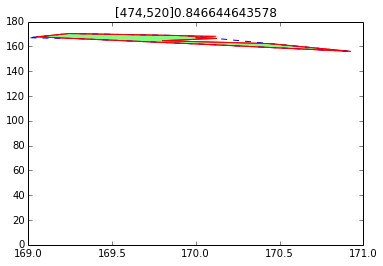

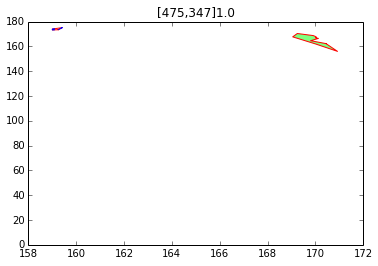

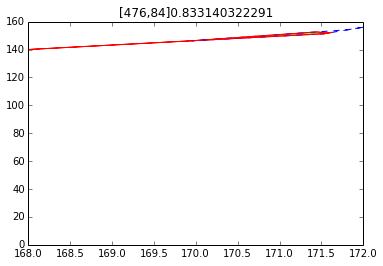

In [71]:
PLOT=True
verified_tiles = []
stop_here=False
for tidx in tqdm(range(len(tiles))): 
    #if tidx==0:
    #    verified_tiles.append(tiles[0])
    t=tiles[tidx]
    duplicated=False
    verified_tiles_new= verified_tiles[:]
    for vtidx in range(len(verified_tiles)):
    
        try:
            vt = verified_tiles[vtidx]
        except(IndexError):
            print "last element removed"
        try:
            overlap_score=overlap(vt,t)
            if overlap_score>0.2:
                print "Duplicate tiles: ",tidx,vtidx, overlap_score, vt.area, t.area
                duplicated=True
                if overlap_score<0.99:
                        #verified_tiles.pop(vtidx)
                        verified_tiles_new.remove(vt)
                        overlap_region = vt.intersection(t)
                        #verified_tiles_new.append(vt.difference(overlap_region))
                        #verified_tiles_new.append(t.difference(overlap_region))
                        add_object_to_tiles(verified_tiles_new,overlap_region)
                        add_object_to_tiles(verified_tiles_new,vt.difference(overlap_region))
                        add_object_to_tiles(verified_tiles_new,t.difference(overlap_region))
                    
                if PLOT:# and tidx==185 and vtidx==51:
                    plt.figure()
                    plt.title("[{0},{1}]{2}".format(tidx,vtidx, overlap_score))
                    
                    try:
                        plot_coords(vt)
                        plot_coords(t,linestyle='--',color="blue")
                        plot_coords(overlap_region,fill_color="lime")
                    except(AttributeError):
                        print "problem with plotting"
#                 if tidx==185 and vtidx==51:
#                     stop_here=True
#                     break
        except(shapely.geos.TopologicalError):
            print "Topological Error",tidx,vtidx
    if stop_here:
        break
    if not duplicated:
        verified_tiles_new.append(t)
    verified_tiles=verified_tiles_new[:]

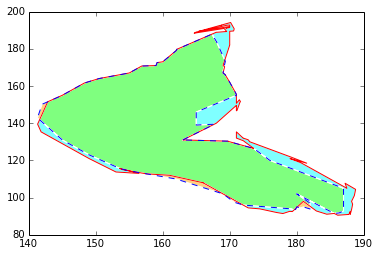

In [66]:
plt.figure()
plot_coords(overlap_region,color="white",fill_color="lime",label="overlap_region")
plot_coords(vt.difference(overlap_region),color="white",fill_color="cyan",label="vt-overlap")
plot_coords(t.difference(overlap_region),color="white",fill_color="orange",label="t-overlap")
plot_coords(vt,color="red",label="vt")
plot_coords(t,linestyle='--',color="blue",label="t")
plt.ylim(80,200)
plt.legend()

In [63]:
def plot_coords(obj,color='red',reverse_xy=False,linestyle='-',fill_color="",label=""):
    #Plot shapely polygon coord 
    if type(obj)!=shapely.geometry.MultiPolygon:
        obj=[obj]
    for ob in obj: 
        if reverse_xy:
            x,y = ob.exterior.xy
        else:
            y,x = ob.exterior.xy
        plt.plot(x, y, linestyle, color=color, zorder=1,label="")
        if fill_color!="": plt.fill_between(x, y , facecolor=fill_color,color='none', alpha=0.5)

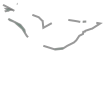

In [53]:
t.difference(overlap_region)

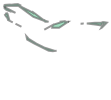

In [50]:
vt.difference(overlap_region)

(100, 200)

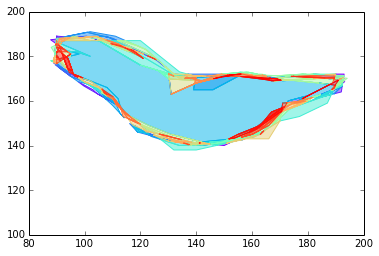

In [72]:
visualizeTilesSeparate(verified_tiles)
plt.ylim(100,200)

(100, 200)

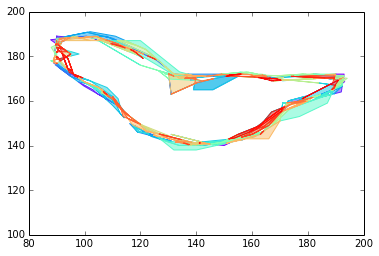

In [70]:
visualizeTilesSeparate(verified_tiles)
plt.ylim(100,200)

(100, 200)

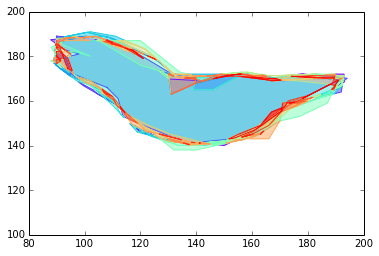

In [54]:
visualizeTilesSeparate(tiles)
plt.ylim(100,200)

(100, 200)

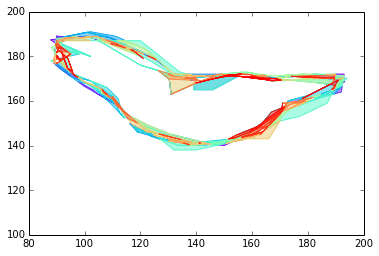

In [59]:
visualizeTilesSeparate(verified_tiles)
plt.ylim(100,200)

(100, 200)

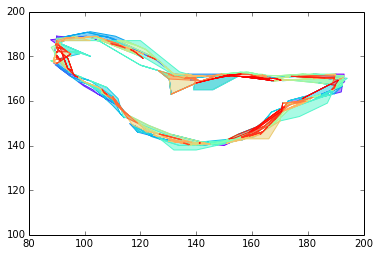

In [57]:
visualizeTilesSeparate(verified_tiles)
plt.ylim(100,200)

(100, 200)

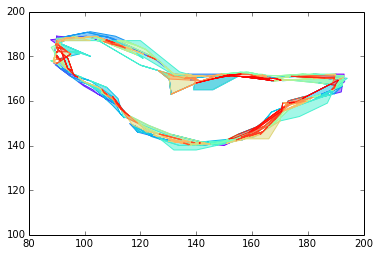

In [55]:
visualizeTilesSeparate(verified_tiles)
plt.ylim(100,200)

In [74]:
import copy
objid=17
sampleNworkers=15
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))

In [75]:
tiles = BB2TileExact(objid,BB,tqdm_on=True,save_tiles=False)

 67%|██████▋   | 10/15 [00:04<00:02,  2.33it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (108.148 187.185, 107.722 187.228) and LINESTRING (107.722 187.228, 109.966 186.159) at 107.72151898734192 187.22784810126578
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (112.157 185.431, 112.157 185.431) and LINESTRING (112.157 185.431, 112.157 185.431) at 112.15686274509807 185.43137254901958
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (101.143 188.619, 104.418 188.801) and LINESTRING (101.143 188.619, 101.542 188.641) at 101.37726005619339 188.63207000312187
 80%|████████  | 12/15 [00:11<00:02,  1.07it/s]ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 90.499999999999702 179.49999999999997 at 90.499999999999702 179.49999999999997
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (98.428

In [76]:
vtiles =compute_unique_tileset(tiles,PLOT=False)

 16%|█▌        | 76/478 [00:00<00:04, 84.69it/s] 

Duplicate tiles:  59 58 0.999999767218 0.088794542913 0.0887945222431
Duplicate tiles:  78 23 0.467035553011 1.01806526807 0.481818181818
Duplicate tiles: 

 20%|█▉        | 95/478 [00:01<00:05, 70.28it/s]

 80 6 0.985746675675 0.147393048128 0.145292272939
Duplicate tiles: 

 24%|██▍       | 114/478 [00:01<00:05, 60.80it/s]

 102 10 0.673781731951 40.0485995756 59.4377039872
Duplicate tiles:  114 68 0.219298985926 0.0174113755309 0.0793956043958
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (145.6 140.55, 145.6 140.55) and LINESTRING (145.6 140.55, 145.6 140.55) at 145.60000008309231 140.55000000692436
 28%|██▊       | 133/478 [00:02<00:06, 52.96it/s]

 129 18 0.253476689422 0.290128582468 1.14459413136
Topological Error 129 18
Duplicate tiles: 

 32%|███▏      | 152/478 [00:03<00:06, 47.49it/s]

 139 21 0.63909230585 0.55579246624 0.608872608873
Duplicate tiles:  156 75 0.999997727996 0.14529220721 0.145291892744
Duplicate tiles:  161 64 0.9999961146 0.00210084847586 0.00210084031323
Duplicate tiles:  161 76 0.999999711988 0.0021008409183 0.00210084031323
Duplicate tiles: 

 36%|███▌      | 171/478 [00:03<00:07, 42.92it/s]

 170 160 0.289915140257 3.00943284808 10.3803921569
Duplicate tiles:  182 178 0.901828445208 6.39171374765 7.07378472222
Duplicate tiles:  185 51 0.88424107456 1982.45601307 1778.75431921
Duplicate tiles: 

 40%|███▉      | 190/478 [00:05<00:07, 37.97it/s]

 187 14 0.382061427567 2.17948717949 4.39585642074
Duplicate tiles:  197 61 0.265734265734 0.153409090909 0.4
Duplicate tiles:  198 89 0.512611431567 0.111363636363 0.217247664616
Duplicate tiles: 

 44%|████▎     | 209/478 [00:06<00:07, 34.77it/s]

 204 3 0.278087318026 0.737639553591 0.205128205128
Duplicate tiles:  210 90 0.217614476219 0.93157826731 0.91805518777
Duplicate tiles:  213 209 0.349815026419 2.90806736821 8.31315737916
Duplicate tiles:  218 174 0.55415103835 5.93491517974 4.22152320028
Duplicate tiles:  225 185 0.938593753668 10.542894139 11.2326489472
Duplicate tiles:  226 68 0.452373565001 0.542592592593 0.245454545455
Duplicate tiles: 

 48%|████▊     | 228/478 [00:07<00:07, 31.59it/s]

 227 242 0.250538652556 4.65555555556 1.43010610846
Duplicate tiles:  229 141 0.522692815572 3.35319035093 6.35
Duplicate tiles:  229 146 0.339277443261 2.49572649573 6.35
Duplicate tiles:  232 61 0.90303030303 0.1 0.090303030303
Duplicate tiles:  233 181 0.41028948396 85.9653586275 154.106722917
Duplicate tiles:  240 78 0.489370503153 0.291444307545 0.420513678437
Duplicate tiles:  242 79 0.544827584874 0.0854978354978 0.156926406698
Duplicate tiles:  242 243 0.528126263555 0.297138047138 0.156926406698
Duplicate tiles:  243 37 0.999999999462 0.464285714286 0.46428571425
Duplicate tiles:  244 196 0.999999986556 0.00188467299935 0.00188467299733
Duplicate tiles: 

 52%|█████▏    | 247/478 [00:08<00:08, 28.08it/s]

 246 24 0.468482504222 3.96550931461e-07 1.86213596076e-07
Duplicate tiles:  247 1 0.703575251425 1.00050878858e-07 7.15917526556e-08
Duplicate tiles:  248 15 0.865414810057 0.0106635318704 0.0123218732545
Duplicate tiles:  250 35 0.999999998631 0.400092747278 0.400092746899
Duplicate tiles:  253 239 0.295925266547 1.16639661579 2.54214014996
Duplicate tiles:  253 240 0.436382396799 3.38179105117 2.54214014996
Duplicate tiles: 

 56%|█████▌    | 266/478 [00:10<00:08, 26.09it/s]

 254 2 0.2728333 6.96113729007 3.95552910053
Duplicate tiles:  266 84 0.453493650425 1.67820512821 1.22783148389
Duplicate tiles:  269 87 0.23243939126 15.7336758195 3.65712602977
Duplicate tiles:  269 258 0.810295851906 4.51332191948 3.65712602977
Duplicate tiles:  271 33 0.892307692308 0.464285714286 0.414285714286
Duplicate tiles:  272 218 0.413931255994 5.40509001095 2.23733569699
Duplicate tiles:  273 318 0.666878300869 3.16775431396 2.11250661446
Duplicate tiles:  277 30 1.0 6.08287683494 6.08287683494
Duplicate tiles:  281 323 0.999998809433 0.00235512610175 0.00235512890569
Duplicate tiles:  282 146 0.519638690761 11.6723757017 7.27290952775
Duplicate tiles: 

 60%|█████▉    | 285/478 [00:11<00:08, 24.08it/s]

 283 263 0.289096012504 0.98401499575 2.53939205955
Duplicate tiles:  286 38 0.693127635388 1.27510798778 1.81513157895
Duplicate tiles:  288 78 0.262529641168 2.15232205137 8.19839634404
Duplicate tiles:  295 251 0.999999955592 0.0243362842666 0.0243362831858
Duplicate tiles:  296 330 0.999999523223 0.734128118602 0.73412846744
Duplicate tiles:  299 286 0.340849796769 3.93000581398 1.7414187643
Duplicate tiles: 

 64%|██████▎   | 304/478 [00:13<00:07, 22.37it/s]

 300 257 0.336415320561 5.78566450596 1.94638617974
Duplicate tiles:  308 351 0.641099502742 1.95619236746 3.05130850843
Duplicate tiles:  310 264 0.959481361426 7.7125 7.4
Duplicate tiles:  311 317 0.999999999998 0.312500000001 0.3125
Duplicate tiles:  311 368 1.0 0.3125 0.3125
Duplicate tiles:  313 208 0.376111078176 5.37857142857 6.54949744954
Duplicate tiles:  315 172 0.707693022589 31.2894662749 22.534927353
Duplicate tiles:  316 119 0.999994767305 0.0321430253375 0.0321428571429
Duplicate tiles: 

 68%|██████▊   | 323/478 [00:15<00:07, 20.88it/s]

 317 139 0.249481723888 8.18394553601 3.28959276018
Duplicate tiles:  324 57 0.671356541167 1.05427170868 1.03571428571
Duplicate tiles:  329 157 0.693918335689 0.74343277981 1.07135485773
Duplicate tiles:  329 386 0.306081664311 0.327922077922 1.07135485773
Duplicate tiles:  334 98 0.934946837037 14.1028349834 13.2752255223
Duplicate tiles: 

 72%|███████▏  | 342/478 [00:17<00:06, 19.72it/s]

 338 168 0.722570845007 35.950609627 33.0138264106
Duplicate tiles:  347 164 0.268946581301 13.0965810717 3.522280707
Duplicate tiles: 

 76%|███████▌  | 361/478 [00:19<00:06, 18.72it/s]

 349 166 0.477398405783 0.202705627436 0.424604743083
Duplicate tiles:  365 80 0.791419455345 40.0480391357 47.089618684
Duplicate tiles:  367 83 0.270256282479 3.4936430883 8.47180695381
Duplicate tiles:  367 238 0.353625577017 22.6907846412 8.47180695381
Duplicate tiles:  368 8 0.512091921165 0.0208333333333 0.0400301349382
Duplicate tiles:  371 318 0.252997285714 4.42783094099 16.9744809552
Duplicate tiles:  374 317 0.956597038381 7.81710829493 8.17178803307
Duplicate tiles:  376 294 0.76493675258 2.22500965165 2.90874982032
Duplicate tiles:  377 308 0.805555553297 0.517857142857 0.642857143777
Duplicate tiles: 

 79%|███████▉  | 380/478 [00:21<00:05, 17.55it/s]

 379 267 1.0 1.26670394712 1.26670394712
Duplicate tiles:  380 97 0.304597701149 1.09848484848 0.641156462585
Duplicate tiles:  382 285 0.939165450417 0.917149758454 0.861461843375
Duplicate tiles:  386 452 0.837163059217 6.72330655424 6.1746031746
Duplicate tiles:  387 89 0.621050653854 1.6570753441 1.02912772594
Duplicate tiles:  391 37 0.875 0.030303030303 0.0265151571261
Duplicate tiles:  392 441 0.225971479017 9.55319297041 2.15874914559
Duplicate tiles:  393 359 0.237604496513 6.14220069548 1.45941450373
Duplicate tiles:  395 334 0.999999999714 0.105376344056 0.105376344086
Duplicate tiles:  396 431 0.351519547369 4.6541457797 1.88763209722
Duplicate tiles: 

 83%|████████▎ | 399/478 [00:24<00:04, 16.61it/s]

 397 74 0.600708528643 1.43209965438 0.860274476251
Duplicate tiles:  399 244 0.999999998068 0.0714285715336 0.0714285714286
Duplicate tiles:  399 245 0.455172414543 0.156926406595 0.0714285714286
Duplicate tiles:  409 28 0.374603174603 0.140476190476 0.375
Duplicate tiles:  409 395 0.625396825397 0.234523809524 0.375
Duplicate tiles:  410 244 0.654320987487 0.140211640543 0.214285714286
Duplicate tiles:  411 78 0.52196288747 3.65598903199 7.00430839002
Duplicate tiles:  411 416 0.396955503554 2.78039876445 7.00430839002
Duplicate tiles: 

 87%|████████▋ | 418/478 [00:26<00:03, 15.76it/s]

 415 184 0.375842915688 1.0936090219 0.41102520361
Duplicate tiles:  418 508 0.947086768321 0.682583818489 0.720719412167
Duplicate tiles:  420 467 0.341451993332 0.234326018809 0.68626343735
Duplicate tiles:  421 511 0.717666913878 0.484391378407 0.674952919021
Duplicate tiles:  424 80 0.999999995019 0.0194451646357 0.0194451645389
Duplicate tiles:  425 383 0.561085806854 8.1288572484 4.84823519541
Duplicate tiles:  426 191 0.649071217693 0.728853350612 1.12291737898
Duplicate tiles:  427 360 0.999999962074 0.346479500891 0.346479487751
Duplicate tiles:  428 67 0.999999999249 2.07705349147 2.07705349012
Duplicate tiles:  432 233 0.502158463838 2.05504274323 2.88732013058
Duplicate tiles:  434 463 0.999999976441 0.000257915500323 0.000257915506399
Duplicate tiles: 

 91%|█████████▏| 437/478 [00:29<00:02, 14.99it/s]

 435 520 0.422969595866 0.388781290666 0.164442665393
Duplicate tiles:  437 529 0.863661320296 0.224338625272 0.206238955403
Duplicate tiles:  438 332 0.341403725086 2.93266702867 8.59002645018
Duplicate tiles:  439 470 0.335928942505 4.62187457756 12.991499925
Duplicate tiles:  441 156 0.999999994762 0.01923076913 0.0192307692308
Duplicate tiles:  442 207 0.660965403306 0.367747883406 0.556379927854
Duplicate tiles:  442 486 0.339034596553 0.337754851388 0.556379927854
Duplicate tiles:  443 117 0.804264588212 1.80339131421 1.45906852739
Duplicate tiles:  447 187 0.317441317309 5.97083333333 18.7964158806
Duplicate tiles:  447 368 0.361896101219 6.80234962406 18.7964158806
Duplicate tiles:  450 383 0.999999997387 0.0687799925529 0.0687799927326
Duplicate tiles:  451 293 0.269077681942 0.0190376859964 0.0707516337837
Duplicate tiles: 

 95%|█████████▌| 456/478 [00:31<00:01, 14.29it/s]

 452 28 0.999999993447 6.08287683494 6.08287679521
Duplicate tiles:  456 426 0.858289867072 2.03356904471 1.74539170507
Duplicate tiles:  457 293 1.0 0.249886877828 0.249886877828
Duplicate tiles:  457 297 0.999999996383 0.249886877148 0.249886877828
Duplicate tiles:  460 286 0.30007242225 3.76943475395 1.58285714286
Duplicate tiles:  461 477 0.999999998683 0.0727881588641 0.0727881587682
Duplicate tiles:  463 119 0.898385035145 2.83792172574 3.15891473557
Duplicate tiles:  464 64 0.69979309136 7.99956243168 5.61887185692
Duplicate tiles:  466 256 0.875555555555 0.140714285714 0.160714285714
Duplicate tiles:  467 530 0.671052631579 0.149122807018 0.222222222222
Duplicate tiles:  468 512 0.998208586357 0.605150501855 0.606236477585
Duplicate tiles:  469 264 0.9693781746 2.37446483351 2.30175438596
Duplicate tiles:  470 559 1.0 0.320993009834 0.320993009834
Duplicate tiles:  471 36 0.822943511377 8.76977449465 8.44926900677
Duplicate tiles:  471 380 0.773677551806 9.57430036575 8.4492690

 99%|█████████▉| 475/478 [00:34<00:00, 13.64it/s]

 474 494 0.401505889325 2.86210131332 7.12841676652
Duplicate tiles:  474 520 0.846644643578 6.12633543041 7.12841676652
Duplicate tiles:  475 347 1.0 0.346479500891 0.346479500891
Duplicate tiles: 

 476 84 0.833140322291 1.28648052124 1.54413426745


In [77]:
print sum([tile.area for tile in tiles])
print len(tiles)
print sum([vtile.area for vtile in vtiles])
print len(vtiles)

5126.16877177
478
3032.82938589
588


In [107]:
print sum([tile.area for tile in tiles])
print len(tiles)
print sum([vtile.area for vtile in vtiles])
print len(vtiles)

5126.16877177
478
2977.28390756
387


(100, 200)

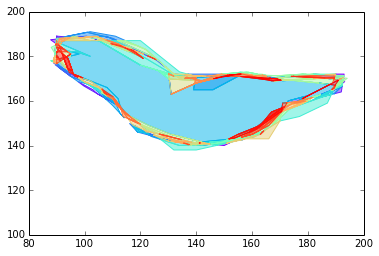

In [78]:
visualizeTilesSeparate(vtiles)
plt.ylim(100,200)

if threshold on 0.99

(100, 200)

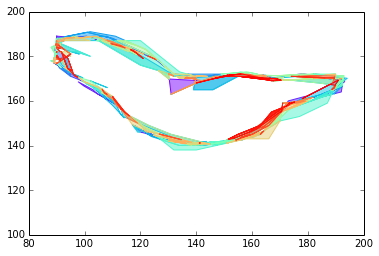

In [149]:
visualizeTilesSeparate(vtiles)
plt.ylim(100,200)

(100, 200)

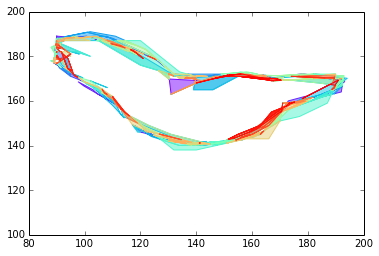

In [139]:
visualizeTilesSeparate(vtiles)
plt.ylim(100,200)

(100, 200)

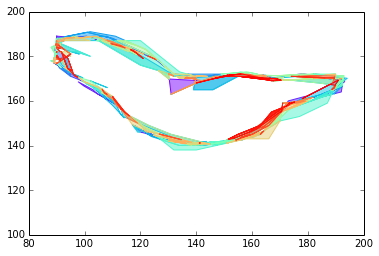

In [135]:
visualizeTilesSeparate(vtiles)
plt.ylim(100,200)

(100, 200)

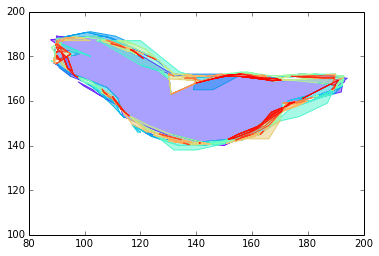

In [124]:
visualizeTilesSeparate(vtiles)
plt.ylim(100,200)

(100, 200)

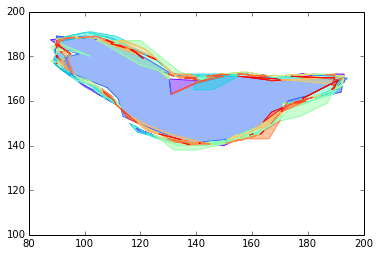

In [110]:
visualizeTilesSeparate(vtiles)
plt.ylim(100,200)

In [79]:
import copy
objid=10
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))

In [80]:
tiles = BB2TileExact(objid,BB,tqdm_on=True,save_tiles=False)

 60%|██████    | 6/10 [00:01<00:01,  3.92it/s]ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 558.80736046270886 302.86256393302551 at 558.80736046270886 302.86256393302551
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (383 246, 383.511 249.676) and LINESTRING (396.406 235.888, 383.485 249.49) at 383.48469387755102 249.48979591836735
 80%|████████  | 8/10 [00:04<00:01,  1.77it/s]ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 500.86956522672682 230.56521739489492 at 500.86956522672682 230.56521739489492
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (504.878 231.854, 505.5 232.077) and LINESTRING (505.5 232.077, 502 231) at 505.49999999999972 232.07692307692298
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (483.162 226.838, 482.564 226.804) and LINESTRING (482.06 226.775

In [81]:
vtiles =compute_unique_tileset(tiles)

 11%|█         | 38/351 [00:00<00:01, 163.49it/s]

Duplicate tiles:  25 17 1.0 0.152960526316 0.152960526316
Duplicate tiles:  32 9 0.999999999105 1.90342588446 1.90342588276
Duplicate tiles:  40 25 0.226529818455 14.2869493225 10.7755567619
Duplicate tiles:  50 18 0.999999999995 0.03125 0.0312499999999
Duplicate tiles: 

 16%|█▌        | 57/351 [00:00<00:02, 118.60it/s]

 55 42 0.54712752361 19.2575908412 34.5914313535
Duplicate tiles:  68 53 0.99999999828 0.331666666667 0.331666666096
Duplicate tiles:  69 60 0.911781297462 5.02679425837 5.51315789473
Duplicate tiles: 

 22%|██▏       | 76/351 [00:00<00:02, 94.80it/s] 

 73 61 0.840280593845 5.26757509989 4.42624113306
Duplicate tiles:  75 74 1.0 3.3 3.3
Duplicate tiles:  84 17 0.99999999766 0.152960526316 0.152960526011
Duplicate tiles: 

 27%|██▋       | 95/351 [00:01<00:03, 77.74it/s]

 87 45 0.272125762471 157.838103563 268.432086498
Duplicate tiles:  107 110 0.294945284002 1.16854283928 0.581835686778
Duplicate tiles:  108 110 0.34827518158 5.45075693344 5.72026402128
Duplicate tiles: 

 38%|███▊      | 133/351 [00:02<00:03, 56.54it/s]

 112 8 0.231382978723 0.416666666667 1.62068965517
Duplicate tiles:  112 94 0.768617021277 1.55769230769 1.62068965517
Duplicate tiles:  135 96 0.925453278291 3.20619047619 2.96717948787
Duplicate tiles:  136 3 0.215023989587 1.89146524699 0.96047384402
Duplicate tiles:  137 1 0.384877401325 5.59482758621 13.678038248
Duplicate tiles:  139 96 0.999999999681 3.52072368421 3.52072368533
Duplicate tiles:  142 78 0.999999999001 0.0234833659521 0.0234833659492
Duplicate tiles:  144 141 0.941053702196 69.0369072276 73.3612832656
Duplicate tiles: 

 43%|████▎     | 152/351 [00:03<00:04, 48.23it/s]

 147 26 0.257752985551 3.16923076841 10.9673979111
Duplicate tiles:  156 21 0.778461243531 5.89473684211 6.60628957659
Duplicate tiles:  162 157 0.432452837606 2.91383862885 6.73793388657
Duplicate tiles: 

 49%|████▊     | 171/351 [00:04<00:04, 42.68it/s]

 166 143 0.395763477293 1.48475484342 0.587611739847
Duplicate tiles:  173 8 0.297337976228 93.9578254036 56.6177352037
Duplicate tiles:  174 178 0.711396846629 14.1625757576 16.7815834188
Duplicate tiles:  175 22 0.268696025477 0.778571428571 1.96598639456
Duplicate tiles:  183 51 0.558302810815 7.89988198053 5.82151029748
Duplicate tiles:  183 162 0.242374213732 2.16463414531 5.82151029748
Duplicate tiles: 

 54%|█████▍    | 190/351 [00:05<00:04, 37.91it/s]

 188 69 0.271001349395 21.1464285682 77.3554156799
Duplicate tiles:  191 36 0.271699306036 15.4205106085 56.7557968121
Duplicate tiles:  191 183 0.857041498202 66.0205957462 56.7557968121
Duplicate tiles:  196 112 0.856525624755 0.31200265252 0.364183908046
Duplicate tiles:  203 26 0.383859351944 13.2605282468 5.09017777927
Duplicate tiles: 

 60%|█████▉    | 209/351 [00:06<00:04, 34.30it/s]

 205 190 0.776460289733 46.3939415042 50.7567708333
Duplicate tiles:  209 208 0.588631618482 12.6599664629 21.5074523104
Duplicate tiles:  216 165 0.48705077527 35.0445891184 19.4494444418
Duplicate tiles:  218 248 0.832970588158 17.9760948193 20.093774768
Duplicate tiles:  219 30 0.460094315973 11.0505292862 5.08428571356
Duplicate tiles:  221 198 0.338646712367 1.85034419975 0.626612980008
Duplicate tiles:  222 163 0.882888011115 0.516635426306 0.456131224748
Duplicate tiles:  223 258 0.999999989481 0.0605042023032 0.0605042016807
Duplicate tiles: 

 65%|██████▍   | 228/351 [00:07<00:04, 30.20it/s]

 224 238 0.653623710018 9.98545986773 12.0523795948
Duplicate tiles:  228 177 0.388420664729 28.6805055469 14.1053109031
Duplicate tiles:  234 114 0.462964562186 0.818796992481 0.379073991143
Duplicate tiles:  235 243 0.359147062296 13.0058590188 4.67101605922
Duplicate tiles: 

 70%|███████   | 247/351 [00:08<00:03, 27.83it/s]

 238 79 0.582441558275 0.893493975863 0.520408023613
Duplicate tiles:  253 186 0.528987957829 1.21733004579 1.70998994392
Duplicate tiles:  254 185 0.755102560126 12.653024325 16.7566963657
Duplicate tiles:  258 255 0.568760036967 4.1746585295 3.44119850187
Duplicate tiles:  259 255 0.658954795711 0.736842105263 0.485545638945
Duplicate tiles:  262 256 0.999999999146 5.21914807415 5.21914807465
Duplicate tiles:  263 141 0.538780503066 4.69122203818 5.12867737146
Duplicate tiles:  264 250 0.999999989481 0.0605042023032 0.0605042016807
Duplicate tiles: 

 76%|███████▌  | 266/351 [00:10<00:03, 25.51it/s]

 265 213 0.762143689312 2.69432358184 3.53519109274
Duplicate tiles:  266 182 0.319155951206 5.14285714286 16.1139315224
Duplicate tiles:  268 164 0.22553330244 7.82352941176 2.18634142497
Duplicate tiles:  270 257 0.999999999788 1.13667953668 1.13667953692
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (483.162 226.838, 482.564 226.804) and LINESTRING (482.06 226.775, 483.785 226.873) at 482.70469598005894 226.81169691314622


 272 40 0.305325754906 23.6200854085 77.3602784208
Duplicate tiles:  272 139 0.40264664642 192.129449254 77.3602784208
Topological Error 272 189
Duplicate tiles:  272 233 0.267518276258 27.5675924984 77.3602784208
Duplicate tiles:  273 238 0.391057860365 5.08428571307 1.98824989303
Duplicate tiles:  274 233 0.860189931141 16.7375233868 19.4579392072
Duplicate tiles:  275 259 0.87948221557 8.33484295942 9.47698863636
Duplicate tiles:  276 172 0.999999999998 2.22421023204 2.22421023204
Duplicate tiles:  277 275 0.980785296575 1.75901710799 1.79347826087
Duplicate tiles:  279 216 0.397107446611 9.39180059407 8.7333312231
Duplicate tiles:  280 120 0.435104013642 9.49933545984 21.8021973466
Duplicate tiles:  280 289 0.51250266351 11.1736842105 21.8021973466
Duplicate tiles:  282 83 0.999999999999 12.2583131928 12.2583131928
Duplicate tiles: 

 81%|████████  | 285/351 [00:12<00:02, 23.23it/s]

 284 171 0.716896573682 2.22421023204 2.93967946621
Duplicate tiles:  285 192 0.474927752815 12.4193075085 21.3147061823
Duplicate tiles:  287 198 0.619579939858 4.89366582006 7.89836065574
Duplicate tiles:  288 249 0.713956410823 0.31905951817 0.446889352534
Duplicate tiles:  292 329 0.999999999589 1.23783714762 1.23783714717
Duplicate tiles:  293 90 0.551247148547 7.37844611439 13.2245109321
Duplicate tiles:  295 243 0.225621354665 17.5404045168 72.4429196613
Duplicate tiles:  300 121 0.847219310949 34.9871226947 37.4174688057
Duplicate tiles: 

 87%|████████▋ | 304/351 [00:13<00:02, 21.72it/s]

 301 163 0.975379876024 202.819710112 197.82626372
Duplicate tiles:  304 174 0.897805934667 12.5465702938 13.974701892
Duplicate tiles:  306 147 0.83862835113 7.14516129032 5.99213483146
Duplicate tiles:  309 231 0.999999998366 0.456131224003 0.456131224748
Duplicate tiles:  311 290 1.0 5.88240857503 5.88240857503
Duplicate tiles:  312 5 0.528009812301 33.08635762 17.4699214773
Duplicate tiles:  313 220 0.877582614141 17.0684942991 19.4494444444
Duplicate tiles:  316 151 0.870672812756 1.46354917724 1.6809404816
Duplicate tiles: 

 92%|█████████▏| 323/351 [00:15<00:01, 20.30it/s]

 322 193 0.244328462887 0.233517241379 0.955465587044
Duplicate tiles:  322 255 0.200526990457 0.191596638655 0.955465587044
Duplicate tiles:  323 361 0.999999999877 17.4699214766 17.4699214786
Duplicate tiles:  324 241 0.581697097805 0.439723001338 0.255785593717
Duplicate tiles:  326 370 0.863689018872 24.2875223185 28.1206797676
Duplicate tiles:  328 362 0.822388219873 17.0684942991 14.0369286439
Duplicate tiles:  330 368 0.639246928017 3.58828879059 5.61330627231
Duplicate tiles:  331 19 0.709067998337 75.7418109177 53.7060942579
Duplicate tiles:  333 172 0.822378239443 3.4893556657 4.24300583155
Duplicate tiles:  334 306 0.850983468491 5.66224664108 6.62098790099
Duplicate tiles:  335 364 0.926427312838 14269.4200077 15390.9172948
Duplicate tiles:  338 375 0.889334007416 3.83315744912 4.31014378979
Duplicate tiles:  339 67 0.893442622496 2.46153846246 2.19924337957
Duplicate tiles: 

 97%|█████████▋| 342/351 [00:18<00:00, 18.98it/s]

 341 60 0.85241593167 66.8291535632 74.9101722007
Duplicate tiles:  343 66 0.999999999866 19.8914728682 19.8914728655
Duplicate tiles:  343 393 0.994406534248 20.0033609801 19.8914728655
Duplicate tiles:  344 193 0.226949055784 2.24146341463 0.969531198568
Duplicate tiles:  345 365 0.71013481304 0.72201814882 0.512730223124
Duplicate tiles:  345 367 0.671227995594 0.763868948389 0.512730223124
Duplicate tiles:  346 353 0.678780014171 22.9259671553 15.5616883117
Duplicate tiles:  347 352 0.999999999037 1.608391607 1.60839160839
Duplicate tiles: 

 349 19 1.0 0.0912633563796 0.0912633563796


In [82]:
plot_tile_duplicate_heatmap(objid,tiles)

NameError: name 'plot_tile_duplicate_heatmap' is not defined

In [84]:
print sum([tile.area for tile in tiles])
print len(tiles)
print sum([vtile.area for vtile in vtiles])
print len(vtiles)

34887.1904909
351
5317.51316995
417


In [85]:
argmax([vtile.area for vtile in vtiles])

388

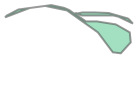

In [89]:
vtiles[388]

In [101]:
print sum([tile.area for tile in tiles])
print len(tiles)
print sum([vtile.area for vtile in vtiles])
print len(vtiles)

34887.1904909
351
33403.9085009
277


(200, 350)

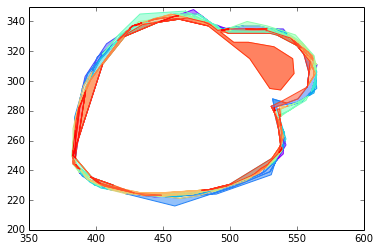

In [83]:
visualizeTilesSeparate(vtiles)
plt.ylim(200,350)

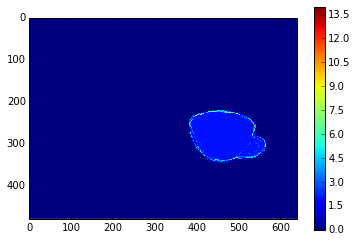

In [90]:
plot_tile_duplicate_heatmap(objid,vtiles)

In [90]:
objid=15
tiles = pkl.load(open("output/tiles{}.pkl".format(objid)))
vtiles =compute_unique_tileset(tiles)

  2%|▏         | 38/1590 [00:00<00:10, 149.38it/s]

Duplicate tiles:  37 29 0.250543645775 0.722150370851 0.18093018671
Duplicate tiles: 

  6%|▌         | 95/1590 [00:01<00:19, 77.28it/s]

 52 52 0.622370739181 0.260069022055 0.417868331017
Duplicate tiles:  96 88 0.397365697035 3.69614863525 1.64988296587
Duplicate tiles: 

  7%|▋         | 114/1590 [00:01<00:23, 63.54it/s]

 106 79 0.310523975718 0.140366476743 0.323755947829
Duplicate tiles:  127 1 0.230748148368 0.115516062884 0.375
Duplicate tiles:  129 75 0.555555555555 0.110266915248 0.125
Duplicate tiles:  129 135 0.286273388177 0.0357841735221 0.125
Duplicate tiles: 

  8%|▊         | 133/1590 [00:02<00:26, 54.57it/s]

 130 77 0.314009661836 0.242307692308 0.0760869565217
Duplicate tiles:  143 151 0.748963651897 0.237031567735 0.316479400749
Duplicate tiles: 

 10%|▉         | 152/1590 [00:03<00:29, 48.12it/s]

 148 153 0.538461538462 0.0704649079954 0.125
Duplicate tiles:  149 80 0.893607728674 0.191819669236 0.21465757634
Duplicate tiles:  163 173 0.837646561963 0.374386189511 0.35241006515
Duplicate tiles: 

 11%|█         | 171/1590 [00:03<00:33, 42.90it/s]

 170 133 0.2813159687 0.0408224708035 0.0114840129188
Duplicate tiles:  171 109 0.21292545513 0.0187411216461 0.0812402640754
Duplicate tiles:  178 185 0.982986901433 0.0514957580606 0.0523870236577
Duplicate tiles:  179 190 0.352398514007 0.0146678236669 0.0416228296834
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (399.271 49.2373, 399.277 49.234) and LINESTRING (399.277 49.234, 399.277 49.234) at 399.27659574468083 49.2340425531915


 183 130 0.346216748725 0.288469444362 0.0998729531338
Topological Error 183 134
Duplicate tiles: 

 12%|█▏        | 190/1590 [00:04<00:36, 38.07it/s]

 185 59 0.621102806325 1.24838582591 0.77537593985
Duplicate tiles:  191 115 0.999999999999 0.0700972862263 0.0700972862263
Duplicate tiles:  195 118 0.621620418329 0.95 1.52491237211
Duplicate tiles: 

 13%|█▎        | 209/1590 [00:06<00:40, 34.49it/s]

 207 79 0.253306658142 20.1038317851 5.09243444534
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (398.471 49.1765, 399.277 49.234) and LINESTRING (399.277 49.234, 399.25 49.25) at 399.27659574468083 49.234042553191493


 211 39 0.722788201 1.37892419621 1.16650178893
Topological Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (401.129 48.1224, 400.871 48.2774) and LINESTRING (401.291 48.0253, 400.87 48.2781) at 400.98462617960803 48.209224292235177
 14%|█▍        | 228/1590 [00:07<00:42, 31.82it/s]

 226 61
Topological Error 226 129
Duplicate tiles:  239 90 0.270427391536 1.00427807487 3.71366993988
Duplicate tiles: 

 16%|█▌        | 247/1590 [00:08<00:45, 29.58it/s]

 241 155 0.469383418721 0.540648735346 0.47799259278
Duplicate tiles:  261 57 1.0 0.177536231884 0.177536231884
Duplicate tiles: 

 17%|█▋        | 266/1590 [00:09<00:48, 27.51it/s]

 264 238 0.503611535047 0.0024892576678 0.00335995522338
Duplicate tiles:  275 208 0.294424330026 0.577976667589 0.170729084522
Duplicate tiles: 

 18%|█▊        | 285/1590 [00:11<00:51, 25.54it/s]

 277 170 0.226059489339 0.0822605363985 0.363888888889
Duplicate tiles:  291 186 0.999999959375 0.0269550063542 0.0269550074492
Duplicate tiles: 

 19%|█▉        | 304/1590 [00:12<00:53, 24.01it/s]

 292 264 0.999999999857 0.000720180045011 0.000720180045114
Duplicate tiles:  306 143 1.0 0.00898292501856 0.00898292501856
Duplicate tiles:  312 107 0.671653660586 1.33300141208 0.89531527799
Duplicate tiles:  314 309 0.227576426148 0.492793872794 0.119667065391
Duplicate tiles:  315 327 0.715488215488 0.080808080808 0.1
Duplicate tiles:  318 186 0.999999999999 0.296851574213 0.296851574213
Duplicate tiles:  318 204 0.382654549422 0.576995705444 0.296851574213
Duplicate tiles: 

 20%|██        | 323/1590 [00:14<00:56, 22.52it/s]

 322 185 0.999999960905 0.0269550063542 0.026955007408
Duplicate tiles:  323 197 0.93006993007 0.0916666666667 0.0852564102564
Duplicate tiles: 

 22%|██▏       | 342/1590 [00:15<00:58, 21.40it/s]

 328 113 0.807249763625 0.197767145136 0.159647481164
Duplicate tiles:  354 110 0.409895097127 0.745554569654 0.305599162742
Duplicate tiles:  356 350 0.517869395119 0.968208901178 0.857742171829
Duplicate tiles: 

 23%|██▎       | 361/1590 [00:17<01:00, 20.33it/s]

 357 306 1.0 0.0323247557909 0.0323247557909
Duplicate tiles:  361 257 0.999999999997 0.00155622561699 0.00155622561699
Duplicate tiles:  366 345 0.876158475266 0.0987055016181 0.0864816617981
Duplicate tiles:  367 162 0.226873845302 0.0607828850209 0.028869047619
Duplicate tiles:  368 246 0.357412719251 0.9476410711 0.959511490378
Duplicate tiles:  368 260 0.628995714712 0.698928307212 0.959511490378
Duplicate tiles:  370 306 0.292378219335 0.453995157385 1.16052631579
Duplicate tiles: 

 24%|██▍       | 380/1590 [00:19<01:02, 19.31it/s]

 375 30 0.380784780882 0.0704143726456 0.0387174833636
Duplicate tiles:  388 238 0.338772453541 0.00615887380594 0.00208645679029
Duplicate tiles: 

 25%|██▌       | 399/1590 [00:21<01:04, 18.43it/s]

 392 293 0.264830810519 0.256028368794 0.0678042004236
Duplicate tiles:  403 365 0.983810215109 0.439955406912 0.432832623512
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (393.282 53.8462, 396.667 50.8) and LINESTRING (396.636 50.8182, 396.667 50.8) at 396.66666666666669 50.800000000000011


 409 402 0.232276712058 0.630213153417 2.71289650895
Topological Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (396.686 50.2907, 397.667 49.6667) and LINESTRING (397 50, 397.667 49.6667) at 397.66666666666652 49.666666666666735


 410 33
Topological Error 410 49
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: no outgoing dirEdge found at 396.65116279069775 50.813953488372086


 410 402 0.262065394397 0.256440253356 0.978535353535
Topological Error 410 438
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (398 50, 399.043 49.2174) and LINESTRING (398 50, 399.277 49.234) at 398.00000000000023 49.999999999999829


 412 439 1.0 0.12527100271 0.12527100271
Topological Error

 26%|██▋       | 418/1590 [00:23<01:06, 17.52it/s]

 413 441
Duplicate tiles:  414 129 0.251034089098 2.14103535354 8.27208950362
Duplicate tiles:  427 316 0.523996595193 0.437686134091 0.229346044027
Duplicate tiles:  432 218 0.679743135767 0.430579143929 0.314893612498
Duplicate tiles:  433 403 0.500722866343 0.578509500339 0.289672935217
Duplicate tiles: 

 27%|██▋       | 437/1590 [00:26<01:08, 16.74it/s]

 434 402 0.375682992231 0.408152597909 0.153335989269
Duplicate tiles:  438 337 0.24320602339 0.361785788837 1.4875691942
Duplicate tiles:  448 269 0.349728824259 0.177828629901 0.508475760548
Duplicate tiles: 

 30%|██▉       | 475/1590 [00:30<01:12, 15.47it/s]

 452 313 0.493764445053 0.89531527799 0.570641076944
Duplicate tiles:  477 28 0.438777980296 0.0540594480806 0.0722987322987
Duplicate tiles:  480 79 0.285469144127 0.314236749885 0.0897048960991
Duplicate tiles:  481 464 0.467574692586 0.25481660864 0.224943252046
Duplicate tiles:  485 451 0.890296994194 0.208340090064 0.234011898751
Duplicate tiles:  487 424 1.0 0.105263157895 0.105263157895
Duplicate tiles:  489 80 0.588897965228 0.844392530058 0.643981300039
Duplicate tiles: 

 31%|███       | 494/1590 [00:33<01:13, 14.88it/s]

 491 397 0.795111727799 1.93362794613 2.40433504352
Duplicate tiles:  497 503 0.999999992315 0.156088204105 0.156088205092
Duplicate tiles:  503 406 0.825780553807 0.0419183818943 0.0346153846154
Duplicate tiles:  506 540 0.471176734104 0.012042917385 0.0255592360856
Duplicate tiles: 

 32%|███▏      | 513/1590 [00:35<01:15, 14.31it/s]

 508 491 0.247017543926 0.284090909091 0.0701754386154
Duplicate tiles:  519 400 0.868508999842 0.00407241701565 0.00440083725798
Duplicate tiles:  520 531 0.899735615873 0.452694235589 0.503141395928
Duplicate tiles: 

 33%|███▎      | 532/1590 [00:38<01:16, 13.75it/s]

 525 420 1.0 0.105263157895 0.105263157895
Duplicate tiles:  532 393 0.377737274428 0.178350563876 0.0673696558911
Duplicate tiles:  535 539 0.454458471272 1.06748954355 1.72779464518
Duplicate tiles:  538 547 0.663675209041 0.749173132261 0.983682983683
Duplicate tiles:  539 538 0.433333333333 0.307692307692 0.133333333333
Duplicate tiles:  541 486 0.659276453698 0.0386789091543 0.0505857934493
Duplicate tiles:  541 512 0.372856864889 0.135670811189 0.0505857934493
Duplicate tiles:  545 65 0.308269975322 0.0230246502332 0.00709780835918
Duplicate tiles:  547 359 0.63412698104 25.0520888542 38.658579564
Duplicate tiles: 

 35%|███▍      | 551/1590 [00:41<01:18, 13.16it/s]

 550 595 0.999999999946 11.0030572211 11.0030572208
Duplicate tiles:  552 469 1.0 0.078778431223 0.078778431223
Duplicate tiles:  553 539 0.813383379274 0.913636363636 1.12325428195
Duplicate tiles:  554 421 0.628760664636 1.95748282499 3.11323995772
Duplicate tiles:  557 547 0.999999999975 0.000250250250256 0.00025025025025
Duplicate tiles:  562 537 0.276071597613 0.213915470476 0.0590559856884
Duplicate tiles:  563 580 0.441697180784 0.0850850178723 0.0998981530446
Duplicate tiles:  564 610 1.0 0.0557734204793 0.0557734204793
Duplicate tiles:  566 611 1.0 0.0183257918552 0.0183257918552
Duplicate tiles: 

 36%|███▌      | 570/1590 [00:44<01:20, 12.70it/s]

 569 332 1.0 0.0632007109653 0.0632007109653
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (400.667 49.3333, 401.25 49.375) and LINESTRING (400.667 49.3333, 402.857 49.4898) at 401.06874679979524 49.362053342842515


 574 172 0.979477379828 0.085081585131 0.0833354880757
Topological Error 582 59
Duplicate tiles:  582 437 0.255015180577 3.79209819716 1.12019252677
Duplicate tiles:  583 627 0.567387602613 0.127164502165 0.224122807018
Duplicate tiles: 

 37%|███▋      | 589/1590 [00:48<01:21, 12.26it/s]

 588 628 0.368685813774 2.68122442181 0.988529407866
Duplicate tiles:  589 223 0.63617055586 0.0463718740389 0.0728607232367
Duplicate tiles:  589 224 0.36382944414 0.0265088764349 0.0728607232367
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (404 48, 401.25 49.375) and LINESTRING (403.75 48.125, 403.769 48.1259) at 403.75 48.125


 590 451 0.290091938453 0.284807365886 0.275757575758
Topological Error 591 59
Duplicate tiles: 

 38%|███▊      | 608/1590 [00:52<01:25, 11.54it/s]

 594 318 0.228285714286 0.129145629146 0.45045045045
Duplicate tiles:  609 372 0.391237901172 0.0130412633724 0.0333333333333
Duplicate tiles:  613 176 1.0 0.296851574213 0.296851574213
Duplicate tiles:  613 315 0.743772480474 0.220790031685 0.296851574213
Duplicate tiles:  613 317 0.256227519525 0.0760615425277 0.296851574213
Duplicate tiles:  617 236 0.654990569673 0.175629236167 0.232739898782
Duplicate tiles:  621 221 0.531533108419 1.90914786967 3.59177601439
Duplicate tiles:  622 399 0.276444398066 0.105860805861 0.382937062937
Duplicate tiles:  622 571 0.322782191491 0.25087919002 0.382937062937
Duplicate tiles:  623 170 0.306793126284 0.126154767664 0.262021666277
Duplicate tiles: 

 39%|███▉      | 627/1590 [00:56<01:27, 11.04it/s]

 624 260 0.221130503841 1.6941303379 0.539406495898
Duplicate tiles:  628 137 0.293234639966 0.538317614589 0.888415841584
Duplicate tiles:  629 90 0.491093232919 0.54169038326 0.414359352094
Duplicate tiles:  629 263 0.357995712074 0.148338871308 0.414359352094
Duplicate tiles:  630 150 0.999999999999 0.00833333333333 0.00833333333334
Duplicate tiles:  636 331 0.943971619678 0.0369516806294 0.0348813378136
Duplicate tiles:  637 272 0.950972104818 0.0114228599986 0.0120117718918
Duplicate tiles: 

 41%|████      | 646/1590 [01:00<01:28, 10.61it/s]

 641 652 0.292615669212 1.62691126844 1.81359659837
Duplicate tiles:  649 244 0.616090082675 0.0406900075307 0.0660455486543
Duplicate tiles:  649 597 0.237659423713 0.015696347032 0.0660455486543
Duplicate tiles:  651 186 0.561858617919 0.111539624924 0.198519024835
Duplicate tiles:  652 285 0.825938941416 0.479204016662 0.48417493864
Duplicate tiles:  653 708 0.380950027629 0.0253555411235 0.00965919409156
Duplicate tiles:  654 335 0.57512661522 0.0394491285041 0.0685920760057
Duplicate tiles:  656 37 0.543177129384 0.00929118773947 0.0171052631579
Duplicate tiles:  659 389 0.219910209444 1.95690043369 0.430342384233
Duplicate tiles:  662 726 0.322261663286 0.0197956577267 0.0614272809395
Duplicate tiles: 

 42%|████▏     | 665/1590 [01:04<01:29, 10.28it/s]

 664 293 0.986422274051 0.0241001425517 0.0237729174208
Duplicate tiles:  665 411 0.815186752429 4.17266955267 3.4015049416
Duplicate tiles:  668 236 0.999791369573 0.0959738183809 0.0959938456179
Duplicate tiles:  673 156 0.275247111644 0.484287734182 0.133298800038
Duplicate tiles:  675 263 0.999999999989 0.00017290381145 0.000172903811448
Duplicate tiles:  676 352 0.750668046091 0.0953996916935 0.0716135001613
Duplicate tiles:  677 243 0.288062031777 0.432142857143 0.916322830708
Duplicate tiles:  679 163 0.231582371117 0.0124463858116 0.0028823635381
Duplicate tiles:  680 687 0.999999999397 0.116806431793 0.116806431726
Duplicate tiles:  682 168 0.999999980546 0.0146678233292 0.0146678236145
Duplicate tiles: 

 43%|████▎     | 684/1590 [01:08<01:30, 10.01it/s]

 683 286 0.223759928951 1.05403425691 0.32
Duplicate tiles:  693 576 0.464018445866 0.0409602853069 0.0566352801376
Duplicate tiles:  694 716 0.398063161929 1.52655804945 0.851120580808
Duplicate tiles:  695 252 0.281733427221 0.802423934232 0.925529819957
Duplicate tiles:  695 738 0.704855748852 0.652365014331 0.925529819957
Duplicate tiles:  700 623 0.735204906323 0.0140318302387 0.0103162704362
Duplicate tiles: 

 44%|████▍     | 703/1590 [01:14<01:33,  9.46it/s]

 702 297 0.561910032518 0.356205673759 0.455954973095
Duplicate tiles:  706 649 0.862391314553 1.68262814472 1.50071026444
Duplicate tiles:  709 611 0.999999999999 0.00131118881119 0.00131118881119
Duplicate tiles:  710 84 0.685224352805 1.22314788159 1.78503270729
Duplicate tiles:  711 272 0.215823085511 0.135778010523 0.029304029304
Duplicate tiles: 

 45%|████▌     | 722/1590 [01:19<01:35,  9.11it/s]

 720 126 0.407983258775 0.352641717116 0.143871916929
Duplicate tiles:  723 143 0.530078159451 0.378576699138 0.670448113214
Duplicate tiles:  723 227 0.334434591785 0.224221041056 0.670448113214
Duplicate tiles:  726 414 0.882366957143 0.21024445928 0.238273268937
Duplicate tiles:  727 363 0.841889183028 0.0651331478537 0.0773654646796
Duplicate tiles:  728 510 0.999999994292 0.0739134178001 0.073913418222
Duplicate tiles:  734 730 0.790125056099 0.188963212016 0.149304568495
Duplicate tiles: 

 47%|████▋     | 741/1590 [01:24<01:37,  8.74it/s]

 737 622 0.896624573909 0.0573395365772 0.0565143778989
Duplicate tiles:  743 387 1.0 0.23902323376 0.23902323376
Duplicate tiles:  745 70 0.999999999476 0.221122781957 0.221122782024
Duplicate tiles:  746 736 1.0 0.0121527777778 0.0121527777778
Duplicate tiles:  747 577 0.639498432602 0.00117220801364 0.000749625187413
Duplicate tiles:  748 577 0.617058131727 0.00637411266028 0.00398198958776
Duplicate tiles:  749 798 0.35456206777 0.0280288096564 0.00993795270894
Duplicate tiles:  750 438 0.355866936898 0.519583957137 0.184902751288
Duplicate tiles:  753 51 0.226913486328 0.0992347891004 0.393956043956
Duplicate tiles:  753 218 0.549290950639 0.546158642612 0.393956043956
Duplicate tiles: 

 48%|████▊     | 760/1590 [01:35<01:44,  7.98it/s]

 759 414 0.726483252376 0.117001124375 0.0849993573678
Duplicate tiles:  763 365 0.213419083907 0.0574399996695 0.238091443714
Duplicate tiles:  764 305 0.614366729679 0.0140056022409 0.0227968110321
Duplicate tiles:  764 440 0.224952741021 0.00512820512821 0.0227968110321
Duplicate tiles:  765 437 1.0 0.0964285714286 0.0964285714286
Duplicate tiles:  767 834 0.334099634574 0.241277017487 0.722170851203
Duplicate tiles:  769 489 1.0 0.236003043406 0.236003043406
Duplicate tiles:  772 392 0.450493166829 0.0144988965282 0.032184498225
Duplicate tiles:  772 808 0.219604046359 0.00706784664818 0.032184498225
Duplicate tiles:  776 482 0.825780553807 0.0346153846154 0.0419183818943
Duplicate tiles: 

 49%|████▉     | 779/1590 [01:42<01:46,  7.59it/s]

 777 801 0.999999999999 0.00592749902552 0.00592749902552
Duplicate tiles:  779 308 0.272061536597 0.0989010989011 0.36352473833
Duplicate tiles:  781 839 0.207358440074 0.00879120879121 0.0176650811112
Duplicate tiles:  781 841 0.207317073171 0.0176686059039 0.0176650811112
Duplicate tiles:  782 368 0.275320260495 0.0468189403421 0.170052651058
Duplicate tiles:  782 447 0.269638603204 0.0617868554987 0.170052651058
Duplicate tiles:  782 769 0.724679739067 0.167946897259 0.170052651058
Duplicate tiles:  786 550 0.49697496341 0.0548805140649 0.0272742414693
Duplicate tiles: 

 50%|█████     | 798/1590 [01:47<01:46,  7.45it/s]

 792 141 0.330127688772 0.0811257939112 0.2457406533
Duplicate tiles:  798 547 0.501735577134 0.0433621933622 0.0864243943191
Duplicate tiles:  799 789 0.411082159885 0.149304568495 0.253154253154
Duplicate tiles:  800 738 1.0 0.0918367346939 0.0918367346939
Duplicate tiles:  802 363 0.443723974373 0.0826206852925 0.164456246021
Duplicate tiles:  814 31 0.286615901261 0.0111213771105 0.038802373007
Duplicate tiles: 

 51%|█████▏    | 817/1590 [01:51<01:45,  7.30it/s]

 814 682 0.201381379871 0.00781407541843 0.038802373007
Duplicate tiles:  818 57 0.457997222814 0.00531925162857 0.0116141569503
Duplicate tiles:  821 387 0.375420709114 0.0390037593985 0.103642367023
Duplicate tiles:  821 492 0.486742662433 0.0504471616654 0.103642367023
Duplicate tiles:  826 780 0.399106103221 0.0239186977875 0.00954609826807
Duplicate tiles:  829 862 0.999999999999 0.00619506853807 0.00619506853807
Duplicate tiles:  831 267 0.454016595724 0.0685773558306 0.151045923159
Duplicate tiles:  831 305 0.205185900038 0.0323864389554 0.151045923159
Duplicate tiles:  832 91 0.986667070946 0.0398324926607 0.039301408862
Duplicate tiles: 

 53%|█████▎    | 836/1590 [01:57<01:45,  7.14it/s]

 833 138 0.36124416948 0.00237710785905 0.00658033557323
Duplicate tiles:  836 141 0.999999999982 0.00242219584106 0.00242219584102
Duplicate tiles:  838 309 0.809584009844 0.0252995003311 0.0312499999349
Duplicate tiles:  839 439 0.999999997792 0.0223363563409 0.0223363562916
Duplicate tiles:  840 888 0.302658033477 0.601351351351 1.98690034572
Duplicate tiles:  842 726 0.999999999998 0.0124121174525 0.0124121174525
Duplicate tiles:  843 308 0.999999982888 0.0260317460317 0.0260317464772
Duplicate tiles:  849 662 0.878697925451 0.0869793999105 0.0989866908651
Duplicate tiles:  850 227 0.564954032015 0.478148425787 0.846349257977
Duplicate tiles: 

 54%|█████▍    | 855/1590 [02:01<01:44,  7.02it/s]

 853 144 1.0 0.0386197136197 0.0386197136197
Duplicate tiles:  855 39 0.512426241878 0.294308583523 0.554048945144
Duplicate tiles:  855 794 0.254723098634 0.334681205849 0.554048945144
Duplicate tiles:  861 910 0.999999970015 0.0143725995194 0.0143725990884
Duplicate tiles:  864 174 0.629445556874 0.947916666667 1.5059549731
Duplicate tiles:  866 74 0.591144821914 0.0816425120773 0.0714285714286
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (429.846 55.9744, 429.846 55.9744) and LINESTRING (429.846 55.9744, 429.846 55.9744) at 429.84615384615381 55.97435897435895


 867 692 0.228277479186 0.168185040766 0.0510416666667
Topological Error 867 721
Duplicate tiles:  868 688 1.0 0.000876337184425 0.000876337184425
Duplicate tiles:  869 448 0.99999999984 0.016767153321 0.0167671533237
Duplicate tiles:  871 920 0.915119363395 0.15 0.14367816092
Duplicate tiles: 

 55%|█████▍    | 874/1590 [02:06<01:43,  6.91it/s]

 873 140 1.0 0.00168259523489 0.00168259523489
Duplicate tiles:  879 652 0.231198808637 0.05 0.216264090177
Duplicate tiles:  880 268 0.227963997517 0.0441626957114 0.0378787878788
Duplicate tiles:  880 699 1.0 0.0378787878788 0.0378787878788
Duplicate tiles:  881 326 0.391825594985 0.0706730769231 0.180368709517
Duplicate tiles:  882 99 0.465346534654 0.00969471947195 0.0208333333333
Duplicate tiles:  884 930 0.53959668179 0.478148425787 0.274673970625
Duplicate tiles:  885 929 0.999999999998 0.0120072909547 0.0120072909547
Duplicate tiles:  887 800 0.456026068722 0.0573146227914 0.125682777127
Duplicate tiles:  887 843 0.432565846448 0.0543660768718 0.125682777127
Duplicate tiles:  888 790 0.201901984737 0.239177489177 0.979202037351
Duplicate tiles:  888 976 0.320705100419 0.314035087719 0.979202037351
Duplicate tiles: 

 56%|█████▌    | 893/1590 [02:11<01:42,  6.79it/s]

 889 674 0.735745456197 0.755291595197 0.789456092935
Duplicate tiles:  894 884 0.580788094902 0.00490171646724 0.00284685856876
Duplicate tiles:  895 265 0.383737482571 0.220101959797 0.0844613719614
Duplicate tiles:  896 734 0.566483951644 3.51253601447 1.98979528177
Duplicate tiles:  896 767 0.324050322461 0.644793802689 1.98979528177
Duplicate tiles:  897 353 1.0 0.0071227833997 0.0071227833997
Duplicate tiles:  900 376 0.376507734301 0.0234962406015 0.0624057314427
Duplicate tiles:  900 884 0.623492265699 0.0389094909219 0.0624057314427
Duplicate tiles:  900 889 0.623492265699 0.0531952052035 0.0624057314427
Duplicate tiles:  901 391 0.262662600672 0.83500653197 0.219324987266
Duplicate tiles:  902 792 0.750657089404 0.00307027918131 0.0040901218106
Duplicate tiles:  903 855 0.670524691358 0.196428571429 0.284543325527
Duplicate tiles:  909 509 0.999999999999 0.015926841874 0.015926841874
Duplicate tiles: 

 57%|█████▋    | 912/1590 [02:16<01:41,  6.67it/s]

 911 403 1.0 0.567533977084 0.567533977084
Duplicate tiles:  917 437 0.696382171744 0.505692759253 0.693392473008
Duplicate tiles:  921 503 0.787091783042 0.0172357709366 0.0218980443901
Duplicate tiles:  921 504 0.340723544576 0.0505857933169 0.0218980443901
Duplicate tiles:  921 702 0.212908216958 0.0146804706363 0.0218980443901
Duplicate tiles:  922 699 0.744513616988 0.0262798146706 0.019565679917
Duplicate tiles:  925 1017 1.0 0.210526315789 0.210526315789
Duplicate tiles:  926 312 0.897926862328 0.171033382099 0.166666666667
Duplicate tiles:  928 851 0.986465721801 0.0882584233002 0.0894693257221
Duplicate tiles:  930 423 0.420145495932 0.156088204105 0.305828625829
Duplicate tiles: 

 59%|█████▊    | 931/1590 [02:23<01:41,  6.49it/s]

 930 603 0.416160930605 0.127273925642 0.305828625829
Duplicate tiles:  934 710 0.999999999996 0.00371555980252 0.00371555980251
Duplicate tiles:  936 790 0.379129539501 0.1872781859 0.493968858623
Duplicate tiles:  936 903 0.322104649159 0.159109665963 0.493968858623
Duplicate tiles:  944 224 0.746113989637 0.00170068027211 0.00126890134292
Duplicate tiles:  945 318 0.999999997021 0.604699460172 0.60469946175
Duplicate tiles:  946 992 0.335277445008 0.615681544705 0.220207726938
Duplicate tiles: 

 60%|█████▉    | 950/1590 [02:28<01:40,  6.39it/s]

 949 961 0.37094017094 0.0414746543779 0.0254295928958
Duplicate tiles:  950 89 0.855628737727 0.216915060608 0.210115797505
Duplicate tiles:  956 1052 0.999999999999 0.000431778929188 0.000431778929188
Duplicate tiles:  957 317 0.999999997405 0.604699460172 0.604699461741
Duplicate tiles:  958 325 1.0 0.064727786338 0.0647277863379
Duplicate tiles:  960 580 0.838100930749 0.0202920699609 0.0170068027211
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (427.387 52.9355, 428.018 53.6451) and LINESTRING (426.692 52.1538, 428.895 54.6316) at 427.75571471188942 53.350179050875575


 961 276 1.0 0.00248344370861 0.00248344370861
Topological Error 962 172
Duplicate tiles:  964 56 0.524575891433 0.0275706563253 0.0417877850957
Duplicate tiles:  964 857 0.475424108567 0.0276809958966 0.0417877850957
Duplicate tiles:  964 859 0.475424108567 0.0309882975886 0.0417877850957
Duplicate tiles:  965 883 0.999999999999 0.000531083762003 0.000531083762002
Duplicate tiles: 

 61%|██████    | 969/1590 [02:33<01:38,  6.30it/s]

 967 209 0.9734724156 2.05206201084 2.10798167257
Duplicate tiles:  969 312 0.482606801116 0.0469928381676 0.0973729298033
Duplicate tiles:  971 1083 0.551260731879 0.0503800916356 0.0277725661872
Duplicate tiles:  972 745 0.736422588024 0.136082831941 0.18085787452
Duplicate tiles:  973 693 0.258608232359 0.243454056774 0.0661116295835
Duplicate tiles:  977 54 0.999999989891 0.237975801852 0.237975799652
Duplicate tiles:  978 755 0.777936919341 1.79938371207 2.31302007571
Duplicate tiles:  979 405 0.428879169659 0.632386623912 1.33150803998
Duplicate tiles:  981 746 0.268195266272 0.429888712242 0.115294117647
Duplicate tiles:  984 343 0.594285714285 0.00396825396825 0.00667735042736
Duplicate tiles: 

 62%|██████▏   | 988/1590 [02:39<01:37,  6.20it/s]

 986 858 1.0 0.0142857142857 0.0142857142857
Duplicate tiles:  986 975 0.999999998045 0.0142857143136 0.0142857142857
Duplicate tiles:  989 425 0.449146923197 0.224531853842 0.111766679572
Duplicate tiles:  990 366 0.218969039846 0.153016967232 0.677995901294
Duplicate tiles:  990 451 0.257768666678 0.361977296666 0.677995901294
Duplicate tiles:  990 494 0.252013130956 0.682194023741 0.677995901294
Duplicate tiles:  992 35 0.392198864332 0.036550032908 0.0931926026104
Duplicate tiles:  992 893 0.209678785361 0.270139726368 0.0931926026104
Duplicate tiles:  992 897 0.439053398438 0.129010662266 0.0931926026104
Duplicate tiles:  994 763 0.358441558441 0.0285714285714 0.0727874276261
Duplicate tiles:  994 908 0.369511804294 0.0333799638147 0.0727874276261
Duplicate tiles:  994 1041 0.358441558441 0.0260900389933 0.0727874276261
Duplicate tiles:  995 1028 1.0 0.00252963700169 0.00252963700169
Duplicate tiles:  1004 739 0.545698439562 0.0396586435213 0.0726750148657
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (426.469 51.9823, 426.478 51.9826) and LINESTRING (426.469 51.9823, 426.5 52) at 426.46902654867256 51.982300884955734


 1004 827 0.427159859416 0.149087055984 0.0726750148657
Topological Error

 63%|██████▎   | 1007/1590 [02:45<01:35,  6.09it/s]

 1005 1122
Duplicate tiles:  1007 311 0.422680412296 0.0150790007658 0.0288690476153
Duplicate tiles:  1009 439 0.223584691171 2.46212121212 0.622362869198
Duplicate tiles:  1011 753 0.838077233695 0.0226231071606 0.0269940600354
Duplicate tiles:  1011 1099 0.434942655301 0.0620634920635 0.0269940600354
Duplicate tiles:  1014 764 0.999999997499 0.0194521407774 0.0194521407287
Duplicate tiles:  1016 946 0.999999999999 0.00205485789848 0.00205485789848
Duplicate tiles:  1018 205 0.665542465699 0.192885870924 0.137989122345
Duplicate tiles:  1020 498 0.999999999988 0.00106773144041 0.0010677314404
Duplicate tiles:  1022 99 0.222040395452 0.210207979627 0.946710526245
Duplicate tiles:  1024 217 0.643784786642 0.0320583887657 0.0497967479675
Duplicate tiles:  1024 606 0.356215213358 0.0177383592018 0.0497967479675
Duplicate tiles: 

 65%|██████▍   | 1026/1590 [02:51<01:34,  6.00it/s]

 1025 838 0.999999999991 0.0013931888545 0.00139318885449
Duplicate tiles:  1028 1152 0.295699595547 0.736502546619 0.3223289597
Duplicate tiles:  1033 411 0.400749625187 1.35451505017 3.37995337995
Duplicate tiles:  1034 217 0.729794145042 0.506121719957 0.568459838772
Duplicate tiles:  1035 272 0.404277502293 0.0121283250688 0.03
Duplicate tiles:  1036 1157 0.356877293528 0.518719041464 0.185119047619
Duplicate tiles:  1037 1075 0.999999973838 0.114682542683 0.114682539683
Duplicate tiles:  1038 129 0.999999999997 0.00877192982458 0.00877192982456
Duplicate tiles:  1041 84 0.904263363844 0.701528708649 0.702076482767
Duplicate tiles: 

 66%|██████▌   | 1045/1590 [02:57<01:32,  5.90it/s]

 1042 872 0.763422550082 0.36820083219 0.281092818253
Duplicate tiles:  1046 1086 0.387795768179 0.357613937925 0.138681171769
Duplicate tiles:  1046 1090 0.758451250808 0.182847838436 0.138681171769
Duplicate tiles:  1046 1093 0.274033359189 0.506074049452 0.138681171769
Duplicate tiles:  1047 288 0.392430545683 0.690233711973 1.62753284395
Duplicate tiles:  1047 487 0.329389021175 0.536091450399 1.62753284395
Duplicate tiles:  1048 127 1.0 0.0576373626374 0.0576373626374
Duplicate tiles:  1048 576 0.208019854337 0.277076257076 0.0576373626374
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (388.245 59.0943, 388.212 59.1726) and LINESTRING (388.154 59.3075, 388.245 59.0943) at 388.23369227971693 59.121384680660391


 1048 578 0.222253356347 0.259331798559 0.0576373626374
Topological Error 1049 461
Duplicate tiles:  1049 935 0.496727472359 0.135640587835 0.256836145751
Duplicate tiles:  1049 1083 0.485530259734 0.125147705113 0.256836145751
Duplicate tiles:  1055 537 0.48987854251 0.150716456795 0.16632996633
Duplicate tiles:  1057 373 0.996115679944 0.361785788237 0.360380497172
Duplicate tiles:  1059 467 0.224288874969 0.233922731016 1.04263869033
Duplicate tiles:  1059 801 0.220703143379 0.464285714286 1.04263869033
Duplicate tiles: 

 67%|██████▋   | 1064/1590 [03:03<01:30,  5.80it/s]

 1062 1073 0.482446549584 0.123684062529 0.0892461197642
Duplicate tiles:  1064 333 0.741742187618 2.60634629579 3.12662080494
Duplicate tiles:  1070 1201 0.428855904824 0.808786431474 0.349431818182
Duplicate tiles:  1070 1204 0.426882636034 0.812525053962 0.349431818182
Duplicate tiles:  1075 728 0.508233900801 1.00393673025 0.633534566481
Duplicate tiles:  1077 416 0.84947966644 0.567563820107 0.663853559054
Duplicate tiles:  1079 347 0.481023745459 0.23902323376 0.476467548095
Duplicate tiles: 

 68%|██████▊   | 1083/1590 [03:09<01:28,  5.72it/s]

 1082 1234 0.66129032258 0.00983102918587 0.0148664343786
Duplicate tiles:  1084 1240 0.999999999997 0.00452380952383 0.00452380952382
Duplicate tiles:  1086 411 0.317124621376 0.0897048960429 0.091998272998
Duplicate tiles:  1086 1202 0.648609449518 0.0596709492058 0.091998272998
Duplicate tiles:  1087 627 0.585858585858 0.0416316232128 0.0243902439024
Duplicate tiles:  1090 946 0.528417928739 4.50498866213 8.52542735043
Duplicate tiles:  1091 1153 0.481481481481 0.0666666666667 0.138461538462
Duplicate tiles:  1093 1186 0.231065978622 0.966989399379 4.18490599588
Duplicate tiles: 

 69%|██████▉   | 1102/1590 [03:16<01:26,  5.62it/s]

 1096 360 0.999999999994 0.0192307692308 0.0192307692309
Duplicate tiles:  1102 1245 0.566849894766 4.50498866213 4.66388888889
Duplicate tiles:  1102 1246 0.383257770053 2.64901011687 4.66388888889
Duplicate tiles:  1103 1248 1.0 0.0861111111111 0.0861111111111
Duplicate tiles:  1104 472 0.669703103914 0.690909090909 0.541831690768
Duplicate tiles:  1106 985 1.0 0.125 0.125
Duplicate tiles:  1107 399 0.377362980582 0.0899207036584 0.238287029426
Duplicate tiles:  1107 1227 0.576848135317 0.137455428595 0.238287029426
Duplicate tiles:  1113 558 0.461140537402 0.234999568907 0.509605097086
Duplicate tiles:  1115 418 0.794485378768 0.347131487253 0.275790891133
Duplicate tiles:  1116 1277 1.0 0.0713405961207 0.0713405961207
Duplicate tiles:  1119 1218 0.905186214757 0.263803398014 0.286073993309
Duplicate tiles: 

 71%|███████   | 1121/1590 [03:22<01:24,  5.54it/s]

 1120 1220 0.542875064351 0.0999234591435 0.0542459543127
Duplicate tiles:  1121 533 0.230914588057 0.102831402831 0.445322245322
Duplicate tiles:  1121 536 0.721788715486 0.321428571429 0.445322245322
Duplicate tiles:  1124 911 0.376818181818 0.174452861953 0.462962962963
Duplicate tiles:  1125 372 0.786507647173 0.290776873989 0.228698235353
Duplicate tiles:  1126 1289 0.999999999936 0.0620786389756 0.0620786389796
Duplicate tiles:  1128 1046 0.839581666476 0.760451977401 0.638461538462
Duplicate tiles:  1130 93 0.336609800363 0.595238095238 0.272157848201
Duplicate tiles:  1130 1235 0.263798645783 0.0717948717949 0.272157848201
Duplicate tiles:  1131 1230 0.257504414361 1.51696428571 1.34722222222
Duplicate tiles:  1132 356 0.379367026199 0.0876895704482 0.231147053888
Duplicate tiles:  1134 1215 0.956158711781 0.109819914926 0.114855320118
Duplicate tiles:  1136 1196 0.86183846828 4.77272727273 4.11331996225
Duplicate tiles: 

 72%|███████▏  | 1140/1590 [03:28<01:22,  5.46it/s]

 1137 176 0.4453125 0.00396126760563 0.00889547813195
Duplicate tiles:  1140 471 0.677960506036 4.37674743343 3.00297619048
Duplicate tiles:  1141 336 0.999999999999 0.00307173439602 0.00307173439601
Duplicate tiles:  1143 1292 0.989325548972 1.12633928571 1.13849206349
Duplicate tiles:  1144 619 0.241551051221 3.4015049416 14.0819297801
Duplicate tiles:  1144 1202 0.374051114218 5.26736152457 14.0819297801
Duplicate tiles:  1144 1299 0.292099167265 4.11331996225 14.0819297801
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385.529 58.0588, 388.568 56.1892) and LINESTRING (385.894 57.292, 387.145 57.0645) at 387.14516129032262 57.064516129032249


 1145 1201 0.434519326004 0.771962412587 1.77658936298
Topological Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (388.568 56.1892, 389.821 55.4179) and LINESTRING (388.188 55.9688, 389.2 55.8) at 389.19999999999999 55.800000000000004


 1146 288
Topological Error 1146 404
Duplicate tiles:  1149 377 0.691132425545 2.3141025641 3.00782942548
Duplicate tiles:  1149 1142 0.286614628072 0.862087912088 3.00782942548
Duplicate tiles:  1151 252 0.800496022585 0.625375375375 0.50061050061
Duplicate tiles:  1152 776 0.541562705841 0.215767586063 0.398416626063
Duplicate tiles:  1154 1317 1.0 2.07880844646 2.07880844646
Duplicate tiles:  1154 1322 1.0 2.07880844646 2.07880844646
Duplicate tiles: 

 73%|███████▎  | 1159/1590 [03:35<01:20,  5.38it/s]

 1155 1241 0.999999999997 0.00193785116386 0.00193785116386
Duplicate tiles:  1160 754 0.713256626736 0.0169925790221 0.0121200695929
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (389.375 56.4583, 389.375 56.4583) and LINESTRING (389.539 56.0765, 389.375 56.4583) at 389.375 56.458333333333293


 1161 1037 0.787037037037 0.214285714286 0.175186741363
Topological Error 1161 1313
Duplicate tiles:  1162 418 1.0 0.252705627706 0.252705627706
Duplicate tiles:  1166 452 0.371246097661 21.6890466058 8.05197391438
Duplicate tiles:  1170 1278 0.942307692307 0.0717948717949 0.0761904761905
Duplicate tiles:  1170 1279 0.942307692307 0.0717948717949 0.0761904761905
Duplicate tiles:  1175 1321 0.573624143041 0.215767586062 0.376148020756
Duplicate tiles: 

 74%|███████▍  | 1178/1590 [03:42<01:17,  5.29it/s]

 1177 1093 0.345912072466 1.91162860128 0.661255411255
Duplicate tiles:  1178 717 0.360693817711 4.78333333333 1.72531876138
Duplicate tiles:  1180 471 0.999999999679 2.87282001941 2.87282002033
Duplicate tiles:  1181 1243 0.784151100778 0.468419765481 0.367311874728
Duplicate tiles:  1184 1192 0.986870948654 0.00708587532324 0.00718014379986
Duplicate tiles:  1185 1292 0.487332828515 1.27174932051 0.823051948052
Duplicate tiles:  1187 397 0.67495658493 0.298449840627 0.3302170175
Duplicate tiles:  1188 1354 0.904914348047 1.18009743028 1.06788709675
Duplicate tiles:  1189 1259 0.283274440518 0.144047619048 0.382432432432
Duplicate tiles:  1192 49 0.232618794185 0.202897716118 0.79221995729
Duplicate tiles:  1193 608 0.548812109855 0.430342384233 0.784134272013
Duplicate tiles:  1193 647 0.38502029673 0.918891525418 0.784134272013
Duplicate tiles:  1194 1332 0.999999999996 0.00439560439562 0.0043956043956
Duplicate tiles:  1194 1334 0.999999999995 0.00439560439563 0.0043956043956
Dupli

 75%|███████▌  | 1197/1590 [03:50<01:15,  5.20it/s]

 1196 510 0.496442140973 0.988529407866 0.490747655656
Duplicate tiles:  1198 1327 0.388243056722 2.04292043606 0.793149674736
Duplicate tiles:  1202 1026 0.64897146381 1.79938371207 1.45
Duplicate tiles:  1203 475 0.851851851852 0.209617918314 0.225
Duplicate tiles:  1207 246 0.254750988582 1.30167805988 0.331603772569
Duplicate tiles:  1211 501 0.427639641479 0.153149920256 0.0654929769909
Duplicate tiles:  1212 1393 0.932606832662 0.0876569432641 0.0817494642186
Duplicate tiles: 

 76%|███████▋  | 1216/1590 [03:57<01:13,  5.12it/s]

 1214 1034 0.99691498508 0.0314828614009 0.0313857363038
Duplicate tiles:  1216 1018 0.986640162075 0.180494833491 0.17808345177
Duplicate tiles:  1217 1280 0.211428571429 0.0357142857143 0.168918918919
Duplicate tiles:  1220 478 0.38332950862 0.143381159975 0.374041540634
Duplicate tiles:  1224 1355 1.0 0.0357142857143 0.0357142857143
Duplicate tiles:  1225 1249 0.344964314036 0.230952380952 0.0796703296703
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: side location conflict at 388.64285714285717 56.214285714285722


 1231 917 0.409776272332 0.848297213622 0.754889795848
Topological Error

 78%|███████▊  | 1235/1590 [04:04<01:10,  5.05it/s]

 1232 1289
Duplicate tiles:  1240 799 1.0 0.0142857142857 0.0142857142857
Duplicate tiles:  1240 910 0.999999998045 0.0142857143136 0.0142857142857
Duplicate tiles:  1242 857 1.0 0.0695453015945 0.0695453015945
Duplicate tiles:  1244 519 0.804195804196 0.0261904761905 0.0210622710623
Duplicate tiles:  1245 1186 1.0 0.0454586692977 0.0454586692977
Duplicate tiles:  1246 371 0.648619922885 2.19274440077 1.7282594521
Duplicate tiles:  1248 1370 0.984211452003 211.089466752 207.756670582
Duplicate tiles:  1250 328 0.758965946724 3.27599789916 4.26743864594
Duplicate tiles:  1252 1416 0.965648486093 0.393470830348 0.379954511648
Duplicate tiles: 

 79%|███████▉  | 1254/1590 [04:13<01:07,  4.95it/s]

 1253 1263 0.956158711781 0.109819914926 0.114855320118
Duplicate tiles:  1255 1344 0.464686354216 0.107334867083 0.0513242927132
Duplicate tiles:  1256 1258 0.206273574123 0.390625 1.89372294372
Duplicate tiles:  1258 1286 0.928739422139 0.529917647253 0.492155409491
Duplicate tiles:  1260 1223 1.0 0.0475347249362 0.0475347249362
Duplicate tiles:  1261 250 0.342266273847 2.63576680672 0.915721040189
Duplicate tiles:  1262 1335 0.645957207734 0.651984126984 0.425
Duplicate tiles:  1263 1330 0.395616995885 0.101107890753 0.04
Duplicate tiles:  1264 350 0.362696571574 0.229346044027 0.0831830238727
Duplicate tiles:  1265 1451 1.0 0.146163020154 0.146163020154
Duplicate tiles:  1267 901 0.999999999177 0.0389094908899 0.0389094909219
Duplicate tiles:  1267 902 0.999999999177 0.0389094908898 0.0389094909219
Duplicate tiles:  1267 904 0.999999999177 0.0389094908899 0.0389094909219
Duplicate tiles:  1268 1300 0.480274805126 0.00487250942926 0.00234014371059
Duplicate tiles: 

 80%|████████  | 1273/1590 [04:20<01:04,  4.88it/s]

 1272 494 0.248192254175 0.967042606516 0.242649615196
Duplicate tiles:  1273 1457 0.977589433062 0.727030122122 0.743696788788
Duplicate tiles:  1274 1104 1.0 0.153601176745 0.153601176745
Duplicate tiles:  1275 1222 1.0 0.0542619724445 0.0542619724445
Duplicate tiles:  1276 1447 0.999200383424 0.0611078907531 0.0610590278708
Duplicate tiles:  1281 779 0.379209557738 0.236130771823 0.622692036646
Duplicate tiles:  1283 137 0.916975929258 0.830632411067 0.76166992701
Duplicate tiles:  1284 1441 0.819277108433 0.230555555556 0.188888888889
Duplicate tiles:  1286 1158 0.376835972777 2.31914655571 4.79412147596
Duplicate tiles:  1288 1380 1.0 0.0158696150179 0.0158696150179
Duplicate tiles: 

 81%|████████▏ | 1292/1590 [04:27<01:01,  4.82it/s]

 1289 1382 1.0 0.230660380659 0.230660380659
Duplicate tiles:  1292 1437 0.373261982163 1.73363272306 0.654345563362
Duplicate tiles:  1293 1160 0.894348106668 0.386328396428 0.381847319347
Duplicate tiles:  1294 1276 0.370890183767 1.00462695039 0.372606275712
Duplicate tiles:  1296 1078 0.795731591 1.61324903344 1.28371322006
Duplicate tiles:  1297 1368 0.884673563202 0.0817494642184 0.0924063605139
Duplicate tiles:  1299 400 0.291301127085 0.0256718086874 0.0881280788177
Duplicate tiles:  1299 1438 0.692844195515 0.0611078907531 0.0881280788177
Duplicate tiles:  1300 1324 0.965289256198 0.10695970696 0.110805860806
Duplicate tiles:  1301 788 0.999999999981 9.42684766232e-05 9.42684766214e-05
Duplicate tiles:  1301 1322 0.999999999968 9.42684766243e-05 9.42684766214e-05
Duplicate tiles:  1303 403 1.0 0.146720257235 0.146720257235
Duplicate tiles:  1304 1249 1.0 0.956597222222 0.956597222222
Duplicate tiles:  1306 777 0.383286860368 2.51328182088 3.68128455646
Duplicate tiles:  1306 1

 82%|████████▏ | 1311/1590 [04:35<00:58,  4.75it/s]

 1310 237 0.758100187275 2.30071119246 1.79525757074
Duplicate tiles:  1312 1410 0.999999915184 0.00269905510172 0.00269905533064
Duplicate tiles:  1314 1008 0.491315136476 0.513636363636 0.252357320099
Duplicate tiles:  1314 1347 0.894087303154 0.282251318422 0.252357320099
Duplicate tiles:  1315 747 0.45824090098 0.281490839187 0.614285714247
Duplicate tiles:  1317 1009 0.827974144984 0.314594594595 0.264871794872
Duplicate tiles:  1318 1161 0.626898423462 0.510234680574 0.813903275998
Duplicate tiles:  1320 992 0.260146708284 2.05206201084 7.88809523814
Duplicate tiles:  1321 890 0.617633839446 3.08933576507 2.70054715159
Duplicate tiles:  1322 1316 0.999999997716 1.06788709675 1.06788709919
Duplicate tiles:  1323 1500 0.23103472444 0.78540230863 2.83830845771
Duplicate tiles:  1324 1457 0.99999999607 0.372606274248 0.372606275712
Duplicate tiles:  1325 767 0.999999996519 0.00637023646954 0.00637023644736
Duplicate tiles:  1328 1186 0.585915492958 0.175396825397 0.29935515873
Duplic

 84%|████████▎ | 1330/1590 [04:44<00:55,  4.68it/s]

 1329 1473 0.892543859649 0.916666666667 1.02702702703
Duplicate tiles:  1333 1516 0.310304965015 0.69581638231 0.46011000156
Duplicate tiles:  1335 1506 1.0 0.0541184041184 0.0541184041184
Duplicate tiles:  1336 1180 0.203784570597 0.0666666666667 0.327142857143
Duplicate tiles:  1336 1505 0.796215429403 0.260476190476 0.327142857143
Duplicate tiles:  1337 1498 0.51342151867 0.261279043537 0.363224048054
Duplicate tiles:  1339 1205 1.0 0.027149321267 0.027149321267
Duplicate tiles:  1339 1541 0.362997658079 0.0747920011678 0.027149321267
Duplicate tiles:  1341 1000 0.880940799571 0.062959223283 0.0714681659808
Duplicate tiles:  1342 1517 1.0 0.173483923484 0.173483923484
Duplicate tiles:  1343 1302 0.992045713403 3.05801457195 3.03369024762
Duplicate tiles:  1344 1227 0.999999999999 0.0620786389756 0.0620786389756
Duplicate tiles:  1345 224 0.767326732673 0.162903225806 0.125
Duplicate tiles:  1347 1068 0.939957769503 0.0645121327906 0.0686330119115
Duplicate tiles: 

 85%|████████▍ | 1349/1590 [04:51<00:52,  4.62it/s]

 1348 1137 0.788071267917 0.234172077922 0.214700193424
Duplicate tiles:  1349 1497 0.765277777778 0.116517857143 0.152255639098
Duplicate tiles:  1350 1548 0.3 0.00412087912088 0.0137362637363
Duplicate tiles:  1351 1331 1.0 0.0201349038558 0.0201349038558
Duplicate tiles:  1352 427 0.21964454092 0.452694233736 0.0994318181818
Duplicate tiles:  1355 1154 0.747618997385 0.493702049679 0.462464172068
Duplicate tiles:  1358 1234 0.347067425701 2.17455227421 0.900834981323
Duplicate tiles:  1360 1372 0.254274949415 0.578358208955 0.147062004326
Duplicate tiles:  1362 1482 1.0 0.320043572985 0.320043572985
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (391.714 54, 393 53) and LINESTRING (392.308 53.5385, 391.714 54) at 391.9752894164659 53.796997120526541


 1364 910 0.96364163467 0.482866156224 0.501084779706
Topological Error 1367 27
Duplicate tiles: 

 86%|████████▌ | 1368/1590 [04:59<00:48,  4.57it/s]

 1367 1189 0.55914963057 0.228205128205 0.408128908129
Duplicate tiles:  1368 70 0.885760453328 2.3873280372 2.37151084544
Duplicate tiles:  1372 1288 1.0 0.160380434693 0.160380434693
Duplicate tiles:  1373 1574 0.377794147511 1.17306846458 0.490339213026
Duplicate tiles:  1374 1233 0.294021413997 0.659407310481 0.193879869828
Duplicate tiles:  1374 1383 1.0 0.193879869828 0.193879869828
Duplicate tiles:  1375 1143 0.32443175076 0.140865727987 0.428755999469
Duplicate tiles:  1375 1287 0.374059919609 0.160380434693 0.428755999469
Duplicate tiles:  1375 1325 0.283923308092 0.121733821734 0.428755999469
Duplicate tiles:  1377 220 1.0 0.120823620824 0.120823620824
Duplicate tiles:  1378 1177 0.906284376548 0.919022154316 0.832895420158
Duplicate tiles:  1379 747 0.576507237453 0.529406972955 0.918300653595
Duplicate tiles:  1380 30 0.881275440976 0.00793650793653 0.00699424953157
Duplicate tiles:  1383 1454 0.999999999998 0.000482709609944 0.000482709609945
Duplicate tiles:  1384 996 0.5

 87%|████████▋ | 1387/1590 [05:07<00:44,  4.51it/s]

 1385 1194 0.347222638568 0.125 0.359999568333
Duplicate tiles:  1387 1269 0.201010385575 0.247336377473 0.965411256703
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (396 54, 396.333 53.6667) and LINESTRING (396.333 53.6667, 396.333 53.6667) at 396.33333333222214 53.666666667777861


 1387 1326 0.795148966803 0.970074287309 0.965411256703
Topological Error 1387 1583
Duplicate tiles:  1389 1330 0.400980011703 0.0639921876669 0.0278822055138
Duplicate tiles:  1390 1363 0.996109046111 1.42225770414 1.42781325969
Duplicate tiles:  1395 1180 0.3571072442 0.861538461538 2.41254826255
Duplicate tiles:  1395 1477 0.628782135208 1.68295433881 2.41254826255
Duplicate tiles:  1396 1207 1.0 0.174452861953 0.174452861953
Duplicate tiles:  1398 1281 1.0 1.72531876138 1.72531876138
Duplicate tiles:  1399 1514 0.380686737999 0.176737005684 0.464258373206
Duplicate tiles:  1399 1561 0.712714312853 0.651394766224 0.464258373206
Duplicate tiles:  1400 780 1.0 0.0504471618151 0.0504471618151
Duplicate tiles:  1400 782 0.999999997034 0.0504471616654 0.0504471618151
Duplicate tiles:  1402 1285 0.943130030059 1.41299780782 1.33264066496
Duplicate tiles:  1404 1249 0.246022296566 0.531487808666 2.16032374335
Duplicate tiles:  1404 1606 0.70219440604 1.55100980101 2.16032374335
Duplicate t

 88%|████████▊ | 1406/1590 [05:15<00:41,  4.45it/s]

 1404 1607 0.70219440604 1.51696724782 2.16032374335
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: side location conflict at 394.63636363636368 54.545454545454497


 1406 1488 0.502974956347 2.18050114874 4.23885961711
Topological Error 1406 1575
Duplicate tiles:  1408 1314 0.562230499884 0.631635030492 1.12344497608
Duplicate tiles:  1410 1250 1.0 0.124764874765 0.124764874765
Duplicate tiles:  1415 1222 0.49113728363 0.14345748344 0.29209243163
Duplicate tiles:  1415 1532 0.426580783334 0.124601018291 0.29209243163
Duplicate tiles:  1416 1192 0.999999999999 0.149605528753 0.149605528752
Duplicate tiles:  1419 1080 0.628837750323 0.414858662028 0.659722894622
Duplicate tiles:  1419 1082 0.232826809135 0.153601176745 0.659722894622
Duplicate tiles: 

 90%|████████▉ | 1425/1590 [05:24<00:37,  4.40it/s]

 1423 565 0.494554996599 1.28290981606 0.634469459718
Duplicate tiles:  1425 57 0.832753033771 1.24064009662 1.26972096531
Duplicate tiles:  1426 1306 0.868416371342 1.24977076133 1.08532138956
Duplicate tiles:  1428 1426 0.793527177727 0.329535813381 0.415279807209
Duplicate tiles:  1430 1590 0.272132488244 0.79600954601 1.825
Duplicate tiles:  1430 1622 0.552562526797 2.10681938623 1.825
Duplicate tiles:  1432 1223 0.347275641026 0.900432900433 0.388888888889
Duplicate tiles:  1432 1230 0.458258799456 0.80468500443 0.388888888889
Duplicate tiles:  1434 1569 0.999999999999 0.0563863687622 0.0563863687622
Duplicate tiles:  1436 1535 0.999999993495 0.0182186234818 0.0182186233633
Duplicate tiles:  1439 1244 0.60006348159 0.182649039371 0.304382861104
Duplicate tiles:  1439 1552 0.39993651841 0.289653939913 0.304382861104
Duplicate tiles:  1439 1554 0.39993651841 0.268375564776 0.304382861104
Duplicate tiles:  1439 1555 0.39993651841 0.121733821734 0.304382861104
Duplicate tiles:  1441 1

 91%|█████████ | 1444/1590 [05:33<00:33,  4.33it/s]

 1442 1258 0.273083760777 13.6370726914 3.72406309655
Duplicate tiles:  1445 487 0.321494434313 0.096958304853 0.0966645323614
Duplicate tiles:  1445 1314 0.677528514241 0.0654929769907 0.0966645323614
Duplicate tiles:  1446 1541 1.0 0.0784952978056 0.0784952978056
Duplicate tiles:  1447 1675 0.999999999999 0.00416666666667 0.00416666666667
Duplicate tiles:  1448 1418 1.0 1.28371322006 1.28371322006
Duplicate tiles:  1449 1347 0.549403737306 0.770486696636 0.425292397661
Duplicate tiles:  1452 1451 0.999999999999 0.0436198418251 0.043619841825
Duplicate tiles:  1453 378 0.626006904488 0.613929146538 0.696314102564
Duplicate tiles:  1453 1188 0.373993095512 0.300170860516 0.696314102564
Duplicate tiles:  1453 1357 0.967405890233 0.719774504525 0.696314102564
Duplicate tiles:  1454 1494 0.999999999999 0.0476426799007 0.0476426799008
Duplicate tiles:  1456 561 0.476665350652 1.09622448613 1.22744043385
Duplicate tiles:  1457 1590 0.975772460579 1.33264066496 1.36572891611
Duplicate tiles:

 92%|█████████▏| 1463/1590 [05:41<00:29,  4.28it/s]

 1460 1698 0.802734744626 0.642362109047 0.544970173756
Duplicate tiles:  1465 1701 0.999999999997 0.00508750508753 0.00508750508751
Duplicate tiles:  1466 1202 0.781752438246 0.228698235013 0.292545598612
Duplicate tiles:  1469 918 1.0 0.153575468141 0.153575468141
Duplicate tiles:  1472 70 0.945246602583 4.23767457847 4.48314182446
Duplicate tiles:  1472 1671 0.452248308807 9.91300959485 4.48314182446
Duplicate tiles:  1473 748 0.307639376938 3.08757175178 2.92298961221
Duplicate tiles:  1473 1615 0.456884991959 1.33547008547 2.92298961221
Duplicate tiles:  1475 1702 1.0 1.51543794225 1.51543794225
Duplicate tiles:  1475 1714 0.38043622841 3.98342173819 1.51543794225
Duplicate tiles:  1476 773 0.876838149423 0.0504471618151 0.0575330371383
Duplicate tiles:  1476 775 0.876838146823 0.0504471616654 0.0575330371383
Duplicate tiles:  1478 1436 0.411725962538 0.032504680674 0.0789473670148
Duplicate tiles:  1478 1586 0.588274037462 0.0615942028985 0.0789473670148
Duplicate tiles:  1479 16

 93%|█████████▎| 1482/1590 [05:50<00:25,  4.23it/s]

 1481 710 0.221541539404 0.545010716837 0.158730158041
Duplicate tiles:  1482 443 0.460606060606 0.133333333333 0.289473684211
Duplicate tiles:  1482 444 0.539393939394 0.174358974359 0.289473684211
Duplicate tiles:  1483 442 0.925780718816 0.330836973858 0.357359974272
Duplicate tiles:  1484 403 0.206967747509 0.4870348231 2.34702148673
Duplicate tiles:  1484 1162 0.793032252491 1.86126373626 2.34702148673
Duplicate tiles:  1485 1121 0.519429640066 0.287199740086 0.547115406328
Duplicate tiles:  1487 1200 0.905843670602 0.956597222222 1.0560290404
Duplicate tiles:  1489 1550 1.0 0.0532786885246 0.0532786885245
Duplicate tiles:  1490 1507 0.287900089773 0.431296204629 0.124170216032
Duplicate tiles:  1491 893 1.0 0.0228266030286 0.0228266030286
Duplicate tiles:  1492 1538 0.409723019889 0.6 1.31028925406
Duplicate tiles:  1492 1629 0.430370448882 0.587734487734 1.31028925406
Duplicate tiles:  1492 1633 0.230511243134 0.420058004487 1.31028925406
Duplicate tiles:  1493 1253 0.6688912102

 94%|█████████▍| 1501/1590 [05:59<00:21,  4.18it/s]

 1500 1424 0.825982419772 4.23181745472 3.49540682415
Duplicate tiles:  1501 616 0.290378655717 0.607666524034 0.438114048885
Duplicate tiles:  1501 1273 0.553921465325 0.35379188778 0.438114048885
Duplicate tiles:  1502 401 0.414260369509 0.252705627706 0.610016420361
Duplicate tiles:  1502 1645 0.585739622332 0.487531854518 0.610016420361
Duplicate tiles:  1504 1510 0.800537064877 0.756480824092 0.944966644621
Duplicate tiles:  1505 1516 0.987479790467 0.139102059557 0.140865727987
Duplicate tiles:  1505 1519 0.464474758251 0.299482495196 0.140865727987
Duplicate tiles:  1505 1633 0.987479790467 0.139102060503 0.140865727987
Duplicate tiles:  1506 1682 1.0 0.245467245992 0.245467245992
Duplicate tiles:  1508 1494 0.41995868169 0.754716259862 1.79712027103
Duplicate tiles:  1508 1495 0.49873417164 1.41983601435 1.79712027103
Duplicate tiles:  1509 1494 1.0 0.146118721461 0.146118721461
Duplicate tiles:  1509 1778 1.0 0.146118721461 0.146118721461
Duplicate tiles:  1510 1509 0.93612070

 96%|█████████▌| 1520/1590 [06:10<00:17,  4.10it/s]

 1519 1635 0.995334675637 0.423308270677 0.425292397661
Duplicate tiles:  1520 1405 0.443408093074 2.27029655669 1.00666786692
Duplicate tiles:  1520 1408 0.416381785674 2.41765586668 1.00666786692
Duplicate tiles:  1520 1410 0.416381785674 2.41765586668 1.00666786692
Duplicate tiles:  1521 1146 0.22391835885 1.37142857143 6.12468123862
Duplicate tiles:  1521 1248 0.495322144849 3.05801457195 6.12468123862
Duplicate tiles:  1522 1481 0.984861380129 0.369101031388 0.374774601619
Duplicate tiles:  1523 864 0.820241976887 0.202134229231 0.166470758677
Duplicate tiles:  1524 1210 0.233088508607 0.704853985618 0.164293364293
Duplicate tiles:  1525 981 0.674078377611 0.123357017685 0.180869525155
Duplicate tiles:  1525 1115 0.242151207564 0.0437977739278 0.180869525155
Duplicate tiles:  1527 671 0.610417366224 0.243563103063 0.161683277962
Duplicate tiles:  1527 1708 0.209046104689 0.77343358396 0.161683277962
Duplicate tiles:  1527 1711 0.771670190275 0.209523809524 0.161683277962
Duplicate

 97%|█████████▋| 1539/1590 [06:20<00:12,  4.04it/s]

 1538 1206 1.0 0.235294117647 0.235294117647
Duplicate tiles:  1539 1406 0.884744190969 0.175014774241 0.154843304843
Duplicate tiles:  1539 1627 0.869751261089 0.17803171064 0.154843304843
Duplicate tiles:  1540 1647 0.999999993582 0.063847363599 0.0638473632672
Duplicate tiles:  1541 409 0.249443746917 0.335146015868 1.32065688116
Duplicate tiles:  1541 1113 0.750556253083 0.991227280329 1.32065688116
Duplicate tiles:  1541 1655 0.913035710808 1.4464460322 1.32065688116
Duplicate tiles:  1542 1566 0.336842105252 0.0046783625731 0.0138888888893
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (389.375 56.4583, 389.833 55.3889) and LINESTRING (388.892 56.2973, 389.571 56) at 389.57142857142856 56


 1542 1768 0.241645524402 0.0381158572611 0.0138888888893
Topological Error 1542 1794
Duplicate tiles:  1543 1429 0.3967375667 0.123958333333 0.312444153863
Duplicate tiles:  1543 1430 0.3967375667 0.123958333333 0.312444153863
Duplicate tiles:  1543 1574 0.6032624333 0.224223602484 0.312444153863
Duplicate tiles:  1543 1732 0.6032624333 0.18848582053 0.312444153863
Duplicate tiles:  1544 580 1.0 0.015873015873 0.015873015873
Duplicate tiles:  1544 1585 1.0 0.015873015873 0.015873015873
Duplicate tiles:  1546 497 0.923587225829 0.510135651721 0.47115477137
Duplicate tiles:  1547 1699 0.338036911508 0.414009553665 0.239999493164
Duplicate tiles:  1548 1805 1.0 0.0130911985254 0.0130911985254
Duplicate tiles:  1548 1809 1.0 0.0130911985254 0.0130911985254
Duplicate tiles:  1549 1223 0.765399837263 8.05197391438 10.5199577036
Duplicate tiles:  1549 1406 0.234600162737 2.46798378926 10.5199577036
Duplicate tiles:  1549 1654 0.234600162737 2.46798379674 10.5199577036
Duplicate tiles:  1550 

 98%|█████████▊| 1558/1590 [06:32<00:08,  3.97it/s]

 1556 1153 1.0 0.126528314028 0.126528314028
Duplicate tiles:  1558 1848 0.980983847283 1.71956241956 1.7528957529
Duplicate tiles:  1558 1851 0.980983847283 1.71956241956 1.7528957529
Duplicate tiles:  1558 1853 0.980983847283 1.71956241956 1.7528957529
Duplicate tiles:  1558 1856 0.980983847283 1.71956241956 1.7528957529
Duplicate tiles:  1560 1326 0.25065476244 1.50309794372 0.376758658009
Duplicate tiles:  1560 1459 0.937635828881 0.35326241659 0.376758658009
Duplicate tiles:  1561 1274 0.228817265625 0.17808345177 0.695330252992
Duplicate tiles:  1561 1706 0.611386564666 0.431213135661 0.695330252992
Duplicate tiles:  1562 666 0.378359414099 0.668300342596 0.511712970574
Duplicate tiles:  1562 1326 0.505860236876 0.258855244507 0.511712970574
Duplicate tiles:  1563 1142 0.600035566621 2.02016396302 2.70581088315
Duplicate tiles:  1563 1143 0.600035566621 1.78747165533 2.70581088315
Duplicate tiles:  1563 1514 0.318403058729 0.861538461538 2.70581088315
Duplicate tiles:  1563 1518 

 99%|█████████▉| 1577/1590 [06:43<00:03,  3.90it/s]

 1575 1873 0.22408982876 0.258855244507 1.15514053422
Duplicate tiles:  1578 275 0.999999999999 0.047619047619 0.047619047619
Duplicate tiles:  1578 1764 0.999999999999 0.0476190476191 0.047619047619
Duplicate tiles:  1579 1414 0.999999999914 0.0861267341508 0.0861267341582
Duplicate tiles:  1579 1479 1.0 0.0861267341582 0.0861267341582
Duplicate tiles:  1580 1469 1.0 0.0784952978056 0.0784952978056
Duplicate tiles:  1581 878 0.287091508244 0.757669055083 0.241871001124
Duplicate tiles:  1582 1319 0.652173913043 0.0135869565218 0.0208333333334
Duplicate tiles:  1582 1355 0.347826086956 0.0072463768116 0.0208333333334
Duplicate tiles:  1583 1092 0.785714285714 0.0848484848485 0.0666666666667
Duplicate tiles:  1585 1607 1.0 0.0173134857345 0.0173134857345
Duplicate tiles:  1585 1783 0.858315544265 0.0201714693975 0.0173134857345
Duplicate tiles:  1589 1469 0.999999962968 0.00176366843035 0.00176366849565
Duplicate tiles: 

 1589 1699 0.999999962971 0.00176366843039 0.00176366849565
Duplicate tiles:  1589 1702 0.999999962971 0.00176366843034 0.00176366849565
Duplicate tiles:  1589 1704 0.999999962971 0.00176366843034 0.00176366849565


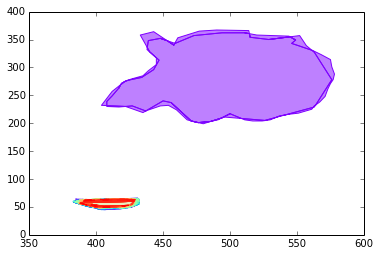

In [91]:
visualizeTilesSeparate(vtiles)

In [57]:
PLOT=True

In [63]:
# import mpld3
# mpld3.enable_notebook()
mpld3.disable_notebook()

In [67]:
def plot_tile_duplicate_heatmap(objid,tiles):
    # Create a masked image for the object
    # where each of the worker BB is considered a mask and overlaid on top of each other 
    img_name = img_info[img_info.id==int(object_tbl[object_tbl.id==objid]["image_id"])]["filename"].iloc[0]
    fname = "../../web-app/app/static/"+img_name+".png"
    img=mpimg.imread(fname)
    width,height = get_size(fname)
    mega_mask = np.zeros((height,width))
    
    obj_x_locs = [tile.exterior.xy[0] for tile in tiles]
    obj_y_locs = [tile.exterior.xy[1] for tile in tiles]
    for x_locs, y_locs in zip(obj_x_locs,obj_y_locs):
        img = Image.new('L', (width, height), 0)
        ImageDraw.Draw(img).polygon(zip(x_locs,y_locs), outline=1, fill=1)
        mask = np.array(img)==1
        # plt.imshow(mask)
        mega_mask+=mask
    if PLOT: 
        # Visualize mega_mask
        plt.figure()
        plt.imshow(mega_mask,interpolation="none")#,cmap="rainbow")
        plt.colorbar()

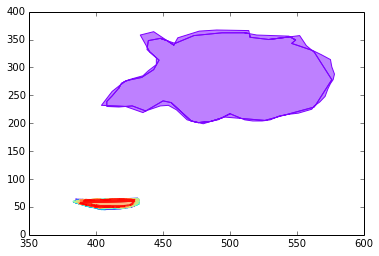

In [21]:
visualizeTilesSeparate(tile)

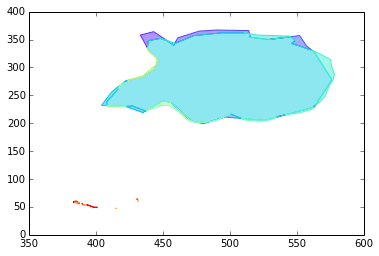

In [20]:
visualizeTilesSeparate(vtiles)

In [25]:
print "Duplication rate: ", (len(tile)-len(vtiles))/float(len(tile))

 Duplication rate:  0.976729559748


In [ ]:
pkl.dump(open("uniqified_output/tiles{}.pkl".format(objid)))

In [92]:
objid=20
tile = pkl.load(open("output/tiles{}.pkl".format(objid)))
vtiles =compute_unique_tileset(tile)

  1%|▏         | 21/1570 [00:00<00:07, 198.04it/s]

Duplicate tiles:  31 28 0.975954790404 1.28853412191 1.32028054433
Duplicate tiles:  32 28 0.985484136187 14.9960897728 14.7784085759
Duplicate tiles: 

  3%|▎         | 42/1570 [00:00<00:10, 146.71it/s]

 41 39 1.0 0.184931668795 0.184931668795
Duplicate tiles:  46 43 0.30041031724 0.0385857295472 0.12844342332
Duplicate tiles:  55 28 0.571659885882 26.3397477934 15.0573772177
Duplicate tiles:  58 2 0.648985416948 1981.14261167 2435.31632404
Duplicate tiles:  58 49 0.322119958187 784.463992471 2435.31632404
Duplicate tiles: 

  4%|▍         | 63/1570 [00:00<00:15, 97.92it/s] 

 60 58 0.28916204116 75.5030120482 261.109693878
Duplicate tiles:  63 2 0.370139038342 330.337648137 187.616803932
Duplicate tiles:  64 53 0.970445165094 3.46548188653 3.36306014151
Duplicate tiles:  65 32 0.706864403889 6.52386989385 4.63871562745
Duplicate tiles:  67 63 0.536510364636 15.4053242776 8.2651161455
Duplicate tiles:  70 54 0.370693502087 325.099567562 172.718707901
Duplicate tiles:  71 31 0.970784122314 0.293470459639 0.302302492278
Duplicate tiles:  73 49 0.834607331819 11.2823705756 9.41634920274
Duplicate tiles:  74 49 0.986662261045 15.0328784332 14.8323738249
Duplicate tiles:  77 67 0.954706265858 65.3459445225 63.2980599647
Duplicate tiles:  78 2 0.441447697149 14365.054177 32540.7840381
Duplicate tiles: 

  7%|▋         | 105/1570 [00:02<00:28, 51.43it/s]

 78 30 0.541187450697 17622.0792842 32540.7840381
Duplicate tiles:  113 18 0.314354302491 0.478266457046 0.345114345114
Duplicate tiles:  115 125 0.492037782399 0.482404264269 0.639232667019
Duplicate tiles: 

 12%|█▏        | 189/1570 [00:05<00:40, 34.03it/s]

 120 35 1.0 3.45849802372 3.45849802372
Duplicate tiles: 

 15%|█▍        | 231/1570 [00:07<00:45, 29.29it/s]

 197 213 0.576518887855 1.14264972777 1.04443250985
Duplicate tiles:  236 142 0.493430272578 6.85139463499 8.37059748693
Duplicate tiles: 

 16%|█▌        | 252/1570 [00:09<00:48, 27.27it/s]

 239 254 0.21886229786 1.01839932713 0.222889216876
Duplicate tiles: 

 17%|█▋        | 273/1570 [00:10<00:51, 25.37it/s]

 268 233 0.385959553586 7.4499260484 15.9998717272
Duplicate tiles:  273 236 0.285744829008 0.34317774568 0.0980612662592
Duplicate tiles: 

 19%|█▊        | 294/1570 [00:12<00:54, 23.49it/s]

 277 302 0.270730542356 2.23963202449 0.729957440885
Duplicate tiles:  297 260 0.931539446075 28.7266956598 26.7600501625
Duplicate tiles:  303 285 0.380099127398 3.0237528286 5.09489113541
Duplicate tiles:  306 277 0.56222215387 1.74260633928 1.66327434788
Duplicate tiles:  307 338 0.515261053048 0.683542458466 0.352202806953
Duplicate tiles: 

 20%|██        | 315/1570 [00:14<00:57, 21.96it/s]

 312 320 0.337004198182 1.84308712121 5.46903311933
Duplicate tiles: 

 21%|██▏       | 336/1570 [00:16<00:59, 20.76it/s]

 320 234 0.324035654509 0.672222222222 2.07453165375
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (490.058 179.434, 490.055 179.256) and LINESTRING (490.054 179.212, 490.057 179.431) at 490.05609873741969 179.34722466604086


 340 255 0.359158688517 2.72108843537 7.57628458498
Topological Error

 24%|██▍       | 378/1570 [00:20<01:03, 18.70it/s]

 345 126
Duplicate tiles:  383 290 0.339674359808 9.82456837796 12.7156931329
Duplicate tiles:  396 130 0.215334710198 1.39616106823 0.68308169472
Duplicate tiles: 

 25%|██▌       | 399/1570 [00:22<01:05, 17.75it/s]

 397 385 0.482866276407 0.452659338945 0.900375940579
Duplicate tiles:  397 431 0.42501746466 1.09551912921 0.900375940579
Duplicate tiles:  403 132 0.691190265035 0.327921338536 0.226656036894
Duplicate tiles:  405 339 0.233365374816 3.62594599812 0.887212885154
Duplicate tiles:  411 264 0.883027558954 0.241043860154 0.212848371433
Duplicate tiles: 

 27%|██▋       | 420/1570 [00:24<01:08, 16.90it/s]

 417 232 0.633300104798 0.30223880597 0.191407867495
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (351.957 263.77, 351.947 263.509) and LINESTRING (351.956 263.748, 351.957 263.77) at 351.95625948661979 263.76068545422731


 423 207 0.265996080152 16.3399641577 4.34636641577
Topological Error 427 294
Duplicate tiles:  434 309 0.738907694346 1.08469544696 0.810469289072
Duplicate tiles:  436 283 0.811966546646 0.750332696823 0.609245048675
Duplicate tiles: 

 28%|██▊       | 441/1570 [00:27<01:10, 16.10it/s]

 437 470 0.306884056042 1.91463076415 2.17433311924
Duplicate tiles:  441 289 0.528401292706 0.245116479421 0.443853268542
Duplicate tiles:  450 119 0.998174472081 0.474364856146 0.475232406171
Duplicate tiles:  454 369 0.79181715016 5.11068211068 4.46122468697
Duplicate tiles:  459 479 0.328716622659 1.50706495242 4.58469346707
Duplicate tiles: 

 29%|██▉       | 462/1570 [00:29<01:11, 15.42it/s]

 461 193 0.544757051297 0.147258285609 0.270319191387
Duplicate tiles:  462 420 0.933097203858 0.382439755702 0.40986057414
Duplicate tiles:  465 214 0.588882631666 0.483890577508 0.67624042624
Duplicate tiles:  467 205 0.566553934238 15.2711974967 18.9876228379
Duplicate tiles:  471 262 0.46518748838 0.100204528543 0.131579514019
Duplicate tiles:  478 450 0.987978111039 0.672325074684 0.664242457291
Duplicate tiles:  479 211 0.454853783289 1.54409638554 0.702338082726
Duplicate tiles: 

 31%|███       | 483/1570 [00:32<01:13, 14.77it/s]

 482 486 0.637738924146 0.246443545972 0.157166641871
Duplicate tiles:  488 273 0.392940754446 0.364177667767 0.143100247525
Duplicate tiles:  492 518 0.533611408801 0.0217536023537 0.0116079703985
Duplicate tiles:  494 280 0.47971781305 0.0433155080214 0.0207792207792
Duplicate tiles:  501 19 0.789924147652 35.5427093709 33.7580994631
Duplicate tiles: 

 32%|███▏      | 504/1570 [00:35<01:15, 14.11it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (351.958 263.798, 351.951 263.605) and LINESTRING (351.948 263.517, 351.957 263.77) at 351.95276143525706 263.66157399894979


 502 392 0.568207115042 21.3996909802 25.1256695137
Topological Error 508 284
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (493.583 277.245, 493.311 274.798) and LINESTRING (493.4 275.6, 493.4 281.933) at 493.39996337890625 275.59967041016625


 512 15 0.255253270313 4.59109500693 1.92177385187
Topological Error 514 492
Duplicate tiles: 

 33%|███▎      | 525/1570 [00:38<01:17, 13.56it/s]

 518 517 0.94523099117 1.63794671195 1.73285337368
Duplicate tiles:  528 19 0.457038970342 0.0697149934208 0.152536212325
Duplicate tiles:  528 330 0.276113560814 0.0421173167381 0.152536212325
Duplicate tiles:  529 503 0.606810321713 3.17782444581 2.73185589365
Duplicate tiles:  531 578 0.220553162505 0.858375446814 0.189317419412
Duplicate tiles:  536 591 0.305541820356 0.470920474592 0.14388589905
Duplicate tiles:  541 205 0.237098340045 0.48 0.113807203222
Duplicate tiles: 

 35%|███▍      | 546/1570 [00:41<01:18, 13.00it/s]

 545 397 0.848316059599 0.651550802139 0.768051948052
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (493 270, 493.055 272.493) and LINESTRING (493.4 258.401, 493.047 272.154) at 493.04733727810651 272.1538461538463


 546 323 0.204509346925 10.6245710285 7.83026357025
Topological Error 546 563
Duplicate tiles: 

 548 263 0.373771901559 2.80677168011 5.02595804026
Duplicate tiles:  548 268 0.304534958264 1.82501307469 5.02595804026
Duplicate tiles:  555 305 0.3350647286 5.52956297031 16.5029694215
Duplicate tiles:  555 496 0.333370127857 7.74274203105 16.5029694215
Duplicate tiles:  557 579 0.481378800453 0.0269164513351 0.0129570090562
Duplicate tiles: 

 36%|███▌      | 567/1570 [00:45<01:20, 12.48it/s]

 566 592 1.0 0.32236453202 0.32236453202
Duplicate tiles:  571 398 0.244685846436 124.371351477 32.020812309
Duplicate tiles:  575 303 0.200666263394 0.0178201906552 0.0888051152882
Duplicate tiles:  575 348 0.305252482155 0.0271079818698 0.0888051152882
Duplicate tiles:  584 186 0.409442424343 2.80872494026 6.8598776611
Duplicate tiles:  584 445 0.27687675913 14.6316098671 6.8598776611
Duplicate tiles: 

 37%|███▋      | 588/1570 [00:48<01:21, 12.01it/s]

 586 34 0.820633784223 0.0898576937732 0.109497921607
Duplicate tiles:  601 669 0.911023958784 2.52872451131 2.30372861497
Duplicate tiles:  602 211 0.97095504319 3.35532490002 3.25786963321
Duplicate tiles:  605 552 0.999999999999 0.00639208425654 0.00639208425654
Duplicate tiles: 

 39%|███▉      | 609/1570 [00:52<01:22, 11.61it/s]

 608 675 0.209887683415 0.268253968258 1.27808342006
Duplicate tiles:  610 630 0.54759435 65.7296362341 97.6861626015
Duplicate tiles:  617 146 0.390412337901 0.0429379519579 0.109981032333
Duplicate tiles:  620 655 0.310966523755 11.4116883117 3.54865304446
Duplicate tiles: 

 40%|████      | 630/1570 [00:55<01:23, 11.25it/s]

 626 302 0.294323944321 3.15832746065 0.929571395678
Duplicate tiles:  634 687 0.407612586996 3.29055220954 7.34259259259
Duplicate tiles:  644 331 0.525954157606 0.245637608948 0.217900699004
Duplicate tiles:  645 592 0.38605450609 0.670013386881 1.735540905
Duplicate tiles: 

 41%|████▏     | 651/1570 [00:59<01:24, 10.92it/s]

 648 632 0.618116353438 0.070984924633 0.0438769427632
Duplicate tiles:  655 254 0.645722600928 4.09646494029 4.74085632054
Duplicate tiles:  663 689 1.0 0.285204991087 0.285204991087
Duplicate tiles:  665 713 0.213278192608 0.0887065773135 0.293624438025
Duplicate tiles: 

 43%|████▎     | 672/1570 [01:03<01:24, 10.60it/s]

 671 688 0.559522567911 3.41489612337 2.09235419201
Duplicate tiles:  683 728 0.630606557246 0.972893746381 0.780179842638
Duplicate tiles:  689 331 0.251516130247 1.04258581046 0.703723813432
Duplicate tiles: 

 44%|████▍     | 693/1570 [01:07<01:25, 10.31it/s]

 690 749 1.0 2.60970171418 2.60970171418
Duplicate tiles:  703 708 0.230983484507 0.349596625201 1.51351351351
Duplicate tiles: 

 45%|████▌     | 714/1570 [01:11<01:25, 10.04it/s]

 708 435 1.0 13.7007850017 13.7007850017
Duplicate tiles:  714 749 0.813486583508 35.6269208985 43.4522743496
Duplicate tiles:  715 736 0.579922772942 1.25794707631 1.08149648357
Duplicate tiles:  717 624 0.326895213319 28.2098058347 86.296172857
Duplicate tiles:  720 636 1.0 6.22222222222 6.22222222222
Duplicate tiles: 

 47%|████▋     | 735/1570 [01:15<01:25,  9.76it/s]

 733 312 0.999999999904 0.254833838589 0.254833838565
Duplicate tiles:  740 744 0.261014678657 12.3227388343 3.21641571701
Duplicate tiles:  747 364 0.958357241871 2.61990284533 2.73374346315
Duplicate tiles:  748 389 0.370384711291 7.9034798742 3.58019639935
Duplicate tiles:  749 534 0.373373992064 0.857664839399 2.29706636678
Duplicate tiles:  749 804 0.3075585103 1.95087747706 2.29706636678
Duplicate tiles: 

 48%|████▊     | 756/1570 [01:19<01:25,  9.50it/s]

 750 790 0.999721025781 0.598650080895 0.598817135437
Duplicate tiles:  759 807 0.278067982806 0.41395097721 1.48866824951
Duplicate tiles:  761 731 0.516199865571 3.02138982713 2.57424894385
Duplicate tiles:  764 773 0.558268699468 0.0621523652987 0.111330557056
Duplicate tiles:  768 770 1.0 0.182034632035 0.182034632035
Duplicate tiles:  770 827 0.847277880038 290.657070377 339.079083724
Duplicate tiles:  771 737 0.989688829505 3.52288361763 3.5595871274
Duplicate tiles:  772 568 0.441685975998 0.746586473767 1.30550653175
Duplicate tiles:  772 618 0.34460727624 2.11511089683 1.30550653175
Duplicate tiles: 

 49%|████▉     | 777/1570 [01:24<01:25,  9.22it/s]

 773 795 0.338601052565 0.577483143778 0.195536400322
Duplicate tiles:  783 235 0.688488435545 5.56849380935 8.0322143544
Duplicate tiles:  794 753 0.956930964287 10.4603893664 10.9311849619
Duplicate tiles:  796 288 0.975028412729 51.784876501 53.1111461215
Duplicate tiles: 

 51%|█████     | 798/1570 [01:28<01:25,  8.98it/s]

 796 843 0.975028412729 51.784876501 53.1111461215
Duplicate tiles:  800 765 0.248726125539 0.435700028515 0.180393789514
Duplicate tiles:  802 770 0.848257066957 2.99802133174 2.54309278153
Duplicate tiles:  803 767 1.0 8.52139667576 8.52139667576
Duplicate tiles:  808 804 0.835936191504 0.635083198939 0.738810846363
Duplicate tiles:  813 34 0.809856438732 0.103291574552 0.0836513467175
Duplicate tiles:  815 378 0.224107055673 0.00752341470901 0.00168605031904
Duplicate tiles: 

 52%|█████▏    | 819/1570 [01:33<01:25,  8.76it/s]

 816 538 0.226588268932 0.170580446455 0.752821173221
Duplicate tiles:  824 817 0.318735945202 0.187918441875 0.285032794038
Duplicate tiles:  829 822 0.999999999998 1.46174880453 1.46174880453
Duplicate tiles: 

 54%|█████▎    | 840/1570 [01:37<01:25,  8.57it/s]

 833 178 0.96294395308 27.2534232068 28.3021905061
Duplicate tiles:  841 828 0.485516395882 1.42290816327 0.740277777778
Duplicate tiles:  843 745 0.396370998976 0.780358661965 0.309311542402
Duplicate tiles: 

 55%|█████▍    | 861/1570 [01:42<01:24,  8.37it/s]

 851 534 0.674017716146 1.33700021574 0.901161831898
Duplicate tiles:  868 143 0.291853953622 52.20687009 15.236781442
Duplicate tiles:  871 751 0.270164923055 0.175726873533 0.0474752372667
Duplicate tiles:  873 550 0.349444265342 0.0828212189042 0.0289413999947
Duplicate tiles:  873 552 0.71102273872 0.0407039021661 0.0289413999947
Duplicate tiles: 

 56%|█████▌    | 882/1570 [01:47<01:24,  8.17it/s]

 877 281 0.35519498917 3.34069918446 1.18659961064
Duplicate tiles:  883 410 0.826809550593 0.123095866309 0.105003073563
Duplicate tiles:  893 20 0.749619738813 0.40466475212 0.478681377153
Duplicate tiles: 

 58%|█████▊    | 903/1570 [01:52<01:23,  8.01it/s]

 896 244 0.200486402024 174.321945014 42.4915930227
Duplicate tiles:  903 261 0.276247257111 1.52355483417 4.97481185486
Duplicate tiles:  903 510 0.551783601034 3.49647758869 4.97481185486
Duplicate tiles:  905 994 0.483515684182 0.714855305222 0.781580239453
Duplicate tiles:  908 669 0.997316815792 1.35250954719 1.34888051493
Duplicate tiles:  910 297 0.70996149242 0.331339651513 0.235238393487
Duplicate tiles: 

 59%|█████▉    | 924/1570 [01:58<01:22,  7.83it/s]

 911 915 0.267603826547 0.471047119563 0.300298008225
Duplicate tiles:  924 829 0.384246876599 0.381946743456 0.6506889942
Duplicate tiles:  924 876 0.615753123401 0.400663780541 0.6506889942
Duplicate tiles:  927 570 0.599580118621 0.928209786246 1.54792056184
Duplicate tiles:  928 479 0.431170592553 0.0703703703704 0.163207722384
Duplicate tiles:  933 488 0.200264236066 1.86844919786 0.388538206544
Duplicate tiles:  935 516 0.629037983671 0.331205746187 0.338744588744
Duplicate tiles:  940 283 0.316436418358 0.14457979961 0.173271863321
Duplicate tiles:  942 1024 0.420865570212 1.50323498965 3.57176993331
Duplicate tiles: 

 60%|██████    | 945/1570 [02:03<01:21,  7.64it/s]

 943 536 0.538596413493 1.48767192068 0.801254760931
Duplicate tiles:  946 203 0.437158605216 6.29624655538 2.84855962028
Duplicate tiles:  950 212 0.901035166788 14.9697817368 16.6139816609
Duplicate tiles:  951 579 0.489347517916 0.318380898374 0.155798902371
Duplicate tiles:  952 409 1.0 0.00806557544175 0.00806557544175
Duplicate tiles:  953 723 1.0 0.581428122231 0.581428122231
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (358.306 280.446, 358.307 280.458) and LINESTRING (358.307 280.456, 358.306 280.45) at 358.30690250348903 280.45522002791211


 954 408 0.999999999999 0.0004687968797 0.0004687968797
Topological Error 954 494
Duplicate tiles:  957 775 1.0 0.50737450371 0.50737450371
Duplicate tiles:  959 758 0.247726966252 1.98125871062 0.800692430646
Duplicate tiles: 

 62%|██████▏   | 966/1570 [02:09<01:20,  7.48it/s]

 962 626 0.926583453162 653.148007527 690.131869707
Duplicate tiles:  968 265 0.443837800057 1.63329523182 0.724923879603
Duplicate tiles:  970 19 0.315499586071 0.299987024783 0.0946457821456
Duplicate tiles:  971 372 0.637576661757 5.50297619048 5.74522266267
Duplicate tiles:  971 518 0.362423338243 2.08220277636 5.74522266267
Duplicate tiles:  976 996 0.999999999999 0.0241758241758 0.0241758241758
Duplicate tiles:  981 242 0.249626080803 0.389518174134 1.56040656041
Duplicate tiles:  981 755 0.750373919197 1.55710314903 1.56040656041
Duplicate tiles: 

 63%|██████▎   | 987/1570 [02:14<01:19,  7.34it/s]

 982 157 0.29818449469 0.32446846775 0.0967514660996
Duplicate tiles: 

 64%|██████▍   | 1008/1570 [02:19<01:18,  7.20it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (358.303 280.424, 358.111 282.056) and LINESTRING (358.297 280.475, 358.303 280.424) at 358.29985630985925 280.45122136619625


 991 649 1.0 1.36463646365 1.36463646365
Topological Error 1009 489
Duplicate tiles:  1017 856 0.638887566635 0.713100358567 1.11615939299
Duplicate tiles:  1020 562 0.431225366753 5.09736570948 2.19811339755
Duplicate tiles:  1022 317 0.386501604381 64.2378480844 106.727598489
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (490.036 179.449, 490.036 179.381) and LINESTRING (490.036 179.449, 490.036 179.447) at 490.03649326834881 179.44861385896354


 1025 464 1.0 1.48052682612 1.48052682612
Topological Error 1026 324
Duplicate tiles: 

 66%|██████▌   | 1029/1570 [02:25<01:16,  7.06it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (358.303 280.424, 358.111 282.056) and LINESTRING (358.312 280.5, 358.297 280.475) at 358.29702970297029 280.47524752475243


 1027 905 0.537756693386 2.24935796833 1.20960730329
Topological Error 1034 488
Duplicate tiles:  1034 1106 0.837235165578 0.466998523978 0.557786561265
Duplicate tiles:  1038 907 0.289622727256 1.81670665894 6.27266608462
Duplicate tiles:  1039 772 0.481426847146 1.43940152738 0.789441173363
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (358.507 278.693, 358.297 280.475) and LINESTRING (358.303 280.424, 358.297 280.475) at 358.2990203883478 280.4583266990436


 1039 776 0.435667977479 1.59058405695 0.789441173363
Topological Error 1040 488
Duplicate tiles:  1040 1014 0.999999999969 1.07853922648e-05 1.07853922651e-05
Duplicate tiles:  1042 637 0.909950138447 0.560161333953 0.557661009068
Duplicate tiles:  1043 684 0.727268078003 878.878626539 1189.7236923
Duplicate tiles:  1044 1098 0.510030950502 0.0361230638038 0.0708252386806
Duplicate tiles: 

 67%|██████▋   | 1050/1570 [02:31<01:15,  6.91it/s]

 1047 1014 0.517769607844 0.0517769607844 0.1
Duplicate tiles:  1055 534 0.826194405792 0.669058027402 0.55277199939
Duplicate tiles:  1059 462 0.619487691407 0.646883792698 1.04422380246
Duplicate tiles:  1060 923 0.334986907323 0.0260568263829 0.0777846113184
Duplicate tiles:  1061 1002 0.88384134308 1.09426564662 1.10626698826
Duplicate tiles:  1064 1166 0.400589330887 0.397340009762 0.159170168645
Duplicate tiles: 

 68%|██████▊   | 1071/1570 [02:37<01:13,  6.78it/s]

 1067 534 0.369126989849 9.05492810511 12.1572580645
Duplicate tiles:  1067 537 0.412862603103 6.73229196864 12.1572580645
Duplicate tiles:  1072 426 0.242935445033 1.64384191176 1.95202558758
Duplicate tiles:  1072 470 0.235616574832 2.0 1.95202558758
Duplicate tiles:  1073 1184 0.839978059398 1.16962570693 1.1438547486
Duplicate tiles:  1074 434 0.292155698112 2.03216808939 6.95349621193
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: side location conflict at 490.05035054064331 179.40046738752443


 1076 361 0.222462086995 8.39649820847 1.86790251491
Topological Error 1077 324
Duplicate tiles:  1081 527 0.433265088376 0.803519219342 0.34813682558
Duplicate tiles:  1083 384 0.642138129028 2.77977575121 1.785
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (410.995 307.426, 410.993 307.121) and LINESTRING (410.994 307.296, 410.402 306.881) at 410.99436846339501 307.2960579243765


 1086 862 0.826664458976 0.321571391646 0.265831640497
Topological Error 1087 608
Duplicate tiles:  1088 833 0.618586732088 7.21177123048 11.237935837
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (489.948 354.156, 489.568 355.297) and LINESTRING (489.99 354.153, 486.012 354.455) at 489.94805194805195 354.15584415584419


 1089 217 0.645445729357 1.49446462108 2.30138782821
Topological Error

 70%|██████▉   | 1092/1570 [02:44<01:11,  6.65it/s]

 1089 1206
Duplicate tiles:  1095 981 1.0 0.203285335098 0.203285335098
Duplicate tiles:  1102 684 0.999985388128 1.50418467527 1.50420665455
Duplicate tiles:  1103 923 0.997264168818 77.9760311183 77.7627018609
Duplicate tiles:  1104 1133 1.0 12.1389168208 12.1389168208
Duplicate tiles:  1105 160 0.764873321904 0.451730341061 0.590594975828
Duplicate tiles:  1106 787 0.998666956452 0.169962547117 0.17018941702
Duplicate tiles: 

 71%|███████   | 1113/1570 [02:50<01:09,  6.53it/s]

 1107 354 0.231758664285 38.8191877854 8.99668310978
Duplicate tiles:  1113 1131 0.3603409581 12.1389168208 8.33182601206
Duplicate tiles:  1114 24 0.441683130359 1.6181541626 3.66360870803
Duplicate tiles:  1114 966 0.558316869641 2.04545454545 3.66360870803
Duplicate tiles:  1115 964 0.321646961285 3.48405256543 1.12063492063
Duplicate tiles:  1116 1015 1.0 0.165951219512 0.165951219512
Duplicate tiles:  1117 844 1.0 0.00168536945298 0.00168536945298
Duplicate tiles:  1118 682 0.999879011873 0.18164274392 0.181664723194
Duplicate tiles:  1119 1218 0.362223372948 29.8225046757 10.8024082334
Duplicate tiles:  1121 1030 0.4028804567 1.6414843079 3.21020119831
Duplicate tiles:  1129 862 1.0 0.401223580341 0.401223580341
Duplicate tiles: 

 72%|███████▏  | 1134/1570 [02:56<01:07,  6.41it/s]

 1133 1224 1.0 3.95767709457 3.95767709457
Duplicate tiles:  1134 1246 0.999999999999 0.119933554817 0.119933554817
Duplicate tiles:  1143 1202 0.681196343744 0.8159668829 0.555833657247
Duplicate tiles:  1144 779 1.0 1.04833495445 1.04833495445
Duplicate tiles:  1146 849 0.464928733733 0.543296703297 1.0747030747
Duplicate tiles:  1146 868 0.535071266267 0.575042735043 1.0747030747
Duplicate tiles:  1148 1250 1.0 43.5787639883 43.5787639883
Duplicate tiles:  1150 673 0.331532225584 7.04321431722 5.04904149843
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 409.58672376873653 359.93147751605994 at 409.58672376873653 359.93147751605994


 1151 956 0.563589579665 0.174243996546 0.309168236662
Topological Error 1151 956
Duplicate tiles:  1152 822 1.0 0.10836997999 0.10836997999
Duplicate tiles: 

 74%|███████▎  | 1155/1570 [03:03<01:05,  6.30it/s]

 1154 639 0.982219331213 3.17590145389 3.13059677335
Duplicate tiles:  1155 648 0.477138032138 0.531324157571 1.11356488434
Duplicate tiles:  1155 840 0.522861967862 0.582240726766 1.11356488434
Duplicate tiles:  1158 697 0.428055224679 0.441496664935 0.984036035443
Duplicate tiles:  1159 599 0.728408350671 30.6291985026 40.5842455583
Duplicate tiles:  1163 1077 0.206201262854 0.403059034424 1.95468751652
Duplicate tiles:  1164 1001 0.99333900236 8.47765678731 8.42118713545
Duplicate tiles:  1166 797 0.314868804665 2.50212765957 0.787841945289
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (410.995 307.426, 410.976 304.988) and LINESTRING (410.988 306.494, 410.989 306.566) at 410.98803733451945 306.50466681492975


 1167 805 0.306716221914 11.1184849831 5.31411478314
Topological Error 1168 603
Duplicate tiles:  1168 960 0.434687285995 0.131921529797 0.303486055488
Duplicate tiles:  1170 777 1.0 3.52288361763 3.52288361763
Duplicate tiles:  1172 256 0.746619919296 0.791919191919 0.640695177838
Duplicate tiles: 

 75%|███████▍  | 1176/1570 [03:10<01:03,  6.18it/s]

 1175 839 1.0 43.0904427646 43.0904427646
Duplicate tiles:  1177 134 0.706439876391 7.53257710155 10.662729205
Duplicate tiles:  1183 846 0.32076098118 0.0263353817946 0.0105344198114
Duplicate tiles:  1188 1230 0.218468717235 0.475026455026 2.02872682561
Duplicate tiles:  1189 764 0.999999999999 1.01460792125 1.01460792125
Duplicate tiles:  1191 739 0.570976953078 4.07515275972 7.13715805471
Duplicate tiles:  1192 756 0.592159176432 4.88830347096 2.89465375751
Duplicate tiles: 

 76%|███████▌  | 1197/1570 [03:17<01:01,  6.07it/s]

 1193 630 1.0 0.864119601329 0.864119601329
Duplicate tiles:  1197 734 0.268404512263 0.0882521300501 0.0775898486973
Duplicate tiles:  1198 1247 0.288347205952 16.2347452495 17.3973821986
Duplicate tiles:  1201 583 0.532070297906 36.6555652963 30.5256797351
Duplicate tiles:  1202 402 1.0 1.44068076853 1.44068076853
Duplicate tiles:  1206 328 0.579769118879 9.1827942098 9.64576731878
Duplicate tiles:  1206 808 0.420230881118 4.24854733867 9.64576731878
Duplicate tiles:  1207 166 0.811436509036 21.6190443046 17.5424818392
Duplicate tiles: 

 78%|███████▊  | 1218/1570 [03:23<00:58,  5.97it/s]

 1209 947 1.0 0.221401794304 0.221401794304
Duplicate tiles:  1218 602 0.999999999999 0.0974552668045 0.0974552668045
Duplicate tiles:  1220 1194 1.0 0.72437978688 0.72437978688
Duplicate tiles:  1221 1195 0.815582294668 0.822023809524 0.670428064843
Duplicate tiles:  1223 305 0.969023173771 169.617508731 167.024019537
Duplicate tiles:  1227 396 0.659207788092 0.267730014934 0.406139035021
Duplicate tiles:  1234 743 0.410451051522 1.22261077117 2.97870054574
Duplicate tiles: 

 79%|███████▉  | 1239/1570 [03:30<00:56,  5.88it/s]

 1238 1281 0.999999999999 0.149757883492 0.149757883492
Duplicate tiles:  1245 183 0.210984886119 0.640935236923 2.3604408791
Duplicate tiles:  1245 1360 0.768259600922 1.82882738762 2.3604408791
Duplicate tiles:  1251 201 0.674546858822 14.8633535765 13.0086017327
Duplicate tiles:  1253 1236 0.763630722357 2.71398898058 2.08532289008
Duplicate tiles:  1256 941 1.0 0.000148660277063 0.000148660277063
Duplicate tiles:  1257 1319 1.0 0.100044671304 0.100044671304
Duplicate tiles:  1258 485 0.374225441822 5.68205505801 2.12636956506
Duplicate tiles: 

 80%|████████  | 1260/1570 [03:37<00:53,  5.78it/s]

 1259 1177 1.0 0.964078599907 0.964078599907
Duplicate tiles:  1263 1048 1.0 7.4621465491 7.4621465491
Duplicate tiles:  1266 1368 0.625550304193 0.672004765046 0.420372785194
Duplicate tiles:  1267 257 0.429013106286 11.9127357625 5.11071977383
Duplicate tiles:  1268 598 0.33155980623 4.78877694947 1.58776595745
Duplicate tiles:  1270 952 0.906681471881 8.43365517328 9.30167366912
Duplicate tiles:  1271 275 0.279082474579 1.08718915384 3.89558375343
Duplicate tiles:  1271 1058 0.569789654792 2.89925231193 3.89558375343
Duplicate tiles:  1272 347 1.0 3.92903594687 3.92903594687
Duplicate tiles:  1273 291 0.981684774621 1.40230943152 1.42847222222
Duplicate tiles:  1276 889 0.521404756712 12.1966633255 22.5557830233
Duplicate tiles:  1276 1295 0.464267878578 11.2182587017 22.5557830233
Duplicate tiles: 

 82%|████████▏ | 1281/1570 [03:45<00:50,  5.69it/s]

 1280 861 0.244443873177 4.6609341411 19.0675024108
Duplicate tiles:  1283 820 0.532086675848 0.0212922568016 0.0400165194283
Duplicate tiles:  1283 931 0.467913324152 0.0187242626267 0.0400165194283
Duplicate tiles:  1285 310 0.331939323975 5.02352650323 1.66750599145
Duplicate tiles:  1287 479 0.882684049932 6.87299919392 7.78647715958
Duplicate tiles:  1288 529 0.999999999999 0.294433152665 0.294433152665
Duplicate tiles:  1294 647 0.999999999996 1.03518686636 1.03518686636
Duplicate tiles:  1297 296 0.311251537578 0.0917907068773 0.259535834536
Duplicate tiles:  1297 531 0.688748462425 0.178754906981 0.259535834536
Duplicate tiles:  1298 483 0.358003466834 0.396549127031 0.942579266625
Duplicate tiles: 

 83%|████████▎ | 1302/1570 [03:52<00:47,  5.60it/s]

 1299 1092 1.0 0.0111454425072 0.0111454425072
Duplicate tiles:  1302 700 0.269450743437 0.5284349196 0.148900200066
Duplicate tiles:  1305 847 0.284453688633 6.36647780525 1.8109680953
Duplicate tiles:  1310 459 0.34638839209 0.512010296333 1.05308882072
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (359.172 282.586, 359.274 282.637) and LINESTRING (359.172 282.586, 360 283) at 359.17195087117966 282.58597543558983


 1311 1363 0.949652973108 0.284761950165 0.270425032603
Topological Error 1313 464
Duplicate tiles:  1314 348 0.576647940191 0.74816098081 0.683057468376
Duplicate tiles:  1314 1365 0.368390642805 0.251631979852 0.683057468376
Duplicate tiles:  1315 175 0.999999999999 0.470795595504 0.470795595504
Duplicate tiles:  1315 781 1.0 0.470795595504 0.470795595504
Duplicate tiles: 

 84%|████████▍ | 1323/1570 [04:00<00:44,  5.51it/s]

 1321 612 0.830633610813 3801.64641136 4576.80301143
Duplicate tiles:  1324 1432 0.575553302811 0.147232552997 0.0847401821587
Duplicate tiles:  1327 660 0.80604913952 11.0900773073 13.6020878177
Duplicate tiles:  1329 1135 1.0 7.83462913864 7.83462913864
Duplicate tiles:  1330 1109 0.901931694376 4.56735603094 4.35456720408
Duplicate tiles:  1332 1144 0.921768929103 0.055739751149 0.0513791707251
Duplicate tiles:  1335 716 0.980745230523 7.6279453847 7.77770326819
Duplicate tiles:  1339 970 1.0 1.49044750088 1.49044750088
Duplicate tiles:  1342 1213 0.611788500789 0.0111649713155 0.0182497240485
Duplicate tiles: 

 86%|████████▌ | 1344/1570 [04:07<00:41,  5.42it/s]

 1343 730 0.516771956725 1.78651719384 3.45707070707
Duplicate tiles:  1346 1267 1.0 1.99364971345 1.99364971345
Duplicate tiles:  1347 1360 0.902766024887 3.20101099202 3.54578141376
Duplicate tiles:  1348 803 0.999999999996 0.00583736438997 0.00583736438999
Duplicate tiles:  1351 1244 0.999999999999 1.24685248197 1.24685248197
Duplicate tiles:  1352 275 0.610000112729 12.6656878264 9.88017057569
Duplicate tiles:  1352 865 0.21802250855 2.15409957382 9.88017057569
Duplicate tiles:  1355 700 0.983336588943 0.496657658254 0.505073912472
Duplicate tiles:  1356 731 0.654965842613 3.94932819308 2.58667506773
Duplicate tiles:  1357 1203 0.968540356634 0.27478646841 0.283711945019
Duplicate tiles:  1358 1141 0.930728610133 4.28629783218 3.98938002396
Duplicate tiles: 

 87%|████████▋ | 1365/1570 [04:15<00:38,  5.34it/s]

 1362 666 0.744363302637 1.08799997067 0.834197006858
Duplicate tiles:  1368 1150 1.0 3.52032418372 3.52032418372
Duplicate tiles:  1369 1225 0.99999999983 1.71428571444 1.71428571429
Duplicate tiles:  1370 328 0.27701818894 0.194353180738 0.701589962311
Duplicate tiles:  1370 1147 0.722981811058 0.507236781572 0.701589962311
Duplicate tiles:  1372 606 0.277713724864 1.09855576968 3.95571292062
Duplicate tiles:  1373 785 0.45875260275 86.097184697 82.5877503338
Duplicate tiles:  1373 802 0.521753439105 43.0904427646 82.5877503338
Duplicate tiles:  1374 574 0.619027673985 0.188469122002 0.213606851635
Duplicate tiles:  1374 794 0.380972326015 0.0900823610158 0.213606851635
Duplicate tiles:  1375 653 1.0 8.09455808462 8.09455808462
Duplicate tiles:  1377 1184 0.99999999999 0.000202656903933 0.000202656903931
Duplicate tiles:  1378 794 0.999999999996 0.00583736438997 0.00583736438997
Duplicate tiles:  1379 268 0.415420548902 1.64125115248 0.921884097896
Duplicate tiles:  1381 1281 0.99999

 88%|████████▊ | 1386/1570 [04:23<00:35,  5.25it/s]

 1385 1194 0.738375374382 4.70816179937 4.21273036157
Duplicate tiles:  1386 614 0.918485860074 4.34965943067 3.99510068321
Duplicate tiles:  1388 603 1.0 8.85954587109 8.85954587109
Duplicate tiles:  1391 384 0.746408126179 5.23354529967 7.01164030256
Duplicate tiles:  1396 489 0.252966209864 4.1884081194 2.28120662131
Duplicate tiles:  1396 1467 0.53511145652 1.25536561743 2.28120662131
Duplicate tiles: 

 90%|████████▉ | 1407/1570 [04:31<00:31,  5.19it/s]

 1404 1322 0.48027877169 4.16532034487 2.00051493893
Duplicate tiles:  1407 340 0.20423014044 1.57633750666 7.71843716733
Duplicate tiles:  1407 342 0.429095130877 3.31194380648 7.71843716733
Duplicate tiles:  1408 1042 0.508348809119 1.50843371929 2.57882959055
Duplicate tiles:  1411 1194 0.41810193083 0.852560436549 0.356457164671
Duplicate tiles:  1414 939 0.828573276141 3.54378819313 2.93628819313
Duplicate tiles:  1416 381 0.430027767375 11.9935977419 5.15758005976
Duplicate tiles:  1417 951 0.999999999999 0.309881220903 0.309881220902
Duplicate tiles:  1418 596 0.639664170763 7.86303526723 5.0297019339
Duplicate tiles:  1419 666 0.827060315516 4.16508324446 3.47784384539
Duplicate tiles:  1420 1340 0.981684774621 1.40230943152 1.42847222222
Duplicate tiles:  1421 1036 0.999999999982 0.00640316205533 0.00640316205545
Duplicate tiles:  1423 1354 0.244443873176 4.6609341411 19.0675024108
Duplicate tiles:  1423 1355 0.755556126824 14.4065682697 19.0675024108
Duplicate tiles:  1424 24

 91%|█████████ | 1428/1570 [04:39<00:27,  5.11it/s]

 1424 327 0.222673667214 3.66101556672 4.30501791879
Duplicate tiles:  1431 1111 0.902247103932 0.455382393762 0.504720260976
Duplicate tiles:  1433 1364 0.842396293961 7.025248142 7.32273167582
Duplicate tiles:  1435 1419 1.0 0.00273350200337 0.00273350200337
Duplicate tiles:  1436 237 0.245284767682 2.74954856399 0.813670240206
Duplicate tiles:  1438 1248 0.859839755238 17.1522277492 19.9481678356
Duplicate tiles:  1440 1486 0.260335698742 0.240074643247 0.101696903347
Duplicate tiles:  1442 1137 0.629082085418 0.00712216970425 0.00448042937025
Duplicate tiles:  1443 947 0.598738296807 11.9176537375 19.9046124176
Duplicate tiles:  1443 1360 0.268106195132 5.4 19.9046124176
Duplicate tiles:  1444 522 0.47376210305 10.519685943 5.07190327788
Duplicate tiles:  1444 525 0.982634774903 4.98382853579 5.07190327788
Duplicate tiles:  1445 266 0.881018075646 26.7600501625 24.1855081882
Duplicate tiles:  1446 1408 0.80604913952 10.9639511811 13.6020878177
Duplicate tiles: 

 92%|█████████▏| 1449/1570 [04:48<00:24,  5.03it/s]

 1447 1104 0.832781420242 0.778934966786 0.935341432761
Duplicate tiles:  1454 1201 0.552092921321 0.00399182214478 0.00220385674931
Duplicate tiles:  1456 1011 0.445677646826 3.93065496752 2.34651011082
Duplicate tiles:  1459 1141 0.823696028274 19.0200964423 22.8835919452
Duplicate tiles:  1461 455 0.988078205643 10.0635439546 10.167271602
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (488.071 179.145, 488.017 176.756) and LINESTRING (488.141 179.141, 488.069 179.069) at 488.06936416184971 179.06936416184971


 1462 1594 0.622415406153 76.8380355491 60.0299141499
Topological Error 1463 168
Duplicate tiles:  1463 1213 0.999999999997 0.00264174033401 0.002641740334
Duplicate tiles:  1463 1571 1.0 0.002641740334 0.002641740334
Duplicate tiles:  1464 1258 0.375697000803 0.000687708951041 0.00183048826463
Duplicate tiles:  1465 753 0.578294768995 10.4603893664 18.0883347511
Duplicate tiles:  1465 1413 0.421705231005 7.6279453847 18.0883347511
Duplicate tiles:  1466 745 1.0 2.78519009726 2.78519009726
Duplicate tiles: 

 94%|█████████▎| 1470/1570 [04:56<00:20,  4.95it/s]

 1468 1419 0.999999999997 0.00708475273304 0.00708475273305
Duplicate tiles:  1470 1468 1.0 0.0604714470286 0.0604714470286
Duplicate tiles:  1471 680 0.535088305917 20.3277837876 35.0530106473
Duplicate tiles:  1472 688 0.425134223804 0.144075077639 0.0612512463014
Duplicate tiles:  1472 1444 0.220223087993 0.278132719233 0.0612512463014
Duplicate tiles:  1474 269 1.0 1.90975003841 1.90975003841
Duplicate tiles:  1475 1393 1.0 2.7273374704 2.7273374704
Duplicate tiles:  1477 432 0.236923693005 0.997518373066 0.614150399451
Duplicate tiles:  1477 1233 0.615182637675 0.377814662663 0.614150399451
Duplicate tiles:  1478 1216 0.735446965212 0.0318131078158 0.0233968535973
Duplicate tiles:  1479 665 0.876344117602 16.2869448475 17.1944861749
Duplicate tiles:  1480 312 0.230377915875 0.0248956006354 0.00573539658886
Duplicate tiles:  1481 395 0.956639053477 0.0105838385516 0.011063565211
Duplicate tiles:  1483 809 0.999999999985 0.213992869875 0.213992869879
Duplicate tiles:  1486 248 0.222

 95%|█████████▍| 1491/1570 [05:05<00:16,  4.88it/s]

 1490 1389 0.491942286666 1.25681821924 2.51245912255
Duplicate tiles:  1491 916 0.415405404185 0.801254760931 1.92885011331
Duplicate tiles:  1491 917 0.29414438811 0.686417159747 1.92885011331
Duplicate tiles:  1492 217 0.37754501016 0.363247585206 0.962130541872
Duplicate tiles:  1492 1636 0.62245498984 0.761071035559 0.962130541872
Duplicate tiles:  1493 1361 0.67833277661 0.688311077381 0.468463395287
Duplicate tiles:  1494 635 0.520517957027 8.58404284879 16.4913481522
Duplicate tiles:  1494 1572 0.369127865745 9.09727408987 16.4913481522
Duplicate tiles:  1496 1613 0.999999999999 0.737913211752 0.737913211751
Duplicate tiles:  1497 842 0.991846484907 0.164387147438 0.165738498789
Duplicate tiles:  1498 724 0.95616927989 12468.1764876 11921.6873337
Duplicate tiles:  1502 1547 0.594293235034 0.00691939629428 0.00411215040821
Duplicate tiles:  1503 1028 1.0 0.0504424505698 0.0504424505698
Duplicate tiles:  1504 1137 1.0 1.23917213538 1.23917213538
Duplicate tiles:  1506 1501 0.9999

 96%|█████████▋| 1512/1570 [05:14<00:12,  4.80it/s]

 1511 874 0.812883208673 9.37974075512 7.62463376154
Duplicate tiles:  1512 214 1.0 0.249464212128 0.249464212128
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (490.891 299.895, 491.379 306.325) and LINESTRING (491.379 306.325, 491.379 306.325) at 491.37909836065035 306.32479508189647


 1513 1207 0.998704630817 8.1225 8.11197836381
Topological Error 1514 1296
Duplicate tiles:  1517 1538 0.344581495418 2.79594008639 0.963429216066
Duplicate tiles:  1522 846 0.556112442751 139.372765465 247.937482062
Duplicate tiles:  1522 1028 0.429185823059 106.411252306 247.937482062
Duplicate tiles:  1523 1220 0.945521322183 3.59047619047 3.39487179488
Duplicate tiles:  1524 1431 0.999999999999 2.85715715094 2.85715715094
Duplicate tiles:  1529 1591 0.999999999998 0.0524844720497 0.0524844720497
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (358.533 282.267, 358.333 280.667) and LINESTRING (358.333 280.667, 358.469 281.75) at 358.36045277913416 280.88362223307325


 1530 238 0.460843177865 1.21527777778 2.32075593395
Topological Error 1530 446
Duplicate tiles:  1530 453 0.217446455326 0.504640151515 2.32075593395
Duplicate tiles:  1531 355 0.487075983361 1.27602639296 2.42916774571
Duplicate tiles:  1531 622 0.293531186816 4.0808786068 2.42916774571
Duplicate tiles: 

 98%|█████████▊| 1533/1570 [05:23<00:07,  4.73it/s]

 1532 1651 1.0 0.00869881552509 0.00869881552509
Duplicate tiles:  1533 163 0.417367235349 6.57862407862 2.7457021441
Duplicate tiles:  1534 389 0.660808622956 0.209320627673 0.138320875729
Duplicate tiles:  1535 636 1.0 0.581428122231 0.581428122231
Duplicate tiles:  1536 1331 0.823385816304 0.55750655778 0.473002434497
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (490.891 299.895, 491.379 306.325) and LINESTRING (491.379 306.325, 491.379 306.325) at 491.37909836065035 306.32479508189647


 1540 156 0.811293875573 9.59973649444 7.99397753214
Topological Error 1541 1286
Duplicate tiles:  1541 1669 1.0 4.75619587076 4.75619587076
Duplicate tiles:  1542 656 1.0 4.49896030683 4.49896030683
Duplicate tiles:  1543 1099 1.0 2.73851479154 2.73851479154
Duplicate tiles:  1544 1450 0.391844652825 4.53299196734 10.1430103052
Duplicate tiles:  1546 1179 0.862895013166 4.83400282118 5.60207527847
Duplicate tiles:  1547 1552 0.991848631569 2.306768659 2.32572651267
Duplicate tiles:  1548 745 0.999999999997 0.454928550204 0.454928550203
Duplicate tiles:  1549 1317 0.848234035239 0.60563822477 0.637474687963
Duplicate tiles:  1550 639 0.787092770798 8.58420189621 8.14198045276
Duplicate tiles:  1551 939 0.205791639302 0.0513235875665 0.249395882848
Duplicate tiles:  1551 947 0.794208360698 0.227717001645 0.249395882848
Duplicate tiles: 

 99%|█████████▉| 1554/1570 [05:33<00:03,  4.67it/s]

 1552 1067 0.468061955463 6.52859569356 3.05578726675
Duplicate tiles:  1556 806 0.999999999959 0.128251636266 0.128251636261
Duplicate tiles:  1557 1714 1.0 0.000264270613108 0.000264270613108
Duplicate tiles:  1559 1679 0.244749774899 0.251745759846 1.02858423445
Duplicate tiles:  1560 1452 0.547926730086 1.45321100917 2.65219951753
Duplicate tiles:  1562 457 0.695880984737 0.149421112627 0.210614261588
Duplicate tiles:  1562 1359 0.296714811082 0.0624923708383 0.210614261588
Duplicate tiles:  1563 1165 0.999999999988 0.0239902080783 0.0239902080786
Duplicate tiles:  1564 1729 1.0 8.41080083719 8.41080083719
Duplicate tiles:  1566 239 0.548203983111 0.746172393783 1.28277964075
Duplicate tiles:  1566 1121 0.451796016888 0.710658859076 1.28277964075
Duplicate tiles:  1567 711 1.0 0.791723934813 0.791723934812
Duplicate tiles:  1568 635 0.686030536833 5.80211121615 8.45751158968
Duplicate tiles: 

 1568 1484 0.221014085388 1.86922918865 8.45751158968


Duplication rate:  -0.114649681529


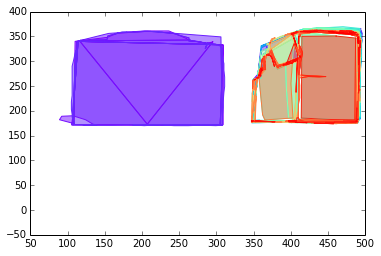

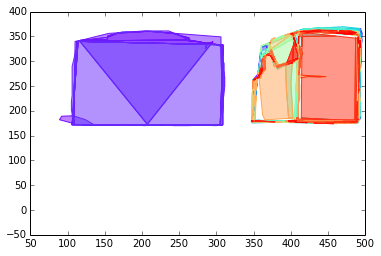

In [93]:
visualizeTilesSeparate(tile)

visualizeTilesSeparate(vtiles)

print "Duplication rate: ", (len(tile)-len(vtiles))/float(len(tile))

In [95]:
objid=25
tile = pkl.load(open("output/tiles{}.pkl".format(objid)))
vtiles =compute_unique_tileset(tile)

  3%|▎         | 88/2702 [00:00<00:27, 94.21it/s] 

Duplicate tiles:  73 62 0.22742114011 0.0764790619759 0.0173929554741
Duplicate tiles: 

  5%|▍         | 132/2702 [00:02<00:40, 63.77it/s]

 102 101 0.330518004573 1.68126516194 2.42016699784
Duplicate tiles:  147 139 0.332157602977 0.145970814557 0.169671090616
Duplicate tiles: 

  7%|▋         | 176/2702 [00:03<00:52, 47.68it/s]

 149 149 1.0 0.0896132718031 0.0896132718031
Duplicate tiles: 

  8%|▊         | 220/2702 [00:05<01:04, 38.76it/s]

 186 121 0.51451609424 1.62022956435 2.68274436665
Duplicate tiles: 

  9%|▉         | 242/2702 [00:06<01:09, 35.44it/s]

 227 200 0.999999999999 0.220223964279 0.220223964279
Duplicate tiles:  243 110 0.846185213784 3.89016334523 3.29179870194
Duplicate tiles:  244 234 1.0 2.87677248369 2.87677248369
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (581.657 324.71, 581.579 324.777) and LINESTRING (581.587 324.77, 581.591 324.766) at 581.58931451953583 324.76783231074501


 247 216 0.419338167837 1.58387114901 0.879078551436
Topological Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (583.508 326.946, 582.475 325.785) and LINESTRING (581.786 324.598, 583.034 326.414) at 583.0344827586207 326.4137931034482


 252 95
Topological Error

 10%|▉         | 264/2702 [00:08<01:16, 31.90it/s]

 252 234
Duplicate tiles:  282 283 0.223722188394 2.7462724805 3.38148113873
Duplicate tiles: 

 11%|█         | 286/2702 [00:09<01:24, 28.64it/s]

 283 285 0.448040733601 2.62201606238 1.1747700001
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (622.562 382.123, 622.455 381.909) and LINESTRING (622.455 381.909, 622.599 382.198) at 622.53955172893973 382.07910345787946


 288 264 0.263695168081 1.78564885051 0.482530141057
Topological Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (622.455 381.909, 619.565 378) and LINESTRING (619.667 378.179, 619 377) at 619.56521739130471 378.00000000000045


 298 291
Topological Error 300 303
Duplicate tiles:  301 47 0.326504550793 0.295036252091 0.30014383794
Duplicate tiles:  303 209 0.811335564332 0.263504930817 0.32477921886
Duplicate tiles: 

 11%|█▏        | 308/2702 [00:11<01:31, 26.28it/s]

 305 207 0.999999995023 0.10734996214 0.107349962674
Duplicate tiles:  312 317 0.330704494306 0.321104954008 0.106190851434
Duplicate tiles:  319 245 0.232703181686 0.901839092249 0.209860826135
Duplicate tiles:  321 155 0.456453653538 3.97492669787 2.5348400133
Duplicate tiles: 

 13%|█▎        | 352/2702 [00:15<01:44, 22.42it/s]

 326 245 0.64870043303 0.214900925719 0.331279146393
Duplicate tiles: 

 15%|█▍        | 396/2702 [00:21<02:03, 18.63it/s]

 369 379 0.558420097151 5.59441241439 10.018286307
Duplicate tiles: 

 15%|█▌        | 418/2702 [00:23<02:08, 17.77it/s]

 401 56 0.753913206225 0.284625451036 0.266251803572
Duplicate tiles:  425 434 0.826399561977 4.68226575709 4.72727272727
Duplicate tiles: 

 16%|█▋        | 440/2702 [00:26<02:14, 16.87it/s]

 437 448 0.302270143605 0.557901489411 0.168636963321
Duplicate tiles:  445 381 0.309729156606 2.3223973607 0.719314175836
Duplicate tiles: 

 17%|█▋        | 462/2702 [00:28<02:18, 16.18it/s]

 449 157 0.43966604478 0.00992616899097 0.0225766103815
Duplicate tiles:  462 403 0.243216493894 61.4752344394 14.9517909817
Duplicate tiles:  469 439 0.999999999999 0.0120571746508 0.0120571746508
Duplicate tiles:  472 451 0.940505060126 14.6360484888 13.9896551947
Duplicate tiles:  478 475 0.460507893643 9.23830877549 20.0611301196
Duplicate tiles: 

 18%|█▊        | 484/2702 [00:31<02:23, 15.47it/s]

 480 428 0.417063802804 0.433190884614 0.180668237677
Duplicate tiles:  491 444 1.0 0.000138600138602 0.000138600138602
Duplicate tiles:  501 454 0.522685303834 0.450752437407 0.2356016747
Duplicate tiles: 

 19%|█▊        | 506/2702 [00:33<02:27, 14.88it/s]

 502 462 0.695887164838 0.111801242236 0.077801049485
Duplicate tiles:  514 530 0.851008813311 0.600688880422 0.705855064044
Duplicate tiles:  517 508 0.999999999999 0.019807303311 0.019807303311
Duplicate tiles:  521 262 0.519992788858 0.479970791611 0.857647660537
Duplicate tiles:  524 473 0.718480215407 41.723866627 34.0796451124
Duplicate tiles:  525 361 0.249814901687 0.381725331137 0.2806770899
Duplicate tiles: 

 20%|█▉        | 528/2702 [00:36<02:31, 14.32it/s]

 526 488 0.24892412756 30.9818068722 124.462852098
Duplicate tiles:  531 507 0.944604457225 0.21567868155 0.203731044185
Duplicate tiles: 

 21%|██        | 572/2702 [00:42<02:38, 13.42it/s]

 532 512 0.609764836319 0.215150762707 0.131191369606
Duplicate tiles:  580 115 0.999999952024 8.48757987894 8.48757947174
Duplicate tiles: 

 22%|██▏       | 594/2702 [00:45<02:42, 12.97it/s]

 582 412 0.297248297978 0.722647667285 1.70850909992
Duplicate tiles:  602 276 1.0 0.00295271598377 0.00295271598377
Duplicate tiles:  608 619 0.858709767292 0.746652255019 0.869504788996
Duplicate tiles: 

 23%|██▎       | 616/2702 [00:49<02:47, 12.48it/s]

 613 325 0.525769626469 2.16050020545 2.83737031125
Duplicate tiles: 

 24%|██▎       | 638/2702 [00:52<02:51, 12.07it/s]

 616 596 0.257598295676 0.172314835517 0.0443880079488
Duplicate tiles:  638 465 0.437504632096 51.6177437993 78.0492056259
Duplicate tiles:  648 663 0.999999999999 0.718772686957 0.718772686957
Duplicate tiles: 

 24%|██▍       | 660/2702 [00:56<02:55, 11.65it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (608.968 366.516, 608.968 366.516) and LINESTRING (609.875 367.625, 608.968 366.516) at 608.96774193548367 366.51612903225777


 658 678 0.22497416699 9.78139046589 2.20056017207
Topological Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (601.647 357.168, 603.783 359.609) and LINESTRING (603.783 359.609, 603.783 359.609) at 603.78260869565236 359.60869565217411


 663 452
Topological Error 663 656
Duplicate tiles:  669 113 0.391490076149 3.68687562438 9.41754554965
Duplicate tiles:  676 373 0.200338816582 2.00429933085 0.694363030092
Duplicate tiles: 

 25%|██▌       | 682/2702 [01:00<02:59, 11.23it/s]

 677 654 0.264698287658 0.157243618451 0.594048491367
Duplicate tiles:  684 407 0.472978335188 0.0516689172082 0.0244382784421
Duplicate tiles:  685 597 0.43820614201 1.53484832968 0.98976619883
Duplicate tiles:  692 536 1.0 30.9818068722 30.9818068722
Duplicate tiles:  694 523 0.471480302025 372.120295362 176.091963555
Duplicate tiles: 

 26%|██▌       | 704/2702 [01:04<03:04, 10.84it/s]

 698 420 0.281516351857 18.0834353058 5.09078273632
Duplicate tiles:  708 572 1.0 0.887949260042 0.887949260042
Duplicate tiles:  709 732 1.0 0.2917859685 0.291785968499
Duplicate tiles: 

 27%|██▋       | 726/2702 [01:08<03:07, 10.53it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (366.677 442.528, 364.932 439.405) and LINESTRING (365.795 440.949, 365.17 439.83) at 365.72250827148366 440.81922532791805


 717 245 0.993857116237 1.62160645125 1.63162936076
Topological Error 742 532
Duplicate tiles:  743 649 1.0 0.389153263993 0.389153263993
Duplicate tiles:  744 365 0.705317995131 28.7540072128 40.7674373989
Duplicate tiles: 

 28%|██▊       | 748/2702 [01:13<03:11, 10.20it/s]

 747 351 0.869859748164 0.743306506284 0.646572410365
Duplicate tiles:  753 86 0.356332414201 0.923554477582 2.5918340313
Duplicate tiles:  753 571 0.238251627768 0.617508676862 2.5918340313
Duplicate tiles:  762 762 0.334367298653 12.0134301861 35.9288430252
Duplicate tiles: 

 28%|██▊       | 770/2702 [01:17<03:14,  9.91it/s]

 766 377 0.588013049789 28.8326723428 16.9539875978
Duplicate tiles:  781 10 0.608901742666 0.35029433703 0.213294832263
Duplicate tiles: 

 29%|██▉       | 792/2702 [01:22<03:17,  9.66it/s]

 789 677 0.999999999977 1.50261012588 1.50261012586
Duplicate tiles:  792 641 0.343451915372 0.78579351994 2.2879287748
Duplicate tiles:  796 711 0.234747661078 0.510502995386 1.41816970024
Duplicate tiles:  801 315 0.498259445292 10.5841152168 5.27363537682
Duplicate tiles:  802 783 1.0 0.123199856825 0.123199856825
Duplicate tiles:  807 823 1.0 0.403643564356 0.403643564356
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (524.206 314.807, 526.399 313.325) and LINESTRING (526.399 313.325, 519.913 317.559) at 526.39877300613068 313.32515337423604


 808 195 0.491727688133 2.31314752593 1.32569501087
Topological Error 809 708
Duplicate tiles: 

 30%|███       | 814/2702 [01:27<03:21,  9.35it/s]

 811 192 0.906036630647 0.220223964279 0.243062980932
Duplicate tiles:  816 204 0.410340112679 0.0714140345166 0.101020408163
Duplicate tiles:  822 528 0.380810556069 0.14367019468 0.37727471676
Duplicate tiles:  822 813 0.598578866186 0.225828672199 0.37727471676
Duplicate tiles: 

 31%|███       | 836/2702 [01:31<03:24,  9.11it/s]

 823 779 1.0 0.123199856825 0.123199856825
Duplicate tiles:  838 834 1.0 0.382817993763 0.382817993763
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (609.875 367.625, 608.968 366.516) and LINESTRING (608.968 366.516, 611 369) at 609.64074131513644 367.33868382961117


 839 686 0.709657510789 6.89655257579 9.71814216146
Topological Error

 32%|███▏      | 858/2702 [01:37<03:28,  8.84it/s]

 844 666
Duplicate tiles:  844 775 0.56639965995 23.9154128391 26.5019613784
Duplicate tiles:  868 664 0.857524151197 7.55685100213 7.06457064994
Duplicate tiles:  872 100 0.516514242203 1.62025823098 0.836886452348
Duplicate tiles:  873 574 0.233760301431 27.9691733095 17.763282726
Duplicate tiles:  875 433 0.474275177607 4.84169613911 2.6075370465
Duplicate tiles: 

 33%|███▎      | 902/2702 [01:47<03:35,  8.36it/s]

 879 113 1.0 0.0443667491168 0.0443667491168
Duplicate tiles:  907 672 0.28283949171 157.697057425 446.885404293
Duplicate tiles:  910 269 0.999999999993 0.00295271598377 0.00295271598377
Duplicate tiles: 

 34%|███▍      | 924/2702 [01:52<03:37,  8.19it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (630.72 393.909, 631 394.308) and LINESTRING (630.802 393.644, 630.72 393.909) at 630.72016460905354 393.90946502057608


 917 313 0.487468588261 0.691978266114 0.33731766849
Topological Error 930 484
Duplicate tiles:  936 947 0.985663081596 0.181451612748 0.184090909091
Duplicate tiles:  940 325 0.839332866605 0.0373035678038 0.0313101104994
Duplicate tiles: 

 35%|███▌      | 946/2702 [01:58<03:39,  8.02it/s]

 945 617 0.925623803499 0.394194120982 0.36487546158
Duplicate tiles:  953 614 0.581838313639 0.127926827568 0.0744327296214
Duplicate tiles:  957 298 0.852364195936 0.0612742880429 0.0522280092593
Duplicate tiles: 

 36%|███▌      | 968/2702 [02:03<03:40,  7.86it/s]

 959 964 0.999999913285 0.00263929634252 0.00263929611378
Duplicate tiles:  969 258 0.616579642063 0.273650238235 0.41179394769
Duplicate tiles:  972 283 0.539058852025 0.0866666666666 0.154447650349
Duplicate tiles:  972 1001 0.450891093239 0.157890182819 0.154447650349
Duplicate tiles:  980 369 0.999999999994 0.208247639735 0.208247639736
Duplicate tiles:  983 936 0.866184733498 22.8877845398 26.4236757526
Duplicate tiles:  984 434 0.400141545031 0.186226537571 0.465401655698
Duplicate tiles:  984 450 0.599858454965 0.279175118125 0.465401655698
Duplicate tiles: 

 37%|███▋      | 990/2702 [02:08<03:42,  7.69it/s]

 986 739 0.966977303731 5.81022120519 6.00864279107
Duplicate tiles:  993 500 0.929879451534 0.105166183623 0.113096577679
Duplicate tiles:  995 447 0.237504616289 4.79957683074 1.13992165353
Duplicate tiles:  997 848 1.0 2.48139981134 2.48139981134
Duplicate tiles:  998 627 0.604811680241 43.9023166331 34.3957711443
Duplicate tiles:  1007 430 0.760812515684 0.0852228045684 0.0847755363721
Duplicate tiles: 

 37%|███▋      | 1012/2702 [02:14<03:43,  7.55it/s]

 1008 445 0.757000280875 14.9517909817 19.7513678124
Duplicate tiles:  1012 429 0.719748395383 0.440513925667 0.612038774234
Duplicate tiles:  1014 456 0.482736769562 0.611076507536 1.08336558487
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (630.486 394.67, 630.018 393.64) and LINESTRING (629.079 391.574, 630.486 394.67) at 630.15168775869256 393.9337130691236


 1020 944 0.265637390087 1.71876187053 0.45656741747
Topological Error 1020 944
Duplicate tiles:  1021 426 0.359623222082 0.389264526089 0.139988563118
Duplicate tiles:  1022 408 0.69304514263 0.0629612257661 0.0436349716913
Duplicate tiles:  1025 683 0.999999999968 0.0237883695611 0.0237883695605
Duplicate tiles:  1027 428 0.724044998291 1.60308318487 2.21406568466
Duplicate tiles:  1027 1028 0.275955001709 0.976866608779 2.21406568466
Duplicate tiles:  1033 360 0.999999998643 2.10147653345 2.1014765363
Duplicate tiles: 

 38%|███▊      | 1034/2702 [02:20<03:45,  7.38it/s]

 1033 846 0.235996042228 8.90471092643 2.1014765363
Duplicate tiles:  1044 434 0.303471649433 8.5850327928 19.3789633891
Duplicate tiles:  1047 472 0.227036363616 1.05364583333 4.64086816997
Duplicate tiles:  1051 379 0.228862992071 108.885036501 67.2852279288
Duplicate tiles:  1051 523 0.460824049116 31.7291435969 67.2852279288
Duplicate tiles:  1052 1060 0.999999999665 0.365884108983 0.365884108916
Duplicate tiles: 

 39%|███▉      | 1056/2702 [02:25<03:47,  7.24it/s]

 1055 372 0.999999999998 0.204861884678 0.204861884678
Duplicate tiles:  1058 603 0.332652551362 2.38385933228 5.90419763524
Duplicate tiles:  1058 1086 0.538657053386 3.58722233664 5.90419763524
Duplicate tiles:  1059 404 1.0 2.17514124294 2.17514124294
Duplicate tiles:  1060 432 0.363284201631 1.15774739518 1.84294871795
Duplicate tiles:  1060 878 0.477581209396 1.38015767758 1.84294871795
Duplicate tiles:  1061 1079 0.859468153159 13.4979974051 11.6010989011
Duplicate tiles:  1062 1072 0.999999999999 0.0486305633364 0.0486305633365
Duplicate tiles:  1065 420 0.351031670611 0.175849605626 0.385117095807
Duplicate tiles: 

 40%|███▉      | 1078/2702 [02:32<03:49,  7.09it/s]

 1066 1103 0.278947356183 2.72385993443 1.76010572293
Duplicate tiles:  1079 12 0.511754482818 0.667328816969 0.434305334088
Duplicate tiles:  1080 90 0.228245024759 1.58994804335 6.96597021132
Duplicate tiles:  1080 222 0.353886678824 2.46516406287 6.96597021132
Duplicate tiles:  1081 1124 1.0 3.07466853381 3.07466853381
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (365.951 441.67, 366.677 442.528) and LINESTRING (366.561 442.39, 366.321 442.107) at 366.55061392824945 442.37799827884021


 1082 532 1.0 0.21607107212 0.21607107212
Topological Error 1086 497
Duplicate tiles:  1090 573 1.0 1.71167353166 1.71167353166
Duplicate tiles: 

 41%|████      | 1100/2702 [02:38<03:50,  6.95it/s]

 1092 313 0.593577771381 0.0893357302787 0.150503833846
Duplicate tiles:  1100 1131 1.0 0.0927968204908 0.0927968204908
Duplicate tiles:  1102 743 1.0 7.19912977849 7.19912977849
Duplicate tiles:  1105 773 0.402839066453 15.7751432783 7.74793500327
Duplicate tiles:  1106 772 1.0 0.239496015285 0.239496015285
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (603.783 359.609, 608.116 365.311) and LINESTRING (607.301 364.238, 596.366 349.849) at 606.47824213889567 363.15558176170492


 1110 771 0.516729442979 1.50213525486 0.776197513522
Topological Error 1113 632
Duplicate tiles:  1113 1047 0.829801506422 1.60308318487 1.93188753269
Duplicate tiles:  1113 1051 0.829801506422 1.60308318487 1.93188753269
Duplicate tiles:  1115 352 0.255354882839 50.1468490293 25.0617205976
Duplicate tiles:  1115 616 0.311707998708 20.1529811127 25.0617205976
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (558.583 471.944, 565.062 466.67) and LINESTRING (565.062 466.67, 563.813 467.49) at 565.06199021207169 466.67047308319746


 1119 613 0.446759802103 5.12631452118 3.00042652359
Topological Error

 42%|████▏     | 1122/2702 [02:45<03:52,  6.79it/s]

 1121 726
Duplicate tiles:  1124 636 0.368394483311 5.73066992528 3.6303177521
Duplicate tiles:  1124 1107 0.270359061885 1.00029219561 3.6303177521
Duplicate tiles:  1127 460 0.429028531362 0.382448334932 0.710050332038
Duplicate tiles:  1128 1176 0.680878417272 3.4079920895 3.66980830453
Duplicate tiles:  1142 827 0.682954528675 15.0107019127 10.2516268503
Duplicate tiles: 

 42%|████▏     | 1144/2702 [02:52<03:54,  6.64it/s]

 1143 1176 0.265652300912 3.61952273913 0.979964031067
Duplicate tiles:  1144 821 0.999999999999 0.334210580849 0.334210580848
Duplicate tiles:  1147 371 0.972684562684 6.95911083954 7.071399721
Duplicate tiles:  1153 1134 1.0 0.117560734431 0.117560734431
Duplicate tiles:  1163 371 0.360508182802 357.993588208 154.528064894
Duplicate tiles:  1165 672 0.84109234076 1.13536600719 1.34224586268
Duplicate tiles: 

 43%|████▎     | 1166/2702 [02:59<03:56,  6.49it/s]

 1165 687 0.257607713452 0.639775135953 1.34224586268
Duplicate tiles:  1168 1220 1.0 1.16228070175 1.16228070175
Duplicate tiles:  1169 86 0.331671458063 8.53093043778 3.37464079613
Duplicate tiles:  1172 1182 0.766568523756 5.08504488289 6.63351641152
Duplicate tiles:  1174 893 0.239357832458 318.327042417 99.6947287805
Duplicate tiles:  1175 1206 0.812046491657 70.9668133151 59.6555010979
Duplicate tiles:  1178 575 0.685232443804 0.176335889947 0.257337333544
Duplicate tiles:  1180 781 0.999999999998 0.0228390166535 0.0228390166535
Duplicate tiles: 

 44%|████▍     | 1188/2702 [03:06<03:57,  6.36it/s]

 1186 448 0.999999999467 6.20450202508 6.20450202178
Duplicate tiles:  1189 469 0.630100168874 1.04076872684 1.65175122664
Duplicate tiles:  1189 1034 0.369899831125 0.610982499796 1.65175122664
Duplicate tiles:  1189 1035 0.369899831125 0.610982499796 1.65175122664
Duplicate tiles:  1197 504 0.999999999996 0.0401592817605 0.0401592817607
Duplicate tiles:  1202 1155 0.999999999998 0.00407324237618 0.00407324237617
Duplicate tiles:  1204 259 0.78499586358 0.997506125443 1.24725345246
Duplicate tiles:  1206 537 0.338588511791 0.748336549338 2.17435616933
Duplicate tiles: 

 45%|████▍     | 1210/2702 [03:13<03:58,  6.25it/s]

 1206 741 0.205475910608 0.446777813879 2.17435616933
Duplicate tiles:  1216 846 0.999999999999 0.489345923501 0.4893459235
Duplicate tiles:  1217 1005 0.722983973865 0.0199369599617 0.0275759362342
Duplicate tiles:  1218 857 1.0 0.259981702619 0.259981702619
Duplicate tiles:  1219 500 0.361000715859 4.54288821064 9.40806529371
Duplicate tiles:  1219 924 0.326554006729 5.01091709925 9.40806529371
Duplicate tiles: 

 46%|████▌     | 1232/2702 [03:20<03:58,  6.15it/s]

 1226 895 0.875264236923 0.354660597624 0.353322473699
Duplicate tiles:  1232 956 0.774254266195 0.0866989056763 0.0671359300346
Duplicate tiles:  1234 1022 0.59183107935 0.590036861029 0.349202152319
Duplicate tiles:  1237 776 0.999999999983 0.0228390166535 0.0228390166539
Duplicate tiles:  1239 279 0.213643557722 0.190017093669 0.889411764601
Duplicate tiles:  1241 540 0.506185466048 0.469855144855 0.299274031304
Duplicate tiles:  1245 948 0.819956443615 1.42727051122 1.17234858759
Duplicate tiles:  1246 1184 0.39818228834 2.17226682955 0.865844120608
Duplicate tiles:  1248 930 1.0 0.0534940979468 0.0534940979468
Duplicate tiles: 

 46%|████▋     | 1254/2702 [03:27<03:59,  6.05it/s]

 1252 1275 0.999999999997 0.00763897627257 0.0076389762726
Duplicate tiles:  1254 1291 0.607618836705 0.0442388602778 0.0328738221236
Duplicate tiles:  1256 271 0.688467925832 1.31478187674 1.90972132093
Duplicate tiles:  1256 1305 0.305719152548 0.606060606061 1.90972132093
Duplicate tiles:  1257 294 0.999999999999 0.0202668890742 0.0202668890742
Duplicate tiles:  1258 949 0.757799213431 0.00341029357149 0.00448847199091
Duplicate tiles:  1265 254 0.212159740011 7.93286778558 37.3910138897
Duplicate tiles:  1265 587 0.307910322552 11.5130791473 37.3910138897
Duplicate tiles:  1269 1338 0.5907914613 0.753526925979 0.445177273728
Duplicate tiles:  1275 1274 0.452265838551 0.423199511732 0.935731765831
Duplicate tiles: 

 47%|████▋     | 1276/2702 [03:34<04:00,  5.94it/s]

 1275 1308 0.334128704583 0.480619634932 0.935731765831
Duplicate tiles:  1276 1274 0.420414192989 2.9395055706 1.23679177965
Duplicate tiles:  1279 494 0.999999999997 0.0119476376292 0.0119476376292
Duplicate tiles:  1281 1281 0.999999999993 0.0337056242521 0.0337056242523
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (617.6 375.4, 614.211 371.526) and LINESTRING (614.211 371.526, 618.4 376.314) at 616.73802177858465 374.41488203266823


 1282 1062 0.999999999999 0.406884635833 0.406884635832
Topological Error 1282 1300
Duplicate tiles:  1283 1126 0.825538737822 0.457739113272 0.554473209192
Duplicate tiles:  1284 982 0.504301007183 17.3496827438 34.4034267167
Duplicate tiles:  1284 1340 0.448175984123 15.418789626 34.4034267167
Duplicate tiles:  1294 1013 0.999999999996 0.0193262540749 0.0193262540748
Duplicate tiles:  1295 386 0.42487892156 0.273676178388 0.644127454907
Duplicate tiles: 

 48%|████▊     | 1298/2702 [03:42<04:00,  5.83it/s]

 1295 849 0.483197460118 0.311240750203 0.644127454907
Duplicate tiles:  1299 430 0.999999999998 7.01608351865 7.01608351863
Duplicate tiles:  1305 647 0.56934941485 42.6793793418 74.9616636614
Duplicate tiles:  1308 45 0.85435559748 0.0506888710302 0.0433063206946
Duplicate tiles:  1309 821 0.534167966134 1.98916015879 3.72384771251
Duplicate tiles:  1309 1080 0.341909717485 1.27321971934 3.72384771251
Duplicate tiles:  1312 348 0.794687775103 5.59441241283 7.0397615115
Duplicate tiles:  1312 1018 0.794687775323 6.80323439067 7.0397615115
Duplicate tiles:  1313 342 0.793154885812 9.46434191171 11.3536856489
Duplicate tiles:  1313 1144 0.206845114188 2.5860143236 11.3536856489
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (519.913 317.559, 488.756 340.686) and LINESTRING (476.16 350.036, 519.913 317.559) at 519.79159403884955 317.64953844539002


 1314 1396 0.496997197032 1.20882197608 1.56865094643
Topological Error 1318 646
Duplicate tiles:  1318 717 0.701937863079 16.9539875978 24.1531173763
Duplicate tiles: 

 49%|████▉     | 1320/2702 [03:50<04:01,  5.73it/s]

 1318 718 0.298062136921 7.19912977849 24.1531173763
Duplicate tiles:  1320 1111 0.645369012716 9.24788210622 13.5359262777
Duplicate tiles:  1322 1323 0.269333225035 29.4581461041 7.93405749378
Duplicate tiles:  1322 1325 0.306595467249 25.8779347424 7.93405749378
Duplicate tiles:  1324 1150 0.349105237933 15.9206903002 45.6042722089
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (365.951 441.67, 366.677 442.528) and LINESTRING (366.54 442.365, 365.951 441.67) at 366.24906596897085 442.02162341787465


 1326 389 0.639365841532 0.332264695624 0.212903248153
Topological Error 1326 482
Duplicate tiles:  1329 990 0.910591716313 0.894078487881 0.86838789024
Duplicate tiles:  1335 650 0.677898158262 3.73183868008 5.50501374668
Duplicate tiles: 

 50%|████▉     | 1342/2702 [03:58<04:01,  5.63it/s]

 1341 1204 0.999999999997 0.0810014435977 0.0810014435975
Duplicate tiles:  1345 1183 0.999999999957 0.00641329267034 0.00641329267008
Duplicate tiles:  1352 1374 1.0 0.091947216408 0.091947216408
Duplicate tiles:  1356 712 0.515228611682 4.89941496807 9.50184729064
Duplicate tiles:  1358 764 0.999999999999 0.068112467306 0.068112467306
Duplicate tiles: 

 50%|█████     | 1364/2702 [04:06<04:01,  5.54it/s]

 1360 417 0.95547186097 0.296682224156 0.310508594
Duplicate tiles:  1364 1153 0.999999999622 3.67961007463 3.67961007601
Duplicate tiles:  1366 1123 0.848666613861 2.290231261 2.69862302062
Duplicate tiles:  1373 1270 0.944455520524 0.0195719080812 0.0184847966345
Duplicate tiles:  1375 1172 0.401918941856 0.54745217259 1.36209597183
Duplicate tiles: 

 51%|█████▏    | 1386/2702 [04:16<04:03,  5.41it/s]

 1379 529 0.223582111269 8.44697558617 1.8885926354
Duplicate tiles: 

 52%|█████▏    | 1408/2702 [04:24<04:02,  5.33it/s]

 1393 289 0.999999999959 5.51833553194e-05 5.51833553217e-05
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (616.765 375.706, 615.8 374.5) and LINESTRING (615.8 374.5, 617.084 376.229) at 615.79999999999927 374.49999999999909


 1410 695 1.0 3.56586270872 3.56586270872
Topological Error 1412 608
Duplicate tiles:  1413 496 1.0 0.0206422018349 0.0206422018349
Duplicate tiles:  1414 394 0.385740402194 0.332417582418 0.813988095238
Duplicate tiles:  1414 1049 0.614259597806 0.5 0.813988095238
Duplicate tiles:  1418 1000 0.999999999666 0.365884108983 0.365884108916
Duplicate tiles:  1418 1377 0.253145838091 1.44534909867 0.365884108916
Duplicate tiles:  1418 1379 1.0 0.365884108916 0.365884108916
Duplicate tiles:  1420 1190 0.991377491344 28485.211171 28732.9613792
Duplicate tiles:  1423 1390 0.899219836555 0.789035822934 0.709516663741
Duplicate tiles:  1424 560 0.925661240819 0.665743007094 0.719208040411
Duplicate tiles:  1425 1132 0.999999999999 0.40541848089 0.40541848089
Duplicate tiles: 

 53%|█████▎    | 1430/2702 [04:32<04:02,  5.24it/s]

 1425 1388 1.0 0.40541848089 0.40541848089
Duplicate tiles:  1434 1155 0.999999999904 0.00298494116058 0.00298494116055
Duplicate tiles:  1435 1437 1.0 0.419976264552 0.419976264552
Duplicate tiles:  1437 1087 1.0 0.0611681035675 0.0611681035675
Duplicate tiles:  1442 1435 1.0 1.21978021978 1.21978021978
Duplicate tiles:  1446 1051 0.253864174883 1.12441761485 4.35393117617
Duplicate tiles: 

 54%|█████▎    | 1452/2702 [04:41<04:02,  5.16it/s]

 1447 640 1.0 196.672906115 196.672906115
Duplicate tiles:  1453 863 0.749930858549 5.55632117757 4.16685671107
Duplicate tiles:  1456 1330 1.0 0.030192696689 0.030192696689
Duplicate tiles:  1459 230 0.999999999999 0.0178544310468 0.0178544310468
Duplicate tiles:  1462 255 0.760526248518 3.04042114249 3.82529271841
Duplicate tiles:  1465 717 0.257725199026 1.91142813246 3.19867608642
Duplicate tiles:  1465 1435 0.269020506349 2.74798471318 3.19867608642
Duplicate tiles:  1468 1131 0.907071452137 1.17111503445 1.06228501492
Duplicate tiles: 

 55%|█████▍    | 1474/2702 [04:49<04:01,  5.09it/s]

 1471 1429 0.721674978626 0.549195616791 0.761001327545
Duplicate tiles:  1475 1167 0.50233071107 25.4684469542 50.7005572085
Duplicate tiles:  1476 540 1.0 0.0292397660818 0.0292397660818
Duplicate tiles:  1477 293 1.0 0.214914102574 0.214914102574
Duplicate tiles:  1479 681 0.359713579997 3.07864711633 1.10743117576
Duplicate tiles:  1480 606 0.768755287809 5.0268731461 3.86443531221
Duplicate tiles:  1481 1143 0.999100373453 0.961534543854 0.962400344753
Duplicate tiles:  1483 379 0.993735283895 42.9487742255 43.0246922018
Duplicate tiles:  1484 258 0.281767202166 0.756512360369 2.68488438169
Duplicate tiles:  1484 259 0.714963364991 1.98976012013 2.68488438169
Duplicate tiles:  1485 634 0.368511966547 0.807675087944 2.19172011024
Duplicate tiles:  1485 1136 0.631488033453 1.38404502229 2.19172011024
Duplicate tiles:  1486 1027 0.307056194029 0.0478686281286 0.15589533466
Duplicate tiles:  1487 728 0.593840872651 0.78579351994 1.32323919779
Duplicate tiles:  1487 1093 0.406159127348

 55%|█████▌    | 1496/2702 [04:59<04:01,  5.00it/s]

 1490 1441 0.226572777101 1.32085566046 0.302216665166
Duplicate tiles:  1496 1100 0.874241013932 7.81193877166 8.93568094743
Duplicate tiles:  1498 1036 0.536481579682 0.977255528438 1.6335469317
Duplicate tiles:  1498 1479 0.463518419657 0.758071465058 1.6335469317
Duplicate tiles:  1500 211 0.270183659945 0.85139054576 3.15115483273
Duplicate tiles:  1500 1036 0.225314221955 0.944361553198 3.15115483273
Duplicate tiles:  1501 1320 0.482548218917 6.48021661473 7.63037113852
Duplicate tiles:  1502 200 0.796196344891 0.287479183485 0.357893308485
Duplicate tiles:  1511 356 1.0 11.2158023809 11.2158023809
Duplicate tiles:  1512 893 0.910467198078 0.702317348509 0.77138127545
Duplicate tiles:  1513 331 1.0 123.974632119 123.974632119
Duplicate tiles:  1514 166 0.466436663739 0.676131328687 1.19180602007
Duplicate tiles:  1514 445 0.330508851602 0.393902439073 1.19180602007
Duplicate tiles: 

 56%|█████▌    | 1518/2702 [05:08<04:00,  4.92it/s]

 1516 465 0.964239741166 0.411677061677 0.396955383396
Duplicate tiles:  1523 994 0.459708937246 0.237020026044 0.507619953643
Duplicate tiles:  1523 1425 0.540291062754 0.408391759623 0.507619953643
Duplicate tiles:  1524 1084 0.999999999981 0.32880434783 0.328804347826
Duplicate tiles:  1524 1086 0.999999999999 0.328804347826 0.328804347826
Duplicate tiles:  1524 1413 1.0 0.328804347826 0.328804347826
Duplicate tiles:  1529 1395 0.652444804349 1.7731750666 1.1568988594
Duplicate tiles: 

 57%|█████▋    | 1540/2702 [05:18<04:00,  4.84it/s]

 1536 68 0.999999996549 0.00444852625753 0.00444852627288
Duplicate tiles:  1545 9 0.627937709496 4.7646739746 3.715988083
Duplicate tiles:  1548 1648 0.335785399685 3.94724081757 1.73741124898
Duplicate tiles:  1549 1648 0.546435741294 21.4444847764 14.926759335
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (556.555 473.046, 558.25 472.125) and LINESTRING (558.25 472.125, 556.555 473.046) at 558.10254316988176 472.20513958158602


 1550 643 0.303948865472 25.5243902439 28.9263786386
Topological Error 1550 686
Duplicate tiles:  1552 75 1.0 0.0666820517566 0.0666820517566
Duplicate tiles:  1553 1655 0.988585001908 2.62181498199 2.59188697066
Duplicate tiles:  1554 1657 0.260120755608 9.72645184094 2.53005200225
Duplicate tiles:  1555 1661 0.576364233143 0.109496257482 0.189977537095
Duplicate tiles: 

 58%|█████▊    | 1562/2702 [05:27<03:59,  4.77it/s]

 1557 1642 1.0 0.177973997226 0.177973997226
Duplicate tiles:  1562 814 0.426662784472 10.39035215 24.3526094334
Duplicate tiles:  1564 49 0.319791028722 3.72501709709 11.6482851692
Duplicate tiles:  1569 31 1.0 0.404179213069 0.404179213069
Duplicate tiles:  1572 132 0.352441780847 0.429957448494 1.00836287681
Duplicate tiles:  1577 691 0.478158000933 0.326659324652 0.683161892123
Duplicate tiles: 

 59%|█████▊    | 1584/2702 [05:37<03:57,  4.70it/s]

 1577 1515 0.310729816888 0.212278769675 0.683161892123
Duplicate tiles:  1584 1197 0.775092489969 0.736212019476 0.949837637448
Duplicate tiles:  1584 1201 0.549808716029 1.72757835545 0.949837637448
Duplicate tiles:  1585 1487 0.747835864867 1.56098995894 1.99626193954
Duplicate tiles:  1586 734 0.458304106893 1.17570884069 1.00622720556
Duplicate tiles:  1588 203 0.66905991391 2.08933970903 1.39789344585
Duplicate tiles:  1590 1428 0.385195585862 10.0639275014 3.87658572347
Duplicate tiles:  1591 848 0.34357674909 0.0258635719734 0.0748984802453
Duplicate tiles:  1593 1130 0.257822982538 2.22097563585 0.830024772358
Duplicate tiles:  1599 201 0.378898686954 0.0111603954475 0.0294548274558
Duplicate tiles: 

 59%|█████▉    | 1606/2702 [05:46<03:56,  4.63it/s]

 1602 1720 0.262769933071 0.200971927334 0.112472144245
Duplicate tiles:  1613 1273 1.0 0.445177273728 0.445177273728
Duplicate tiles:  1620 1591 0.218022087355 0.494601048998 0.10783395311
Duplicate tiles: 

 60%|██████    | 1628/2702 [05:55<03:54,  4.58it/s]

 1621 1265 0.222907580119 1.67831601242 0.374109361002
Duplicate tiles:  1628 1005 0.999999999999 0.0423564546929 0.0423564546928
Duplicate tiles:  1629 708 0.288112296961 1.22812040227 4.26190985075
Duplicate tiles:  1634 1312 0.999999999999 0.0108724909819 0.010872490981
Duplicate tiles:  1637 1757 0.99999999999 0.0310590881932 0.0310590881929
Duplicate tiles:  1638 1526 0.348163497433 1.97121594057 0.686305436064
Duplicate tiles:  1639 1759 0.317919766418 1.2849105045 0.408498447459
Duplicate tiles:  1644 1229 0.726980115996 0.00423651879199 0.00582755800162
Duplicate tiles:  1644 1524 0.273019883146 0.00159103920463 0.00582755800162
Duplicate tiles:  1645 216 0.223291936317 0.946564978562 4.23913641564
Duplicate tiles:  1645 1760 0.718746307231 4.58099249199 4.23913641564
Duplicate tiles:  1648 1133 0.969992403951 228.933970268 232.808098341
Duplicate tiles: 

 61%|██████    | 1650/2702 [06:05<03:53,  4.51it/s]

 1649 1771 1.0 3.11188329909 3.11188329909
Duplicate tiles:  1654 1271 0.301321269488 0.479635005483 1.59177281543
Duplicate tiles:  1661 453 0.999999999998 0.0890502433946 0.0890502433948
Duplicate tiles:  1665 376 1.0 2.17514124294 2.17514124294
Duplicate tiles:  1666 634 0.582575319762 2.37174535598 3.07155633182
Duplicate tiles: 

 62%|██████▏   | 1672/2702 [06:15<03:51,  4.45it/s]

 1670 1021 0.999999999999 0.0406613081044 0.0406613081043
Duplicate tiles:  1673 345 0.657753748696 8.98677164387 13.2820422756
Duplicate tiles:  1675 837 0.43498148243 3.40010968363 7.81667684941
Duplicate tiles:  1677 951 0.812421386002 6.4685295194 7.67469274309
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (605.375 362.125, 602.667 358.333) and LINESTRING (602.667 358.333, 601.647 357.168) at 602.6666666666664 358.33333333333303


 1678 955 0.26822721904 0.560385182175 0.150310559006
Topological Error 1679 1161
Duplicate tiles:  1679 1477 0.271358279582 3.24862403063 11.4761818295
Duplicate tiles:  1679 1507 0.268664776795 22.5751384867 11.4761818295
Duplicate tiles:  1681 1291 0.676846858699 0.289677499566 0.427980858363
Duplicate tiles:  1682 408 0.304749279413 0.0873524903375 0.286637233419
Duplicate tiles:  1687 1353 0.325485457808 29.6835819087 9.66157424692
Duplicate tiles:  1692 1787 0.426888969157 4.31814353317 2.15082755181
Duplicate tiles: 

 63%|██████▎   | 1694/2702 [06:27<03:50,  4.37it/s]

 1693 186 1.0 0.563791045227 0.563791045227
Duplicate tiles:  1694 426 0.225675359778 5.15885322755 17.8078958748
Duplicate tiles:  1695 719 0.467296891444 5.29563135512 10.3792944932
Duplicate tiles:  1697 1765 0.646531769443 1.11213780995 0.719032426133
Duplicate tiles:  1698 997 0.442523232346 18.3475367524 8.42907981493
Duplicate tiles:  1702 937 0.370244558413 4.82432003631 4.03572148546
Duplicate tiles:  1703 447 0.809109026769 248.240490834 297.11367149
Duplicate tiles:  1705 1842 0.949096130376 0.213424160184 0.202560044559
Duplicate tiles:  1710 422 0.999999999999 0.252522646937 0.252522646937
Duplicate tiles:  1714 1456 0.958129653669 0.353911742514 0.339093335284
Duplicate tiles: 

 64%|██████▎   | 1716/2702 [06:38<03:48,  4.31it/s]

 1715 634 0.665170073423 0.657252888318 0.43718495198
Duplicate tiles:  1728 415 0.212080760588 0.439667806546 0.110716908567
Duplicate tiles: 

 64%|██████▍   | 1738/2702 [06:48<03:46,  4.25it/s]

 1737 1130 0.459760151891 5.70146430085 2.72615363974
Duplicate tiles:  1746 1878 0.982969515128 0.225937027824 0.229851510497
Duplicate tiles:  1747 1886 0.999999999988 0.00391448267241 0.0039144826724
Duplicate tiles:  1749 1884 1.0 0.0594135777533 0.0594135777533
Duplicate tiles:  1750 1162 0.392281879359 0.142884274688 0.364238783918
Duplicate tiles:  1751 746 0.223161977817 0.231988158983 1.03955055988
Duplicate tiles: 

 65%|██████▌   | 1760/2702 [06:59<03:44,  4.19it/s]

 1754 1064 0.270942185444 12.256477839 6.177639872
Duplicate tiles:  1760 1736 0.243333539943 19.2323061196 4.67986512935
Duplicate tiles:  1761 1770 0.314994665962 288.492135052 90.8734837132
Duplicate tiles:  1762 441 0.225879161273 6.28476960007 27.8235918916
Duplicate tiles:  1762 446 0.669965680202 19.8606318871 27.8235918916
Duplicate tiles:  1763 1364 0.398065692658 1.53397435897 0.665962908836
Duplicate tiles:  1768 1160 0.364812030075 0.110549100023 0.30303030303
Duplicate tiles:  1772 415 0.620775392964 17.2607830803 10.9261867654
Duplicate tiles:  1773 828 0.305568586555 2.1615212737 7.07376794868
Duplicate tiles:  1773 1153 0.668985286023 5.54548941518 7.07376794868
Duplicate tiles:  1776 1441 0.689875665165 26.6731911851 18.4011855109
Duplicate tiles:  1777 324 0.386638340659 123.974632119 320.647538234
Duplicate tiles:  1777 616 0.613361659341 196.672906115 320.647538234
Duplicate tiles:  1780 1000 0.709335798536 12.4690341011 17.5784644267
Duplicate tiles:  1781 1816 0.2

 66%|██████▌   | 1782/2702 [07:11<03:42,  4.13it/s]

 1781 1818 0.330818664285 2.24954324398 4.77296814123
Duplicate tiles:  1789 901 0.999999999999 0.341581578817 0.341581578817
Duplicate tiles:  1792 1621 0.438300794899 7.92326807207 3.47277469419
Duplicate tiles:  1793 1621 0.972398321163 18.5837217557 18.3466734741
Duplicate tiles:  1797 1841 0.608459154905 10.3282224455 7.50236024302
Duplicate tiles:  1799 627 0.288378688803 8.64453209752 2.62444420446
Duplicate tiles: 

 67%|██████▋   | 1804/2702 [07:22<03:40,  4.08it/s]

 1800 1765 0.999999999978 0.0274018352253 0.0274018352247
Duplicate tiles:  1808 1905 0.696037350683 4.91224667498 3.42086116477
Duplicate tiles:  1808 1906 0.722512454824 4.7322466744 3.42086116477
Duplicate tiles:  1809 1047 0.862626560951 0.776197513522 0.899807110816
Duplicate tiles:  1818 1918 0.339117265696 1.6984448952 0.575971988796
Duplicate tiles:  1819 906 0.999999999992 0.275867258476 0.275867258473
Duplicate tiles:  1822 608 0.325725669772 0.317186233713 0.523298186596
Duplicate tiles: 

 68%|██████▊   | 1826/2702 [07:34<03:38,  4.01it/s]

 1825 1792 0.307619640022 0.307459710263 0.999480105497
Duplicate tiles:  1833 1100 1.0 0.00791549821811 0.00791549821811
Duplicate tiles:  1835 1284 0.999999999953 0.0734172075968 0.0734172076001
Duplicate tiles:  1837 969 0.97158932808 1.85791722486 1.9122454016
Duplicate tiles:  1838 1107 0.575590420941 0.689459802801 0.692105075845
Duplicate tiles:  1839 681 0.245753084204 6.72452767087 1.65257341493
Duplicate tiles:  1840 1439 0.834070123129 103.097727851 85.9907345626
Duplicate tiles:  1841 1768 0.480552851469 16.4375344891 31.0809038886
Duplicate tiles:  1841 1998 0.51944714861 17.1069932879 31.0809038886
Duplicate tiles:  1842 1240 0.97098027768 38.9155582684 40.0786289515
Duplicate tiles:  1844 531 0.752416089149 0.221309684468 0.293101246818
Duplicate tiles: 

 68%|██████▊   | 1848/2702 [07:47<03:36,  3.95it/s]

 1847 457 0.901110777919 0.185316413831 0.20565330964
Duplicate tiles:  1848 576 1.0 0.485357047989 0.485357047989
Duplicate tiles:  1849 1491 0.667588049317 0.108026706532 0.161816417539
Duplicate tiles:  1851 1971 0.386161950191 0.352846534276 0.888909182594
Duplicate tiles:  1857 1741 0.480511193119 1.28214341964 0.616084264323
Duplicate tiles:  1858 1998 1.0 1.16307068288 1.16307068288
Duplicate tiles:  1865 1536 0.476354127964 1.6218924807 0.772595178911
Duplicate tiles: 

 69%|██████▉   | 1870/2702 [08:00<03:33,  3.89it/s]

 1868 80 0.213417329988 1.70890086551 8.00732005038
Duplicate tiles:  1870 1726 0.438774108925 0.0244158280111 0.0323714391417
Duplicate tiles:  1871 908 0.305975274725 0.0872052243118 0.285007422068
Duplicate tiles:  1874 1670 1.0 0.0596627643506 0.0596627643506
Duplicate tiles:  1875 509 0.255440311502 18.1956321467 7.48681638232
Duplicate tiles:  1875 809 0.270176333637 3.21534646955 7.48681638232
Duplicate tiles:  1876 2037 0.747622956511 1.19258586875 0.891604573091
Duplicate tiles:  1879 992 0.943381013702 0.249928798285 0.264928798285
Duplicate tiles: 

 70%|███████   | 1892/2702 [08:12<03:30,  3.84it/s]

 1880 615 0.798301100895 9.91603760148 7.91598373378
Duplicate tiles:  1894 2014 0.999999999994 0.00249536089223 0.00249536089224
Duplicate tiles:  1899 1948 0.289609144351 23.3143133195 63.8658561997
Duplicate tiles:  1900 1699 0.776369727176 1.86297171724 1.44635484385
Duplicate tiles:  1902 527 0.371783536676 135.006298779 363.131460811
Duplicate tiles:  1903 1029 0.495188089892 114.595421889 88.2451230601
Duplicate tiles:  1903 1034 0.245645681985 72.5090931618 88.2451230601
Duplicate tiles:  1904 640 0.225106596016 0.517121931965 0.761456864724
Duplicate tiles:  1904 1226 0.392682255413 0.308349652251 0.761456864724
Duplicate tiles:  1904 1630 0.574485917235 0.437446245367 0.761456864724
Duplicate tiles:  1905 441 0.999999999999 0.0156758572913 0.0156758572913
Duplicate tiles:  1909 442 0.677217092467 0.600688880422 0.886996041747
Duplicate tiles:  1910 985 0.972156911928 1.89689850399 1.9512266803
Duplicate tiles:  1912 1892 0.36480397572 3.77221611795 1.77681368624
Duplicate til

 71%|███████   | 1914/2702 [08:25<03:27,  3.79it/s]

 1913 1313 0.999999999999 0.119825998895 0.119825998895
Duplicate tiles:  1917 1788 0.999999999988 0.0108641156246 0.0108641156245
Duplicate tiles:  1921 1780 0.576286562769 6.08534748045 3.50690398276
Duplicate tiles:  1924 404 0.932138559143 21.7637920875 20.7608841349
Duplicate tiles:  1925 2095 1.0 0.0922320147571 0.0922320147571
Duplicate tiles:  1929 1101 0.266770760471 3.22425428505 1.13679838506
Duplicate tiles:  1931 1880 0.246418143945 8.27200567418 33.5689797096
Duplicate tiles:  1933 589 0.999999999999 0.292824074074 0.292824074074
Duplicate tiles:  1934 1773 0.909296769179 0.719032426133 0.790756605
Duplicate tiles: 

 72%|███████▏  | 1936/2702 [08:36<03:24,  3.74it/s]

 1935 380 0.264161249098 0.0120571746508 0.0456432375755
Duplicate tiles:  1937 2092 0.287070207304 20.286869798 70.6686701781
Duplicate tiles:  1938 1744 0.588869618788 0.0959797902758 0.162989881763
Duplicate tiles:  1939 1104 0.764273816859 76.1940708857 99.6947287804
Duplicate tiles:  1939 1106 0.235726183142 23.5006578949 99.6947287804
Duplicate tiles:  1940 1880 0.249795393692 5.10943032554 1.27631215971
Duplicate tiles:  1941 2020 1.0 2.0000538677 2.0000538677
Duplicate tiles:  1942 943 0.674336042643 13.5825884518 20.1421659126
Duplicate tiles:  1942 1787 0.238320394529 4.80028892696 20.1421659126
Duplicate tiles:  1948 1323 0.444243705163 227.996351937 338.099163714
Duplicate tiles:  1949 2124 0.7435534829 77.7979267362 104.629900236
Duplicate tiles:  1951 740 0.999999999996 0.00597919347921 0.0059791934792
Duplicate tiles:  1955 1649 0.823402973728 0.135650508373 0.135143825563
Duplicate tiles:  1956 1024 1.0 9.4202992869 9.4202992869
Duplicate tiles: 

 72%|███████▏  | 1958/2702 [08:49<03:21,  3.70it/s]

 1957 1429 0.765610035675 2.68451388379 2.06953132158
Duplicate tiles:  1960 553 1.0 17.4708548066 17.4708548066
Duplicate tiles:  1962 1839 0.604752502166 197.618651339 326.776078857
Duplicate tiles:  1963 1126 0.927514978618 780.362196538 841.347271502
Duplicate tiles:  1964 1077 0.965605895092 5.62943900566 5.43581948993
Duplicate tiles:  1965 1542 0.450702745262 0.755068694682 1.43780580082
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (372.715 453.331, 373.302 454.187) and LINESTRING (372.479 452.909, 373.302 454.187) at 373.30220713072907 454.18675721561817


 1967 1829 0.960163231046 6.04538288617 6.01020767453
Topological Error 1967 1947
Duplicate tiles:  1969 1834 1.0 90.8734837132 90.8734837132
Duplicate tiles:  1973 769 0.584321319766 6.71678497246 9.59628961825
Duplicate tiles: 

 73%|███████▎  | 1980/2702 [09:01<03:17,  3.65it/s]

 1973 1121 0.415678680234 4.28315569575 9.59628961825
Duplicate tiles:  1980 1446 0.999999999999 0.211805710754 0.211805710754
Duplicate tiles:  1983 2096 0.588869618788 0.0959797895399 0.162989881763
Duplicate tiles:  1983 2097 0.411130381211 0.0670100922227 0.162989881763
Duplicate tiles:  1984 2062 0.288790130008 0.4092895264 0.11819877554
Duplicate tiles:  1985 2160 0.973688619665 4.43746483678 4.32386268879
Duplicate tiles:  1986 1084 1.0 1.16228070175 1.16228070175
Duplicate tiles:  1987 674 1.0 0.00018897607597 0.000188976075972
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (456.928 539.914, 459.072 538.229) and LINESTRING (458.905 538.33, 459.072 538.229) at 459.07228915662648 538.22891566265071


 1990 1997 0.214043847942 0.816157837818 3.8130403918
Topological Error 1990 1997
Duplicate tiles:  1994 1370 0.270514070591 3.78103650241 1.02342959758
Duplicate tiles:  1996 1741 0.495232705852 9.66157424692 19.5091603053
Duplicate tiles: 

 74%|███████▍  | 2002/2702 [09:14<03:13,  3.61it/s]

 1996 1923 0.361558117009 7.05369526443 19.5091603053
Duplicate tiles:  2004 545 0.992984230501 10.7864642321 10.7107888845
Duplicate tiles:  2005 2121 0.211663518128 0.629223113452 2.97275184225
Duplicate tiles:  2006 1121 0.999999999999 0.087079111126 0.0870791111259
Duplicate tiles:  2017 192 0.728956323774 13.7785028379 17.1003695683
Duplicate tiles:  2018 1552 0.999999999989 0.00123955384353 0.00123955384352
Duplicate tiles:  2019 2006 0.959112895918 7.21019067509 7.46262774019
Duplicate tiles: 

 75%|███████▍  | 2024/2702 [09:26<03:09,  3.57it/s]

 2023 270 0.855216937831 0.202145508961 0.221011102717
Duplicate tiles:  2024 276 0.247512472093 0.00704225352112 0.0284521158129
Duplicate tiles:  2024 1651 0.752487527907 0.0216658804502 0.0284521158129
Duplicate tiles:  2025 364 0.999999998555 0.19902660704 0.199026606776
Duplicate tiles:  2027 1744 0.26634467825 4.01880330843 15.0887313944
Duplicate tiles:  2027 1747 0.672612160733 12.8680287063 15.0887313944
Duplicate tiles:  2028 2034 0.999999999977 0.00933905321085 0.00933905321074
Duplicate tiles:  2029 1915 0.999999999998 0.00297178475417 0.00297178475417
Duplicate tiles:  2030 1786 0.288759372698 0.346422723728 0.100032808392
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: side location conflict at 523.21087788184116 315.47913656632358


 2031 602 1.0 175.447389247 175.447389247
Topological Error 2031 603
Duplicate tiles:  2035 2163 0.780355091211 1.02282357532 0.821022727273
Duplicate tiles:  2039 950 0.335770440267 0.846149582992 0.284112018019
Duplicate tiles:  2040 984 0.683405018744 143.012557118 209.264715937
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385.042 405.61, 406.222 387.519) and LINESTRING (395.626 396.569, 385.042 405.61) at 393.5707814953858 398.32495747269127


 2040 985 0.311701543324 65.2281349209 209.264715937
Topological Error 2040 1727
Duplicate tiles:  2043 948 0.252657553474 2.00011206231 7.31365184527
Duplicate tiles:  2043 1033 0.387779363877 2.83608326018 7.31365184527
Duplicate tiles: 

 76%|███████▌  | 2046/2702 [09:39<03:05,  3.53it/s]

 2044 740 1.0 1.03382943917 1.03382943917
Duplicate tiles:  2047 1901 0.999999996934 0.0472216061674 0.0472216060756
Duplicate tiles:  2050 2156 0.602647398355 4.39505654015 2.81041928189
Duplicate tiles:  2054 1841 0.826181225145 0.591285951995 0.488530406629
Duplicate tiles:  2056 1827 1.0 0.0553403431101 0.0553403431101
Duplicate tiles:  2057 715 0.573230221099 0.255512651603 0.348790135854
Duplicate tiles:  2058 601 0.863362396373 32.3264361293 27.9094293628
Duplicate tiles:  2059 1816 0.999999999997 90.8734837132 90.8734837134
Duplicate tiles:  2061 1341 0.994982154235 0.814643800124 0.810556043347
Duplicate tiles:  2065 1247 0.991209699231 32.2822843196 32.5685718619
Duplicate tiles: 

 77%|███████▋  | 2068/2702 [09:52<03:01,  3.49it/s]

 2066 1332 0.690750039066 23.3108769241 16.101989146
Duplicate tiles:  2068 2005 0.321067175017 18.4961359673 57.6083056958
Duplicate tiles:  2069 1929 0.398386446396 14.9360169898 37.491277941
Duplicate tiles:  2069 1931 0.43063047695 16.1448869012 37.491277941
Duplicate tiles:  2069 1932 0.43063047695 16.1448869012 37.491277941
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (582.737 330.989, 581.924 329.96) and LINESTRING (582.738 330.989, 582.171 330.486) at 582.73743016848584 330.98882681643187


 2069 1934 0.398386446334 14.9360169874 37.491277941
Topological Error 2069 2141
Duplicate tiles:  2070 1366 1.0 1.01021481962 1.01021481962
Duplicate tiles:  2077 1802 0.911491797832 0.221354509227 0.242848602427
Duplicate tiles:  2080 1437 0.854414218417 0.351382643523 0.300226326731
Duplicate tiles:  2083 1873 0.630127993621 2.86789542496 4.55129029974
Duplicate tiles:  2084 1029 0.99999991878 7.86081059786e-05 7.86081123631e-05
Duplicate tiles:  2085 1812 0.636385306308 14.5524409903 22.8673428598
Duplicate tiles:  2085 2192 0.267512975245 7.23179769633 22.8673428598
Duplicate tiles:  2087 1786 0.838561075012 2.62130609296 2.30297280202
Duplicate tiles: 

 77%|███████▋  | 2090/2702 [10:06<02:57,  3.44it/s]

 2088 1710 1.0 1.43960822675 1.43960822675
Duplicate tiles:  2090 1719 0.995161277571 72.2675056361 72.6188882796
Duplicate tiles:  2092 978 0.942736590678 1.8759903363 1.76856473379
Duplicate tiles:  2094 1982 0.497266492076 2.80057135305 1.39263029254
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (462.289 360.332, 439.959 376.907) and LINESTRING (431.345 383.301, 441.928 375.445) at 441.25402988010728 375.94546235703376


 2096 1903 0.998730156249 0.373803097487 0.37332842596
Topological Error 2101 602
Duplicate tiles:  2101 2097 0.999999999988 197.618651336 197.618651335
Duplicate tiles:  2103 1700 0.276583778146 0.250458546743 0.905543153767
Duplicate tiles: 

 78%|███████▊  | 2112/2702 [10:20<02:53,  3.40it/s]

 2106 1493 0.999999996656 0.00252583940841 0.00252583939998
Duplicate tiles:  2112 1984 0.999999992613 0.00290618547914 0.00290618545787
Duplicate tiles:  2113 2009 0.258625877725 0.590047901893 0.152601656527
Duplicate tiles:  2113 2010 0.510355341974 0.29901059904 0.152601656527
Duplicate tiles:  2113 2015 0.999999999997 0.152601656527 0.152601656527
Duplicate tiles:  2116 1045 0.32543389676 9.3904778559 28.8552543217
Duplicate tiles:  2116 2195 0.289378979538 8.35010404992 28.8552543217
Duplicate tiles:  2117 547 0.386032001598 0.389153263993 1.00808550168
Duplicate tiles:  2117 881 0.33884187229 0.341581578817 1.00808550168
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (462.289 360.332, 439.959 376.907) and LINESTRING (431.345 383.301, 441.928 375.445) at 441.25402988010728 375.94546235703376


 2119 1492 1.0 0.00040167364017 0.00040167364017
Topological Error 2122 601
Duplicate tiles:  2122 2091 0.999999999988 197.618651336 197.618651335
Duplicate tiles:  2123 1459 0.979794121656 0.653802231028 0.640591582687
Duplicate tiles:  2124 1891 0.73725801126 15.8699062001 21.3090458374
Duplicate tiles:  2125 1770 0.442444640016 0.0932450828185 0.210749717329
Duplicate tiles:  2125 2185 0.47465215919 0.100032808392 0.210749717329
Duplicate tiles:  2127 2276 0.453345595678 1.40794106051 3.10566833324
Duplicate tiles:  2130 557 1.0 25.534478991 25.534478991
Duplicate tiles:  2131 1242 0.765090563847 42.6793793418 51.8974034099
Duplicate tiles: 

 79%|███████▉  | 2134/2702 [10:36<02:49,  3.35it/s]

 2131 1243 0.221807694529 32.2822843196 51.8974034099
Duplicate tiles:  2134 1964 0.758694407135 0.21834625323 0.185597685796
Duplicate tiles:  2135 408 0.457467302856 0.344509463995 0.464611937014
Duplicate tiles:  2135 1715 0.428927298688 0.199284743082 0.464611937014
Duplicate tiles:  2137 1026 1.0 0.576066027199 0.576066027199
Duplicate tiles:  2140 2038 0.754923372001 25.2969740354 33.0340434422
Duplicate tiles: 

 80%|███████▉  | 2156/2702 [10:50<02:44,  3.32it/s]

 2153 1845 0.961720520858 11.1357112942 11.5789473684
Duplicate tiles:  2156 1551 0.30251985395 0.0804812796131 0.202828157714
Duplicate tiles:  2157 1568 0.340705124015 0.0222908401811 0.064959188608
Duplicate tiles:  2161 1565 0.328550698291 0.251031748416 0.754290085823
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (374.453 455.861, 372.715 453.331) and LINESTRING (372.715 453.331, 372.715 453.331) at 372.71457085828359 453.33133732534952


 2166 2067 0.882409239772 0.00373684478113 0.00329742636246
Topological Error 2167 1904
Duplicate tiles:  2167 2088 0.704328875049 5.80455436489 7.05250444106
Duplicate tiles:  2170 184 0.424799709406 5.30751217505 2.25462963026
Duplicate tiles:  2171 951 0.272896519934 83.9652812557 39.1699264384
Duplicate tiles:  2175 1597 0.969009123831 2.95781488769 3.05241180392
Duplicate tiles: 

 81%|████████  | 2178/2702 [11:04<02:39,  3.28it/s]

 2176 2243 0.25167512789 0.175211941429 0.696182983586
Duplicate tiles:  2180 1637 0.631891003494 2.15215770361 3.40590021334
Duplicate tiles:  2182 2075 0.827359338543 780.362196538 942.147363327
Duplicate tiles:  2183 2124 0.934889785001 69.1291950569 64.6281783041
Duplicate tiles:  2185 2034 0.202874716424 0.0335860629247 0.16555075722
Duplicate tiles:  2185 2316 0.797125283576 0.131964694295 0.16555075722
Duplicate tiles:  2186 2246 0.999999999997 0.0100415048869 0.0100415048869
Duplicate tiles:  2187 870 0.379477617622 0.304525365251 0.802485709591
Duplicate tiles:  2187 1427 0.620522382378 0.598189535929 0.802485709591
Duplicate tiles:  2188 916 1.0 12.7098802177 12.7098802177
Duplicate tiles:  2190 413 0.721714778147 9.93014841473 11.1467538494
Duplicate tiles:  2190 1723 0.278285221853 3.10197686791 11.1467538494
Duplicate tiles:  2191 269 0.573704850488 0.157130491264 0.273887332711
Duplicate tiles:  2193 1721 0.200047736787 0.358535317713 0.0717241788669
Duplicate tiles:  219

 81%|████████▏ | 2200/2702 [11:18<02:34,  3.24it/s]

 2198 576 0.742035409486 2.2708296078 2.76704171187
Duplicate tiles:  2200 502 0.55562258673 2.35412372787 4.23691150088
Duplicate tiles:  2200 2003 0.282341250203 1.19625489016 4.23691150088
Duplicate tiles:  2202 1285 0.806328634512 0.0542474254413 0.0437412524819
Duplicate tiles:  2205 359 0.34653352663 18.5014191634 9.32587590736
Duplicate tiles:  2208 1214 0.600903595117 0.947396234037 1.57661934749
Duplicate tiles:  2208 2117 0.399096404883 0.629223113452 1.57661934749
Duplicate tiles:  2210 646 1.0 34.9182692308 34.9182692308
Duplicate tiles:  2211 1021 0.541928707906 1.73112347089 3.19437491617
Duplicate tiles:  2211 1275 0.458071291152 1.46325144227 3.19437491617
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (360.01 428.222, 360.023 428.186) and LINESTRING (360.023 428.186, 360.01 428.222) at 360.02048641062265 428.19366237078765


 2214 439 0.560145056737 0.475349784968 0.563666093945
Topological Error 2214 2394
Duplicate tiles:  2215 350 0.305779558126 0.295967818946 0.178597013738
Duplicate tiles:  2215 908 0.493267513256 0.0880961048418 0.178597013738
Duplicate tiles:  2216 939 0.265450290445 33.1900415347 8.81030616527
Duplicate tiles:  2217 1702 0.999999999999 2.47477569162 2.47477569162
Duplicate tiles:  2217 2267 0.523222126389 4.72987583438 2.47477569162
Duplicate tiles:  2218 2233 0.830651797217 1.76856473379 1.89516405459
Duplicate tiles: 

 82%|████████▏ | 2222/2702 [11:33<02:29,  3.20it/s]

 2221 1726 1.0 67.7510357815 67.7510357815
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (555.574 473.58, 556.353 473.156) and LINESTRING (556.555 473.046, 555.968 473.365) at 556.11165369406569 473.28714473148602


 2222 1819 0.999999999994 0.0364969124184 0.0364969124185
Topological Error 2225 642
Duplicate tiles:  2229 2337 0.441096860656 0.000439418418669 0.000996194844831
Duplicate tiles:  2231 1816 0.210619454941 0.0516540167182 0.245248078971
Duplicate tiles:  2233 2166 0.386107658642 1.84784938219 4.77635380775
Duplicate tiles:  2233 2168 0.401717708897 5.46580246309 4.77635380775
Duplicate tiles:  2233 2169 0.845811803505 4.4775685851 4.77635380775
Duplicate tiles:  2238 1955 1.0 13.4235190267 13.4235190267
Duplicate tiles:  2239 877 0.99940825821 0.19842158588 0.198304171535
Duplicate tiles:  2239 1959 0.475986893957 0.416616873391 0.198304171535
Duplicate tiles:  2241 2359 0.725349722091 80.9309108988 60.5102943519
Duplicate tiles:  2242 1263 1.0 1.28869523745 1.28869523745
Duplicate tiles: 

 83%|████████▎ | 2244/2702 [11:48<02:24,  3.17it/s]

 2243 1449 0.999999999998 0.0686234817815 0.0686234817813
Duplicate tiles:  2244 1560 0.253277022732 1.36452711583 1.2107826087
Duplicate tiles:  2246 2116 0.808259652105 0.0197324517593 0.0244135058677
Duplicate tiles:  2250 1373 0.996825441218 1612.59352557 1617.72910169
Duplicate tiles:  2251 2183 0.999999999993 0.0351648351648 0.0351648351651
Duplicate tiles:  2254 1775 1.0 90.8734837132 90.8734837132
Duplicate tiles:  2255 711 0.32177670971 11.1494829109 34.64975113
Duplicate tiles:  2255 869 0.660546866668 22.8877845398 34.64975113
Duplicate tiles:  2258 1924 0.999999996398 0.197802197802 0.197802198515
Duplicate tiles:  2259 639 0.999999965422 0.141044139066 0.141044134189
Duplicate tiles:  2263 1957 0.914361032623 135.006298779 147.650975886
Duplicate tiles:  2265 1792 0.368754042969 10.7150693996 28.5251608659
Duplicate tiles: 

 84%|████████▍ | 2266/2702 [12:02<02:19,  3.14it/s]

 2265 2013 0.262218437364 47.3932712458 28.5251608659
Duplicate tiles:  2267 1786 0.203233207053 0.212003401913 1.04315335562
Duplicate tiles:  2269 873 0.999999999992 0.275867258476 0.275867258473
Duplicate tiles:  2270 2442 0.343203654758 0.109268128678 0.318376937901
Duplicate tiles:  2270 2443 0.343203654758 0.109268128678 0.318376937901
Duplicate tiles:  2270 2450 0.361231202676 0.437672156786 0.318376937901
Duplicate tiles:  2271 651 1.0 13.9842187758 13.9842187758
Duplicate tiles:  2272 1494 1.0 0.274262524229 0.274262524229
Duplicate tiles:  2272 1495 1.0 0.274262524229 0.274262524229
Duplicate tiles:  2277 1964 0.379666416269 0.345712969134 0.149759325885
Duplicate tiles:  2278 574 0.678062407618 1.60276037483 1.64998077475
Duplicate tiles:  2279 1814 1.0 21.2309501896 21.2309501896
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (368.138 446.103, 369.852 449.164) and LINESTRING (369.852 449.164, 366.189 442.624) at 368.27854274917252 446.35454062352204


 2280 1059 0.444924401305 0.345772887575 0.153842794992
Topological Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (369 448, 368.898 447.776) and LINESTRING (388.101 475.729, 368.898 447.776) at 368.89795918367349 447.77551020408163


 2280 1808
Topological Error 2280 1874
Duplicate tiles:  2282 658 0.908009145187 11.2308017629 10.1976707085
Duplicate tiles: 

 85%|████████▍ | 2288/2702 [12:18<02:13,  3.10it/s]

 2284 2041 0.999999999991 197.618651336 197.618651338
Duplicate tiles:  2288 43 0.318780135769 0.558728229922 1.75202437
Duplicate tiles:  2288 1380 0.368356345806 0.645369294696 1.75202437
Duplicate tiles:  2288 2513 0.238047047797 0.417064228946 1.75202437
Duplicate tiles:  2290 751 0.626703318599 1.07666876081 1.71798796791
Duplicate tiles:  2290 2462 0.3732966814 0.641319207108 1.71798796791
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: side location conflict at 372.71457085828337 453.33133732534918


 2295 1980 0.805334626369 0.242830734462 0.301527745748
Topological Error 2296 1871
Duplicate tiles:  2296 2047 0.70657813054 0.240828521273 0.174279183615
Duplicate tiles:  2296 2318 0.677949559019 0.257068068408 0.174279183615
Duplicate tiles:  2299 2108 0.920918319258 0.305125237141 0.331327144464
Duplicate tiles:  2301 1156 0.999999999982 0.0434039174496 0.0434039174504
Duplicate tiles:  2302 2112 0.223490676774 0.0118187600404 0.0528825641007
Duplicate tiles:  2304 2149 0.476504074693 2.28186123523 1.08731617647
Duplicate tiles:  2305 1257 0.949242586656 7.93405749378 7.55624333159
Duplicate tiles:  2305 1259 0.949242586656 7.93405749378 7.55624333159
Duplicate tiles:  2307 1961 1.0 4.83301198192 4.83301198192
Duplicate tiles: 

 85%|████████▌ | 2310/2702 [12:34<02:08,  3.06it/s]

 2307 2337 1.0 4.83301198192 4.83301198192
Duplicate tiles:  2310 1325 0.737033117443 0.736008135665 0.941572738235
Duplicate tiles:  2310 2396 0.262966882557 0.247931317771 0.941572738235
Duplicate tiles:  2312 1262 0.999999999999 0.119825998895 0.119825998895
Duplicate tiles:  2314 2265 0.247966500922 0.2125447697 0.0527039828319
Duplicate tiles:  2317 1882 0.999999999995 0.0203368958087 0.0203368958086
Duplicate tiles:  2318 1654 0.901986479126 1.71197411003 1.54417749986
Duplicate tiles:  2320 1268 0.416982787654 1.25849740435 1.30465425035
Duplicate tiles:  2320 2348 0.277439212134 1.88537143328 1.30465425035
Duplicate tiles:  2321 651 0.951312556797 4.67955496644 4.91905098173
Duplicate tiles:  2322 2138 1.0 5.85785310734 5.85785310734
Duplicate tiles:  2324 2249 0.999999999998 0.0207486432461 0.0207486432462
Duplicate tiles:  2326 1090 0.266356223873 0.327204991756 1.22844883066
Duplicate tiles:  2326 2180 0.733643776127 0.901243838904 1.22844883066
Duplicate tiles:  2327 1912 0

 86%|████████▋ | 2332/2702 [12:50<02:02,  3.03it/s]

 2331 1764 0.91571172247 6.28476960007 5.75503719581
Duplicate tiles:  2332 1417 0.655781442484 0.188492063492 0.123609597294
Duplicate tiles:  2332 1831 0.999999999998 0.123609597294 0.123609597294
Duplicate tiles:  2334 1748 0.561464519019 2.26340037278 2.32346935353
Duplicate tiles:  2334 2428 0.438535480981 1.01892375049 2.32346935353
Duplicate tiles:  2335 1097 1.0 1.43814414985 1.43814414985
Duplicate tiles:  2335 1098 0.310662748185 0.446777813879 1.43814414985
Duplicate tiles:  2335 1402 0.540794688822 0.777740718001 1.43814414985
Duplicate tiles:  2336 1647 0.687170414697 2.79432850241 4.06642725392
Duplicate tiles:  2336 1731 0.312829585296 1.96753231297 4.06642725392
Duplicate tiles:  2338 586 0.999999999999 0.0299043062201 0.0299043062201
Duplicate tiles:  2339 2234 0.999999999998 0.394105005526 0.394105005526
Duplicate tiles:  2340 1743 0.999999999999 0.807562400893 0.807562400892
Duplicate tiles:  2342 2528 0.962478925582 2.82722360371 2.93743948939
Duplicate tiles:  2343

 87%|████████▋ | 2354/2702 [13:07<01:56,  2.99it/s]

 2350 938 0.760302358499 28.7990733298 37.8784479725
Duplicate tiles:  2355 2022 1.0 4.92244897959 4.92244897959
Duplicate tiles:  2356 1397 0.867466406231 3.86443531221 4.16528699701
Duplicate tiles:  2358 1600 0.999999998317 0.119726800667 0.119726800491
Duplicate tiles:  2365 1893 0.460625116067 0.0181676897777 0.0194255610186
Duplicate tiles:  2366 870 0.290924731892 1.49201368827 5.12852131396
Duplicate tiles:  2366 1067 0.576518333411 2.95668656079 5.12852131396
Duplicate tiles:  2367 427 1.0 7.36587691625 7.36587691625
Duplicate tiles:  2369 2330 0.977206054077 10.7745616401 11.0258850681
Duplicate tiles:  2371 1356 0.788888240179 0.73329935854 0.929535162513
Duplicate tiles:  2372 1746 0.796557863495 21.5388222916 17.9941901124
Duplicate tiles:  2372 1747 0.901927557494 18.6408516673 17.9941901124
Duplicate tiles:  2374 2166 0.942572929421 1.11448677196 1.18238784198
Duplicate tiles: 

 88%|████████▊ | 2376/2702 [13:23<01:50,  2.96it/s]

 2375 2506 0.999999999999 0.0420378451051 0.0420378451051
Duplicate tiles:  2376 1560 0.976273817538 0.0369137960805 0.0378109044997
Duplicate tiles:  2381 586 0.999999999999 0.0299043062201 0.0299043062201
Duplicate tiles:  2382 920 0.893475187861 7.81152276585 8.74285360352
Duplicate tiles:  2384 2493 1.0 1.19454505876 1.19454505876
Duplicate tiles:  2385 924 0.274257189337 0.298853439715 1.08968315574
Duplicate tiles:  2385 1374 0.725742809943 0.790829715418 1.08968315574
Duplicate tiles:  2386 1245 0.488774582318 4.80025889967 9.82100762463
Duplicate tiles:  2387 1081 0.237376948281 2.99378959897 11.7499212572
Duplicate tiles:  2387 1284 0.360329754494 14.3468918687 11.7499212572
Duplicate tiles:  2388 2447 0.213984769302 0.5311908381 0.136523891803
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (362.667 436.333, 362.667 436.333) and LINESTRING (362.667 436.333, 362.667 436.333) at 362.66666666667044 436.33333333334008


 2390 1679 0.718513979791 3.03814179482 2.72451114947
Topological Error 2390 1770
Duplicate tiles:  2391 348 0.999999999999 0.496057980037 0.496057980037
Duplicate tiles:  2393 1037 0.994899478472 0.371196709228 0.373099712343
Duplicate tiles:  2395 318 0.323132470124 0.132709391205 0.0499194290253
Duplicate tiles:  2397 2092 0.476977470347 2.57832480658 5.40554841029
Duplicate tiles: 

 89%|████████▊ | 2398/2702 [13:38<01:43,  2.93it/s]

 2397 2561 0.523022529653 2.82722360371 5.40554841029
Duplicate tiles:  2398 1819 0.381923248283 0.439271255061 0.16776790461
Duplicate tiles:  2400 1954 0.924894824827 0.276661617482 0.2991276522
Duplicate tiles:  2402 1441 0.245693977353 5.4140382727 20.023558789
Duplicate tiles:  2402 1617 0.652799398632 15.0353397685 20.023558789
Duplicate tiles:  2403 1754 0.999999998128 0.18 0.179999999663
Duplicate tiles:  2403 1799 1.0 0.179999999663 0.179999999663
Duplicate tiles:  2403 2571 0.347663472259 0.517742052374 0.179999999663
Duplicate tiles:  2405 1142 0.666732226569 0.0490715185054 0.0327175627942
Duplicate tiles:  2408 881 0.999999998857 0.10714285702 0.107142857143
Duplicate tiles:  2410 2315 0.999999999973 0.00185671518145 0.00185671518141
Duplicate tiles:  2411 1810 0.997791317691 4.88535846039 4.89617255009
Duplicate tiles:  2412 1568 0.293335886099 0.358191038101 1.21394339332
Duplicate tiles:  2412 2277 0.419274481866 0.508975487247 1.21394339332
Duplicate tiles:  2414 251 0

 90%|████████▉ | 2420/2702 [13:54<01:37,  2.90it/s]

 2418 1222 1.0 0.251397221673 0.251397221673
Duplicate tiles:  2422 491 0.223185724902 1.11270811885 3.96138025662
Duplicate tiles:  2423 2356 0.999999999436 17.0973255605 17.0973255681
Duplicate tiles:  2428 165 0.366208962232 1.09468336012 2.47277056019
Duplicate tiles:  2429 210 0.779782067464 0.179302781445 0.227312032057
Duplicate tiles:  2431 1130 0.6876547289 0.256970858765 0.373691691433
Duplicate tiles:  2431 2680 0.287196639539 0.151235212781 0.373691691433
Duplicate tiles:  2432 1093 0.666410316577 0.675712731156 1.01395898945
Duplicate tiles:  2432 1881 0.333589683423 0.338246258296 1.01395898945
Duplicate tiles:  2433 1227 0.230920035345 672.311074712 207.814133786
Duplicate tiles: 

 90%|█████████ | 2442/2702 [14:11<01:30,  2.87it/s]

 2435 2377 0.813457468836 22.2276971697 18.1519645454
Duplicate tiles:  2442 1577 0.974022604355 1.30420665141 1.27032675923
Duplicate tiles:  2443 1155 0.76839318244 11.5130791473 14.9833176692
Duplicate tiles:  2443 1236 0.696118564665 21.5240886104 14.9833176692
Duplicate tiles:  2444 2485 0.390996183827 0.268633386444 0.685655704026
Duplicate tiles:  2444 2586 0.991490424296 0.679821064906 0.685655704026
Duplicate tiles:  2444 2588 0.313016938288 2.17183475317 0.685655704026
Duplicate tiles:  2445 1271 1.0 18.7450260892 18.7450260891
Duplicate tiles:  2448 646 0.266372766862 1.55345600068 0.909436736917
Duplicate tiles:  2448 1828 0.213480615813 0.201733648542 0.909436736917
Duplicate tiles:  2451 2267 0.34642886135 1.91574166474 2.36104290765
Duplicate tiles:  2452 1312 0.999880779849 0.456096487296 0.456150869672
Duplicate tiles:  2454 1183 0.898664012328 0.070328023695 0.0782584177515
Duplicate tiles:  2454 1910 0.273337269628 0.286307161325 0.0782584177515
Duplicate tiles:  245

 91%|█████████ | 2464/2702 [14:28<01:23,  2.84it/s]

 2460 1309 0.999880779849 0.456096487296 0.456150869672
Duplicate tiles:  2464 1765 0.50601841295 3.40534232977 5.13747784381
Duplicate tiles:  2464 2492 0.289259285052 8.77351079071 5.13747784381
Duplicate tiles:  2464 2496 0.289259285054 8.77351079067 5.13747784381
Duplicate tiles:  2465 2357 0.419654059896 2.07624616347 0.897966851694
Duplicate tiles:  2466 2162 0.499888018612 19.4647764658 9.7302085402
Duplicate tiles:  2466 2164 0.474525102779 20.5051502718 9.7302085402
Duplicate tiles:  2467 2755 0.294694752582 1.20494103163 0.355089799191
Duplicate tiles:  2469 624 0.989336535781 0.569252346531 0.575387975621
Duplicate tiles:  2472 2113 0.888216202492 60.6396038411 67.3677095348
Duplicate tiles:  2473 498 0.999999999998 0.00190300311488 0.00190300311488
Duplicate tiles:  2474 1239 0.999999999999 0.0799380230828 0.0799380230827
Duplicate tiles:  2477 324 0.999999999793 0.0127763041556 0.0127763041583
Duplicate tiles:  2479 2216 0.894313865876 17.9818406557 19.134350412
Duplicate 

 92%|█████████▏| 2486/2702 [14:45<01:16,  2.81it/s]

 2483 1980 0.231212331328 0.859922794265 3.71919088106
Duplicate tiles:  2486 2163 0.99999999999 0.0132106483413 0.0132106483412
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (386.643 477.428, 395.721 490.705) and LINESTRING (388.388 479.98, 385.429 475.048) at 388.3877551020405 479.97959183673424


 2488 2294 0.40541262515 2.91451387702 3.85726807983
Topological Error 2489 2781
Duplicate tiles:  2490 1331 0.933467798883 1612.59352557 1649.76398801
Duplicate tiles:  2493 2566 0.22540378812 0.196235803974 0.785212057452
Duplicate tiles:  2496 2144 0.999999999331 0.188472131806 0.188472131866
Duplicate tiles:  2499 995 0.388892897971 0.983204434634 2.03049520988
Duplicate tiles:  2499 1237 0.400956604496 0.814140464798 2.03049520988
Duplicate tiles:  2500 2128 0.417322260528 0.973527459391 2.33279542328
Duplicate tiles:  2500 2168 0.458211295057 1.068913212 2.33279542328
Duplicate tiles:  2501 2143 0.999999998288 0.0132821422234 0.0132821422193
Duplicate tiles:  2503 1297 0.999999999999 0.48584319577 0.48584319577
Duplicate tiles:  2504 1147 0.234718899324 0.0198703830116 0.084656084656
Duplicate tiles:  2505 768 0.999999999267 0.357849720789 0.357849720768
Duplicate tiles: 

 93%|█████████▎| 2508/2702 [15:01<01:09,  2.78it/s]

 2506 2710 0.443810486366 0.208048743574 0.0923342140734
Duplicate tiles:  2510 852 1.0 3.19430963397 3.19430963397
Duplicate tiles:  2511 2272 0.441863087597 0.217586678073 0.0961435213931
Duplicate tiles:  2513 2467 1.0 0.901243838904 0.901243838904
Duplicate tiles:  2513 2468 1.0 0.901243838904 0.901243838904
Duplicate tiles:  2515 2760 1.0 66.6947986909 66.6947986909
Duplicate tiles:  2515 2764 1.0 66.6947986909 66.6947986909
Duplicate tiles:  2517 1743 1.0 17.7609593023 17.7609593023
Duplicate tiles:  2519 2606 0.864433991215 0.271503350451 0.314082223987
Duplicate tiles:  2521 502 0.420981654179 5.86940260811 13.9421814463
Duplicate tiles:  2521 2384 0.338280487771 4.71636794024 13.9421814463
Duplicate tiles:  2524 1632 0.261358402353 19.4061266453 5.07195425587
Duplicate tiles:  2524 1808 0.999999999984 5.07195425593 5.07195425587
Duplicate tiles:  2525 1608 0.478490355749 8.73631309712 5.03325527868
Duplicate tiles:  2526 1837 1.0 0.849297302403 0.849297302493
Duplicate tiles: 

 94%|█████████▎| 2530/2702 [15:16<01:02,  2.76it/s]

 2528 2112 1.0 1.68339487478 1.68339487478
Duplicate tiles:  2531 1460 0.999999997919 0.0117416889471 0.0117416889715
Duplicate tiles:  2532 2617 0.247324861173 0.0163539557112 0.00632835310585
Duplicate tiles:  2533 890 0.9999999929 0.053571428434 0.0535714285714
Duplicate tiles:  2534 642 0.202803185022 0.194292938612 0.958036919348
Duplicate tiles:  2534 2129 0.428862636001 0.474444444444 0.958036919348
Duplicate tiles:  2534 2388 0.202803185022 0.48397043818 0.958036919348
Duplicate tiles:  2535 389 1.0 1.51851851852 1.51851851852
Duplicate tiles:  2536 2752 1.0 117.94162514 117.94162514
Duplicate tiles:  2536 2753 0.99999999998 117.941625138 117.94162514
Duplicate tiles:  2537 1804 1.0 1.65257341493 1.65257341493
Duplicate tiles:  2540 2509 0.729223252976 46.4955233463 33.9056167835
Duplicate tiles:  2541 1324 0.933039680497 7.40324491739 6.90752127237
Duplicate tiles:  2542 2362 0.248363928469 18.0063924703 51.0524071199
Duplicate tiles:  2542 2363 0.243424164084 12.4273895276 51

 94%|█████████▍| 2552/2702 [15:33<00:54,  2.73it/s]

 2551 1024 0.972475521015 0.371196709228 0.381702882188
Duplicate tiles:  2556 2796 1.0 0.0425788735361 0.0425788735361
Duplicate tiles:  2557 1718 0.622081235198 2.1615212737 3.47466078608
Duplicate tiles:  2557 1721 0.622081235315 2.16152127428 3.47466078608
Duplicate tiles:  2557 1765 0.377918764802 1.31313951376 3.47466078608
Duplicate tiles:  2557 1769 0.377918764802 1.31313951284 3.47466078608
Duplicate tiles:  2560 2224 0.75346112202 0.094596916231 0.125549830541
Duplicate tiles:  2560 2228 0.246538877505 0.0309529142926 0.125549830541
Duplicate tiles:  2562 1264 0.769562994348 0.418203056107 0.453471673426
Duplicate tiles:  2562 2865 0.230437005652 0.105012668195 0.453471673426
Duplicate tiles:  2566 2038 0.288282519301 7.78473302025 2.59501725627
Duplicate tiles:  2567 398 0.885668691033 10.8228213441 11.3752511982
Duplicate tiles:  2569 697 0.651966957807 2.57964745214 2.75401273528
Duplicate tiles:  2569 2343 0.318820038226 0.878034445537 2.75401273528
Duplicate tiles:  2570

 95%|█████████▌| 2574/2702 [15:51<00:47,  2.71it/s]

 2573 2076 1.0 6.32910796696 6.32910796696
Duplicate tiles:  2574 1586 0.716145423035 0.564622851482 0.788419269774
Duplicate tiles:  2574 2364 0.272009289097 0.214457365083 0.788419269774
Duplicate tiles:  2576 2388 0.999999999999 0.0586970112862 0.0586970112862
Duplicate tiles:  2579 341 1.0 0.670581311902 0.670581311902
Duplicate tiles:  2580 2447 1.0 2.15524394835 2.15524394835
Duplicate tiles:  2580 2450 1.0 2.15524394835 2.15524394835
Duplicate tiles:  2586 1233 1.0 22.0681576954 22.0681576954
Duplicate tiles:  2588 660 0.247414035209 1.08525768009 4.27144064666
Duplicate tiles:  2588 2370 0.208861271393 0.96583516771 4.27144064666
Duplicate tiles:  2589 2718 1.0 9.41483516484 9.41483516484
Duplicate tiles:  2590 2432 1.0 4.67955496644 4.67955496644
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (371.023 451.702, 371.023 451.702) and LINESTRING (372.147 453.311, 371.023 451.702) at 371.02259076749078 451.70180786054118


 2591 500 0.372912103677 0.121634916299 0.326175833659
Topological Error 2591 2667
Duplicate tiles: 

 96%|█████████▌| 2596/2702 [16:07<00:39,  2.68it/s]

 2593 1558 1.0 4.57725770079 4.57725770079
Duplicate tiles:  2596 2635 0.784559479665 52.5640366502 41.2396132434
Duplicate tiles:  2598 2400 0.999999997404 0.0185973727665 0.0185973727182
Duplicate tiles:  2599 1977 0.999999999976 0.00315367705335 0.00315367705375
Duplicate tiles:  2600 386 0.756542526896 0.231115948807 0.289799942784
Duplicate tiles:  2600 2290 0.756542526896 0.231115948807 0.289799942784
Duplicate tiles:  2601 1513 0.709897316361 0.691446263179 0.791476297649
Duplicate tiles:  2603 2577 0.624515559921 15.1038909894 10.0188982363
Duplicate tiles:  2603 2578 0.721624206566 13.0713671359 10.0188982363
Duplicate tiles:  2604 1574 0.999999999999 1.28842105492 1.28842105492
Duplicate tiles:  2606 1022 0.905865528974 3.66964002741 3.69916621345
Duplicate tiles:  2607 2380 0.94992398471 0.242830734462 0.23067073889
Duplicate tiles:  2611 667 0.834222550527 15.1123017557 12.607022915
Duplicate tiles:  2612 531 0.217687289162 0.28860207461 1.3257644749
Duplicate tiles:  2612 

 97%|█████████▋| 2618/2702 [16:26<00:31,  2.65it/s]

 2616 900 0.288742375069 2.37888070668 7.30809076436
Duplicate tiles:  2618 1897 0.912487190699 2.36411751748 2.157226952
Duplicate tiles:  2619 2490 0.216266653253 9.07937464272 37.8433280411
Duplicate tiles:  2620 2791 1.0 1.87844658726 1.87844658726
Duplicate tiles:  2621 2754 0.999999999935 3.83518895596 3.83518895571
Duplicate tiles:  2623 1442 0.452180222958 0.310612882175 0.140453002316
Duplicate tiles:  2624 2621 1.0 18.0812862778 18.0812862778
Duplicate tiles:  2625 552 1.0 0.43584563371 0.43584563371
Duplicate tiles:  2625 1035 0.281468290279 1.54847152863 0.43584563371
Duplicate tiles:  2629 1845 0.799422799236 0.00906196447165 0.0113356342605
Duplicate tiles:  2630 269 0.732705217674 0.182877867587 0.151234981323
Duplicate tiles:  2632 165 0.484542319095 0.65556978233 1.35296702991
Duplicate tiles:  2632 589 0.515457680905 0.697397250637 1.35296702991
Duplicate tiles:  2634 2573 0.406684910668 0.857850232363 0.348874745115
Duplicate tiles:  2634 2575 0.494880323079 0.704967

 98%|█████████▊| 2640/2702 [16:45<00:23,  2.63it/s]

 2638 2656 0.250593560526 0.0640827371362 0.195801068237
Duplicate tiles:  2640 2017 1.0 1.14879531599 1.14879531599
Duplicate tiles:  2641 1735 0.383860093967 5.87649483713 6.12222330781
Duplicate tiles:  2644 2370 0.99999999998 0.00411501727291 0.00411501727288
Duplicate tiles:  2645 2928 1.0 0.206890565473 0.206890565473
Duplicate tiles:  2646 1032 0.972595342706 28485.211171 27704.5837209
Duplicate tiles:  2647 677 0.52246759282 51.7396526412 27.0322917688
Duplicate tiles:  2648 387 0.256051207768 0.580798006629 0.148714031067
Duplicate tiles:  2649 1035 0.27394045508 4.3848670292 16.0066428594
Duplicate tiles:  2649 2477 0.591967022858 9.47540471942 16.0066428594
Duplicate tiles:  2651 765 0.99999999898 0.453703703704 0.453703704166
Duplicate tiles:  2653 1967 0.7162867349 9.84758605842 7.05369526443
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (411.783 509.034, 403.986 496.255) and LINESTRING (411.491 505.807, 403 495) at 403.98620689655195 496.25517241379345
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (519.913 317.559, 364.129 433.193) and LINESTRING (519.913 317.559, 486.443 342.403) at 518.04016132110746 318.94957097814699


 2653 1968 1.0 7.05369526443 7.05369526443
Topological Error 2653 1969
Topological Error 2654 574
Duplicate tiles:  2654 664 1.0 0.644574307628 0.644574307628
Duplicate tiles:  2656 1751 1.0 4.10388864367 4.10388864367
Duplicate tiles:  2657 2181 0.976148040422 0.525624732217 0.538468255276
Duplicate tiles: 

 99%|█████████▊| 2662/2702 [17:02<00:15,  2.60it/s]

 2660 2091 0.999999999995 76.9572901314 76.9572901317
Duplicate tiles:  2663 1592 0.32032618685 0.410074623169 0.683151043575
Duplicate tiles:  2663 2300 0.286603197074 0.195793273173 0.683151043575
Duplicate tiles:  2663 2534 0.313994792502 0.855194442657 0.683151043575
Duplicate tiles:  2664 2419 1.0 1.45494244337 1.45494244337
Duplicate tiles:  2665 1578 0.999999999999 1.78866318113 1.78866318113
Duplicate tiles:  2667 1344 0.441694686911 0.673560610901 1.47569035459
Duplicate tiles:  2668 1536 0.806353582289 0.386767095887 0.31187103328
Duplicate tiles:  2670 897 1.0 0.988849277478 0.988849277478
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (558.583 471.944, 575.498 458.176) and LINESTRING (565.062 466.67, 563.812 467.49) at 565.06199021207192 466.67047308319729


 2674 2710 0.999999999992 0.0192460317461 0.0192460317461
Topological Error 2675 621
Duplicate tiles:  2676 443 0.434391955463 53.2683818442 116.303766814
Duplicate tiles:  2677 2262 1.0 0.19434330582 0.19434330582
Duplicate tiles:  2680 440 0.206774672578 0.90308793744 2.69052386615
Duplicate tiles:  2681 1016 0.249773832613 129.05961794 516.705919869
Duplicate tiles: 

 99%|█████████▉| 2684/2702 [17:19<00:06,  2.58it/s]

 2681 1561 0.437041803249 225.822086969 516.705919869
Duplicate tiles:  2685 1626 0.404694454415 67.7510357815 27.4184684617
Duplicate tiles:  2686 1879 1.0 0.260334060262 0.260334060262
Duplicate tiles:  2688 395 0.36958208969 0.180668237677 0.48884467813
Duplicate tiles:  2688 2551 0.63041791031 0.359667745223 0.48884467813
Duplicate tiles:  2690 595 0.649195300855 1.78397954503 1.91615223815
Duplicate tiles:  2693 1466 0.994915742673 0.630682828587 0.631206051632
Duplicate tiles:  2694 1877 1.0 0.260334060262 0.260334060262
Duplicate tiles:  2695 2948 0.314395325885 3.5264176229 3.33412940039
Duplicate tiles:  2696 2234 0.911872600869 0.947396234037 1.03895679411
Duplicate tiles:  2696 2237 0.911872600869 0.947396234037 1.03895679411
Duplicate tiles:  2697 1872 1.0 8.41302045592 8.41302045592
Duplicate tiles:  2698 1201 1.0 1.28869523745 1.28869523745
Duplicate tiles:  2699 2528 0.887385429004 2.57832480658 2.90552979834
Duplicate tiles:  2699 2531 0.887385429004 2.57832480658 2.905

 2700 2245 0.560472184261 0.205466910049 0.248248487113


In [ ]:
visualizeTilesSeparate(tile)

visualizeTilesSeparate(vtiles)

print "Duplication rate: ", (len(tile)-len(vtiles))/float(len(tile))

In [ ]:
objid=21
tile = pkl.load(open("output/tiles{}.pkl".format(objid)))
duplicated,vtiles =compute_unique_tileset(tile)
visualizeTilesSeparate(tile)

visualizeTilesSeparate(vtiles)

print "Duplication rate: ", (len(tile)-len(vtiles))/float(len(tile))